# Le cœur de l'expérience : la modélisation ML
------

Plan :
- 1- Introduction
- 2- Définitions des fonctions
- 3- Prototypage
- 4- Expérimentation
- 5- Log-return

## 1- Introduction

Après avoir identifié les phases de marché et la spécificité de Binance dans l’analyse exploratoire (**EDA.ipynb**), nous passons à l’étape décisive qui consiste à tester l’hypothèse développée dans le premier article (**Article 1 - Introduction au projet**) : le prix passé contient-il, à lui seul, un signal prédictif exploitable ?

Nous entrons ainsi dans le cœur de l’expérimentation : la modélisation. Pour ce faire, nous mobilisons des réseaux de neurones récurrents (RNN), conçus précisément pour traiter les séquences temporelles. Contrairement aux implémentations courantes, qui reposent sur une prédiction single-step (corrigée en continu par les valeurs réelles), nous imposons ici une contrainte réaliste : le modèle ne peut s’appuyer que sur ses propres prédictions antérieures pour estimer le futur. Cette approche multi-step autorégressive simule les conditions opérationnelles réelles, où les valeurs futures sont inconnues au moment de la prédiction.

In [11]:
# Standard library imports
import datetime
import os
import random

# Third-party imports
import mlflow
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
import dash
from dash import dcc, html, Input, Output
from dash.dependencies import Input as DashInput, Output, State # Rename of import to avoid conflict with plotly Input/Output
from plotly.subplots import make_subplots
from typing import List, Dict, Any, Optional, Union, Tuple
from itertools import cycle
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, History
from tensorflow.keras.layers import (
    GRU,
    LSTM,
    Dense,
    Dropout,
    GlobalAveragePooling1D,
    Input,
    SimpleRNN,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# --- Visual Configuration ---

# Standardized color palette for plotting
# Ensures visual consistency across Plotly visualizations
custom_colors = {
    'Initial sequence': '#118c4f',
    'Real values': '#2c7bb6',
    'Predictions': '#f33333'
}

## 2- Définitions des fonctions

Cette partie du code repose sur une architecture modulaire et reproductible, où chaque composant répond à une problématique précise pour faciliter l’expérimentation.

La fonction *"split\_and\_generate\_dataset"* met en œuvre un découpage chronologique strict (entraînement, validation, test) et une normalisation, afin d’éviter toute fuite d’information.

La classe *"ModelGenerator"* agit comme un constructeur déclaratif de modèles, permettant de spécifier des architectures via un schéma de configuration simple et sérialisable. Cette abstraction élimine la duplication de code entre expériences et standardise le processus de définition des modèles.

Enfin, les fonctions *"predict\_future\_from\_sequence"* et *"run\_walkforward\_prediction"* implémentent une validation prospective de type *"walk-forward"*, simulant un déploiement en conditions réelles : le modèle génère ses prédictions de manière autorégressive, chaque nouvelle estimation s’appuyant uniquement sur les observations passées et les prédictions antérieures, conformément aux contraintes opérationnelles où les valeurs futures restent inconnues, comme expliquée plus en détail dans l'**Article 1 - Introduction au projet**.


In [3]:
def set_seed(seed: int = 42) -> None:
    """
    Set random seeds for reproducibility across Python, NumPy, and TensorFlow.

    Args:
        seed: The seed value to ensure consistent results. Defaults to 42.
    """
    
    # Initialize seeds for all relevant libraries
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
# Enable deterministic operations for consistent GPU results
tf.config.experimental.enable_op_determinism()


# Apply seed at the start of the execution
set_seed(42)

In [4]:
def split_and_generate_dataset(
    df: pd.DataFrame,
    input_width: int = 24,
    batch_size: int = 32,
    train_ratio: float = 0.7,
    val_ratio: float = 0.25,
    scaler_type: str = 'minmax'
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, tf.data.Dataset, tf.data.Dataset, tf.data.Dataset, Union[MinMaxScaler, StandardScaler]]:
    """
    Split time series data and create scaled training, validation, and test generators.

    Args:
        df: Single-column DataFrame containing the time series.
        input_width: Number of historical steps per input sequence. Defaults to 24.
        batch_size: Number of samples per training batch. Defaults to 32.
        train_ratio: Fraction of data used for training. Defaults to 0.7.
        val_ratio: Fraction of data used for validation. Defaults to 0.25.
        scaler_type: Scaling method ('minmax' or 'standard'). Defaults to 'minmax'.

    Returns:
        DataFrames for each split, their corresponding TF generators, and the fitted scaler.
    """

    n = len(df)
    train_size = int(n * train_ratio)
    val_size = int(n * val_ratio)
    
    # Chronological split to respect time-series order
    df_train = df.iloc[:train_size]
    df_val = df.iloc[train_size: train_size + val_size]
    df_test = df.iloc[train_size + val_size:]
    
    # Feature scaling: fit only on training data to avoid data leakage
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("scaler_type must be either 'minmax' or 'standard'")
    
    scaled_train = scaler.fit_transform(df_train) 
    scaled_val = scaler.transform(df_val)
    scaled_test = scaler.transform(df_test)
    
    # Generate TF datasets for model consumption
    # Note: Targets (y) are identical to inputs (X) for windowed forecasting
    train_gen = timeseries_dataset_from_array(
        scaled_train, scaled_train,
        sequence_length=input_width,
        batch_size=batch_size,
    )
    val_gen = timeseries_dataset_from_array(
        scaled_val, scaled_val,
        sequence_length=input_width,
        batch_size=batch_size
    )
    test_gen = timeseries_dataset_from_array(
        scaled_test, scaled_test,
        sequence_length=input_width,
        batch_size=batch_size
    )
    
    return df_train, df_val, df_test, train_gen, val_gen, test_gen, scaler

class ModelGenerator:
    """
    A flexible neural network model generator for time series forecasting.

    Attributes:
        input_shape: Shape of the input data (steps, features).
        model: The compiled Keras Sequential model instance.
        layer_types: Mapping of identifiers to Keras layer classes.
        optimizer_map: Mapping of names to Keras optimizer classes.
    """
    
    def __init__(self, input_shape: Tuple[int, ...]) -> None:
        """Initializes the generator with input dimensions and component maps."""
        self.input_shape = input_shape
        self.model = None
        
        self.layer_types = {
            'lstm': LSTM,
            'gru': GRU,
            'simplernn': SimpleRNN,
            'dense': Dense,
            'dropout': Dropout,
            'global_average_pooling1d': GlobalAveragePooling1D,
        }
        
        self.optimizer_map = {
            'adam': Adam,
            'sgd': SGD,
            'rmsprop': RMSprop
        }
    
    def build_model(
        self,
        layers_config: List[Dict[str, Any]],
        optimizer_name: str = 'adam',
        optimizer_config: Optional[Dict[str, Any]] = None,
        loss: str = 'mse',
        metrics: Optional[List[Union[str, tf.keras.metrics.Metric]]] = None
    ) -> Sequential:
        """
        Builds and compiles a sequential model based on configuration.

        Args:
            layers_config: List of dicts specifying 'type' and layer parameters.
            optimizer_name: Name of the optimizer to use. Defaults to 'adam'.
            optimizer_config: Optional parameters for the optimizer.
            loss: Loss function identifier or object. Defaults to 'mse'.
            metrics: List of metrics for evaluation. Defaults to ['mae'].

        Returns:
            The compiled Keras Sequential model.

        Raises:
            ValueError: If an unsupported layer type or optimizer is provided.
        """
        if metrics is None:
            metrics = ['mae'] 
        
        model = Sequential()
        model.add(Input(shape=self.input_shape))
        
        for layer in layers_config:
            layer_type_name = layer['type']
            layer_class = self.layer_types.get(layer_type_name)
            
            if layer_class is None:
                raise ValueError(f"Unknown layer type: {layer_type_name}")
            
            # Filter out 'type' to pass only valid Keras layer arguments
            layer_args = {k: v for k, v in layer.items() if k != 'type'}
            model.add(layer_class(**layer_args))
        
        # Optimizer setup
        optimizer_class = self.optimizer_map.get(optimizer_name.lower())
        if optimizer_class is None:
            raise ValueError(
                f"Unknown optimizer: {optimizer_name}. "
                f"Available: {list(self.optimizer_map.keys())}"
            )
        
        opt_config = optimizer_config or {'learning_rate': 0.001}
        optimizer = optimizer_class(**opt_config)
        
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model = model
        return model
    
    def train(
        self,
        train_gen: tf.data.Dataset,
        val_gen: Optional[tf.data.Dataset] = None,
        epochs: int = 10,
        verbose: int = 1,
        **kwargs: Any
    ) -> History:
        """
        Trains the compiled model using data generators.

        Args:
            train_gen: Training data generator or dataset.
            val_gen: Validation data generator or dataset.
            epochs: Number of training cycles. Defaults to 10.
            verbose: Verbosity level (0, 1, or 2). Defaults to 1.
            **kwargs: Additional arguments passed to model.fit.

        Returns:
            The training history object.
        """
        if self.model is None:
            raise ValueError("No model has been built. Call build_model first.")
        
        history = self.model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=epochs,
            verbose=verbose,
            **kwargs
        )
        
        return history
    
    def predict(self, test_gen: tf.data.Dataset) -> np.ndarray:
        """Generates predictions from the test generator."""
        if self.model is None:
            raise ValueError("No model has been built. Call build_model first.")
        
        return self.model.predict(test_gen)
    
    def get_model_summary(self) -> None:
        """Prints the model architecture summary to the console."""
        if self.model is not None:
            self.model.summary()
        else:
            print("No model available. Build the model before requesting a summary.")

def predict_future_from_sequence(model: Any, 
    initial_sequence_scaled: np.ndarray, 
    steps: int
) -> np.ndarray:
    """
    Predict future time steps using autoregressive forecasting.

    Generates multi-step predictions by iteratively using the model's 
    previous output as input for the next prediction step.

    Args:
        model: The trained Keras/TensorFlow model.
        initial_sequence_scaled: Starting sequence of shape (1, input_width, n_features).
        steps: Total number of future time steps to forecast.

    Returns:
        A (steps, 1) array of scaled predictions.

    Example:
        >>> pred_scaled = predict_future_from_sequence(model, last_seq, steps=12)
        >>> pred_original = scaler.inverse_transform(pred_scaled)
    """
    # Work on a copy to prevent side effects on the input data
    current_sequence = initial_sequence_scaled.copy()
    predictions_scaled = []
    
    for _ in range(steps):
        # Predict the next step (verbose=0 reduces console noise)
        next_pred_scaled = model.predict(current_sequence, verbose=0)  
        # Store the first feature of the prediction
        predictions_scaled.append(next_pred_scaled[0, 0]) 
        
        # Update the sequence for the next prediction
        # Shift the sequence one step to the left and append the new prediction at the end
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1, 0] = next_pred_scaled[0, 0]
    
    return np.array(predictions_scaled).reshape(-1, 1)  # Shape: (steps, 1)

def run_walkforward_prediction(
    df_test: pd.DataFrame, 
    model: Any, 
    scaler: Any, 
    input_width: int
) -> Tuple[Optional[np.ndarray], Optional[np.ndarray], pd.DataFrame, Optional[pd.DatetimeIndex]]:
    """
    Perform walk-forward prediction on a test dataset.

    Splits the test data into an initial sequence and a future period, 
    then generates predictions iteratively using an autoregressive approach.

    Args:
        df_test: Test dataset with a univariate time series.
        model: Trained Keras/TensorFlow model.
        scaler: Scaler used for data normalization (e.g., MinMaxScaler).
        input_width: Number of time steps required as input for the model.

    Returns:
        A tuple containing:
            - Unscaled predictions (1D array).
            - True unscaled values (1D array).
            - The initial sequence DataFrame used as context.
            - The temporal index for the future predictions.
    """
    # Split data into initial context and future target period
    initial_points_for_prediction = input_width
    
    assert len(df_test) > initial_points_for_prediction, \
        "df_test length must be greater than input_width."
    
    df_test_initial = df_test.iloc[:initial_points_for_prediction]
    df_test_future = df_test.iloc[initial_points_for_prediction:]
    
    if len(df_test_future) == 0:
        print("Error: df_test_future is empty. Adjust input_width.")
        # Return 4 elements with None for predictions/true values
        return None, None, df_test_initial, None
    
    # Prepare the initial sequence for the model
    initial_seq_values = df_test_initial.values  
    initial_seq_scaled = scaler.transform(initial_seq_values)  
    
    # Reshape to (1, steps, features) for Keras
    actual_initial_seq_scaled = initial_seq_scaled[-input_width:].reshape(1, input_width, 1)
    
    # Generate autoregressive predictions
    steps_to_predict = len(df_test_future) 
    predictions_walkforward_scaled = predict_future_from_sequence(
        model=model,
        initial_sequence_scaled=actual_initial_seq_scaled,
        steps=steps_to_predict
    )
    
    # Inverse transform to original scale
    predictions_walkforward_unscaled = scaler.inverse_transform(predictions_walkforward_scaled).flatten()
    y_true_future_unscaled = df_test_future.values.flatten()
    
    # Reconstruct temporal index
    # Attempt to infer frequency or fallback to 'h' (Hourly)
    freq = (
        df_test_initial.index.freq 
        or pd.infer_freq(df_test_initial.index) 
        or 'h'
    )
    
    future_index = pd.date_range(
        start=df_test_initial.index[-1],
        periods=len(predictions_walkforward_unscaled) +1 ,
        freq=freq
    )[1:] # Start from the first point after the initial sequence
    
    return (predictions_walkforward_unscaled, 
            y_true_future_unscaled, 
            df_test_initial, 
            future_index)
    


## 3- Prototypage

Le développement de ce script est le fruit d’un processus itératif conçu pour servir de banc d’essai rapide à diverse configurations de modèles. L’évolution de ce code a traversé trois phases critiques :

Le premier défi a porté sur la gestion de la mémoire des données destinées aux modèles RNN. Face au choix entre une solution maison ou utilisation de librairie, C’est donc cette voie qui a été retenue, conduisant à l’intégration de la fonction *"timeseries\_dataset\_from\_array"* a été intégrée à *"split\_and\_generate\_dataset"*. Cette approche offre une gestion du chargement des données dans la mémoire standard attendue par les frameworks modernes, et amène, théoriquement, à des gains de performances.

La deuxième étape, centrée sur la construction des modèles, a motivé l’adoption d’une approche orientée objet via la classe *ModelGenerator*. Celle-ci isole la logique de construction du modèle, permettant de définir et comparer facilement différentes architectures neuronales (LSTM, GRU, etc.) ou jeux d’hyperparamètres, sans dupliquer le code ni compromettre la lisibilité du pipeline expérimental.

Enfin la dernière phase a émergé de la réflexion initiée dans le premier article (**Article 1 - Introduction au projet**) sur la différence entre une approche single-step ou multi-step. Question qui immédiatement soulève celle du choix des métriques d’évaluation. En effet, celle utilisée habituellement comme la **MAE**, ou **RMSE** sont adaptée à une prédiction ponctuelle, elles se révèlent insuffisante dans un contexte multi-step, car leur nature agrégée (moyenne) masque la dynamique temporelle, notamment la dérive progressive du modèle au fil des prédictions. C’est pourquoi le concept d’erreur absolue en pourcentage (*Absolute Percentage Error, APE*) a été introduit, elle permet à chaque pas de temps de visualiser l’erreur.

Toutefois, cette approche soulève elle-même une difficulté : comment distinguer une véritable capacité prédictive d’une simple coïncidence ? Comme le montre le graphique *"Walk-forward with initial context"* ci-après, un modèle peut sembler performant à certains instants non pas parce qu’il capture la dynamique sous-jacente, mais parce qu’il reproduit une tendance générale et « retombe par hasard » sur les valeurs réelles.

En l’absence de métrique robuste pour le multi-step, nous nous appuyons ici sur une analyse visuelle qualitative, conscient de ses limites.
L’ensemble de ces défis feront l’objet d’un article dédié, où nous rentrerons plus en détail.


In [ ]:
"""
Main execution script for BTC/USDT price forecasting.

This script handles data loading, preprocessing, model architecture definition,
training with error tracking (MAE/RMSE), and evaluation using a walk-forward 
compatible generator approach.
"""
# --- Data Preparation ---

# Load and format the dataset
# Note: Assuming 'timestamp' is in milliseconds as per Binance/standard crypto exports
df = pd.read_csv('../data/dataset/BTCUSDT_1h.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Filter for the year 2025 and focus on the 'close' price
df_2025 = df[df.index.year == 2025][['close']].sort_index()

# Generate split datasets and TensorFlow generators
df_train, df_val, df_test, train_gen, val_gen, test_gen, scaler = split_and_generate_dataset(
    df_2025,
    input_width=24,
    batch_size=32,
    scaler_type='minmax'
    )

# --- Model Configuration ---

input_shape = (24, 1) # (timesteps, features)

# Initialize generator and build a Recurrent Neural Network (LSTM)
mg = ModelGenerator(input_shape=input_shape)
model = mg.build_model(
    layers_config=[
        {'type': 'lstm', 'units': 50, 'return_sequences': True},
        {'type': 'lstm', 'units': 50, 'return_sequences': False},  
        {'type': 'dropout', 'rate': 0.2},
        {'type': 'dense', 'units': 1}
    ],
    optimizer_name='adam',
    optimizer_config={'learning_rate': 0.001},
    loss= 'mae',
    metrics=['mae', RootMeanSquaredError()]
    )

# --- Training & Inference ---

# Train the model and capture performance metrics over time
history = mg.train(
    train_gen,
    val_gen,
    epochs=30
    )

# Perform inference on the test set
predictions = mg.predict(test_gen)

Epoch 1/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0803 - mae: 0.0803 - root_mean_squared_error: 0.1219 - val_loss: 0.0934 - val_mae: 0.0934 - val_root_mean_squared_error: 0.1024
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0606 - mae: 0.0606 - root_mean_squared_error: 0.0779 - val_loss: 0.0799 - val_mae: 0.0799 - val_root_mean_squared_error: 0.0909
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0631 - mae: 0.0631 - root_mean_squared_error: 0.0805 - val_loss: 0.0535 - val_mae: 0.0535 - val_root_mean_squared_error: 0.0640
Epoch 4/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0732 - mae: 0.0732 - root_mean_squared_error: 0.0941 - val_loss: 0.0849 - val_mae: 0.0849 - val_root_mean_squared_error: 0.0991
Epoch 5/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0712 - mae: 0.0712 - root_mean_squared_error: 0.0915 - val_loss: 0.0786 - val_mae: 0.0786 - val_root_mean_squared_error: 0.0923
Epoch 6/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/st

In [7]:
# --- Training History Visualization ---

# Plot training and validation metrics to monitor model convergence and overfitting

fig_history = px.line(history.history,
        y=[
            'loss',
            'val_loss',
            'root_mean_squared_error',
            'val_root_mean_squared_error',
            'mae', 'val_mae'
            ],
        labels={'index': 'Epoch', 'value': 'Metric Value'},
        title='Model Training History',
        template='simple_white')

# Display the plot
fig_history.show()

In [8]:
# --- Walk-Forward Prediction Execution ---

# Generate autoregressive predictions on the test set
# This returns unscaled predictions, true values, and the associated temporal index

predictions_wf, y_true_wf, df_init, future_index = run_walkforward_prediction(
    df_test=df_test,
    model=mg.model,
    scaler=scaler,
    input_width=24
)


f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



In [9]:
if predictions_wf is not None:
    # Compute performance metrics for the walk-forward validation period
    mae = mean_absolute_error(y_true_wf, predictions_wf)
    rmse = np.sqrt(mean_squared_error(y_true_wf, predictions_wf))
    
    print(f"\nWalk-Forward Period Metrics (Test Suite):")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Visualization with Plotly Express
    # Prepare data for future values (Real vs Predicted)
    plot_df = pd.DataFrame({
        'Date': future_index,
        'Real values': y_true_wf,
        'Predictions': predictions_wf
    }).melt(
        id_vars='Date',
        value_vars=['Real values', 'Predictions'],
        var_name='Type',
        value_name='Value'
        )

    # Prepare the historical context (Initial sequence)
    initial_df = pd.DataFrame({
        'Date': df_init.index,
        'Value': df_init['close'].values, # Dynamically select the close price
        'Type': 'Initial sequence'
    })

    # Combine historical context and future predictions for a complete view
    full_plot_df = pd.concat([initial_df, plot_df], ignore_index=True)

    # Generate the interactive line chart
    fig2 = px.line(
        full_plot_df,
        x='Date',
        y='Value',
        color='Type',
        title='Walk-Forward Prediction with Initial Context',
        template='simple_white',
        color_discrete_map=custom_colors
    )
    
    fig2.show()


Walk-Forward Period Metrics (Test Suite):
MAE: 2879.1005
RMSE: 3385.6972


<Axes: title={'center': 'Absolute Percentage Error (APE) over Time'}, xlabel='Date', ylabel='Error (%)'>

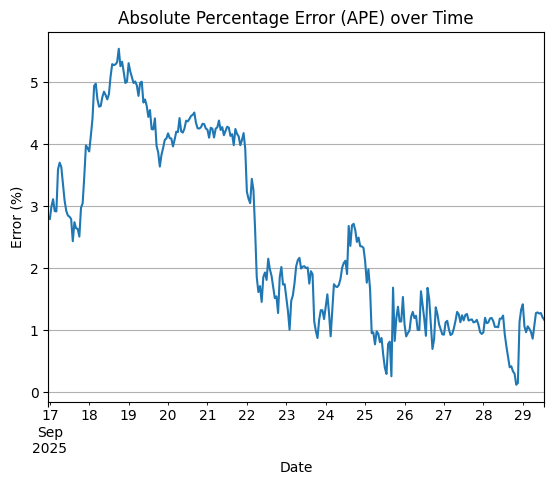

In [16]:
# --- Detailed Error Analysis ---

# Consolidate results into a structured DataFrame for point-wise analysis
r = pd.DataFrame({
    'Date': future_index,
    'Real values': y_true_wf,
    'Predictions': predictions_wf
})
r.set_index('Date', inplace=True)

# Calculate the Absolute Error (AE) for each step
# Formula: $AE = |y_{true} - y_{pred}|$
r['AE'] = abs(r['Real values'] - r['Predictions'])

# Calculate the Absolute Percentage Error (APE) for each step
# Formula: $APE = |\frac{y_{true} - y_{pred}}{y_{true}}| \times 100$
r['APE'] = (
    abs(r['AE'] / r['Real values']) 
    * 100
)

# Visualize the error trend over the prediction horizon
# Using the default backend (Matplotlib) for a quick diagnostic plot
r['APE'].plot(
    title='Absolute Percentage Error (APE) over Time',
    ylabel='Error (%)',
    xlabel='Date',
    grid=True,
)

## 4- Expérimentation

À ce stade de la démarche, tous les outils nécessaires ont été mis en place : le pipeline de préparation des données, l’architecture modulaire du modèle, la stratégie d’évaluation (*walk-forward*), ainsi que les métriques pertinentes. Il ne reste plus qu’à lancer l’expérimentation.

Puisqu’il s’agit d’une optimisation systématique de modèles, il est essentiel de définir précisément quels hyperparamètres seront explorés et pourquoi. Les choix retenus visent à couvrir les dimensions critiques de la modélisation temporelle dans un contexte de marché bruité comme celui des cryptomonnaies :

- *Input_width* : Définit la mémoire temporelle du modèle, c’est-à-dire le nombre de pas passés utilisés pour prédire le futur. Une fenêtre trop courte prive le modèle de contexte nécessaire (ex. tendance, cycle), une fenêtre trop longue introduit du bruit ancien ou des régimes de marché obsolètes, ce qui nuit à la généralisation.

- *Batch_size* : Correspond à la taille des mini-lots utilisés lors de la descente de gradient. C’est un compromis entre stabilité et exploration : des lots plus petits introduisent du bruit dans les mises à jour, ce qui peut aider à échapper aux minima locaux, mais augmente le coût computationnel et la variance de l’apprentissage. Des lots plus grands offrent des gradients plus stables, au risque de converger vers des solutions sous-optimales.

- *Learning_rate* : C’est le pas de mise à jour des poids à chaque itération. Il contrôle à la fois la vitesse de convergence et la qualité du minimum atteint. Un taux trop faible ralentit l’apprentissage ; un taux trop élevé provoque des oscillations ou une divergence, car les mises à jour « dépassent » les zones optimales.

- *Model_units* : Définit la richesse des représentations internes du modèle. Trop peu d’unités entraînent un sous-apprentissage (le modèle ne peut pas capturer les dynamiques temporelles complexes) ; trop d’unités favorisent le surapprentissage, surtout sur des données bruitées comme les prix de cryptomonnaies, où le modèle mémorise le hasard plutôt qu’un signal véritable.

- *Drop_out* : Mécanisme de régularisation qui désactive aléatoirement une fraction des neurones pendant l’entraînement. Cela force le réseau à ne pas dépendre de chemins spécifiques et à distribuer l’information, ce qui limite fortement le surapprentissage. Un taux trop élevé peut toutefois empêcher l’apprentissage utile (sous-apprentissage).

- *Number_of_layer* : Profondeur du réseau. Plus il y a de couches, plus le modèle peut extraire des motifs temporels hiérarchiques (ex. : variations locales → tendances → régimes). Cependant, dans les architectures récurrentes, une profondeur excessive aggrave les problèmes de gradients (disparition ou explosion), surtout sur des séquences longues, rendant l’entraînement instable ou inefficace.

- *loss_function* : La fonction de perte définit ce que le modèle cherche à minimiser, donc ce qu’il considère comme une « bonne » prédiction :

    - *MSE* pénalise fortement les grandes erreurs, ce qui la rend sensible aux outliers.

    - *MAE* traite toutes les erreurs de façon linéaire, offrant plus de robustesse, mais moins de sensibilité aux écarts extrêmes.

    - *Huber* combine les deux : robuste aux outliers, tout en restant sensible aux petites erreurs.

L’exploration de ces hyperparamètres, combinée à l’étude de trois architectures de réseaux de neurones différentes (LSTM, GRU et SimpleRNN), conduit à un nombre élevé d’expériences, environ une centaine, même en se limitant à des variations univariées (c’est-à-dire en faisant varier un seul hyperparamètre à la fois).  

Dans ce contexte, la traçabilité manuelle devient rapidement impraticable. Pourtant, elle est indispensable : sans un suivi rigoureux, il est impossible de reproduire les résultats, de comparer objectivement les performances ou d’identifier les facteurs réellement influents sur la qualité des prédictions.

C’est pourquoi MLflow a été intégré au pipeline expérimental. Cet outil permet d’enregistrer automatiquement, pour chaque exécution :

- Les hyperparamètres utilisés,

- Les métriques d’évaluation (MAE, RMSE, pertes d’entraînement, etc.),

- Les artefacts produits (modèles sauvegardés, figures de prédictions, courbes d’apprentissage).

A cela se rajoute un script qui permet d’afficher les différentes courbes pour analyser les résultats.

In [ ]:
# MLflow Hyperparameter Sweep - Normal Price Values.

# --- Configuration & Search Space ---
date = datetime.datetime.now().strftime("%Y_%m_%d")
model_list = ["lstm", "gru", "simplernn"]

search_space = {
    "input_width": [12, 24, 48, 72, 96],
    "batch_size": [16, 32, 64, 128],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1],
    "model_units": [10, 50, 100, 200],
    "dropout_rate": [0, 0.2, 0.5, 0.8],
    "number_of_layer": [1, 2, 3, 4],
    "loss_function": ['mae', 'mse', 'huber'],
}

base_config = {
    "input_width": 24,
    "batch_size": 32,
    "epochs": 50,
    "learning_rate": 0.001,
    "model_units": 50,
    "dense_units": 1,
    "dropout_rate": 0.2,
    "number_of_layer": 1,
    "loss_function": 'mae',
    "train_ratio": 0.7,
    "val_ratio": 0.25,
    'optimizer_name': 'adam',
}

# --- Experiment Loop ---

for model_type in model_list:
    for param_name, values in search_space.items():
        # Set experiment scope per model/parameter combination
        experiment_name = f"{model_type}_{param_name}_{date}"
        mlflow.set_experiment(experiment_name)

        for value in values:
            print(f"--- Model: {model_type} | Param: {param_name} = {value} ---")
            
            # Memoriy cleanup and seed reset for reproducibility
            tf.keras.backend.clear_session()
            set_seed(42)
            
            # Generate configuration for this specific run         
            run_config = base_config.copy() 
            run_config[param_name] = value
            run_name = f"{param_name}_{value}"

            with mlflow.start_run(run_name=run_name):
                # 1. Logging Metadata 
                mlflow.log_params(run_config)
                mlflow.log_param("model_name", model_type)
                mlflow.log_param("studied_parameter", param_name)

                # 2. Data Preparation
                df_raw = pd.read_csv('../data/dataset/BTCUSDT_1h.csv')
                df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'], unit='ms')
                df_raw.set_index('timestamp', inplace=True)
                
                # Filter for 2025 data (Normal values, no log-transform)
                df_2025= df_raw[df_raw.index.year == 2025][['close']].sort_index()

                df_train, df_val, df_test, train_gen, val_gen, test_gen, scaler = (
                    split_and_generate_dataset(
                        df_2025,
                        input_width=run_config['input_width'],
                        batch_size=run_config['batch_size'],
                    )
                )
                
                # 3. Model Architecture Construction
                input_shape = (run_config['input_width'], 1)
                layer_config = []
                
                for i in range(run_config['number_of_layer']):
                    layer_config.append({
                        'type' : model_type,
                        'units': run_config['model_units'],
                        'return_sequences': True if i < run_config['number_of_layer'] - 1 else False
                    })
                    layer_config.append({
                        'type' : 'dropout',
                        'rate': run_config['dropout_rate']
                    })
                
                layer_config.append({
                    'type' : 'dense',
                    'units': run_config['dense_units']
                    })
                    
                mg = ModelGenerator(input_shape=input_shape)
                model = mg.build_model(
                    layers_config=layer_config,
                    optimizer_name=run_config['optimizer_name'],
                    optimizer_config={'learning_rate': run_config['learning_rate']},
                    loss=run_config['loss_function'],
                    metrics=['mae', RootMeanSquaredError()]
                )
                
                # 4. Training with Early Stopping
                early_stop = EarlyStopping(
                    monitor='val_loss',
                    patience=20,
                    restore_best_weights=True
                    )
                history = mg.train(
                    train_gen,
                    val_gen,
                    epochs=run_config['epochs'],
                    callbacks=[early_stop]
                    )

                # 5. Log Training Metrics
                mlflow.log_metrics({
                    "final_train_loss": history.history['loss'][-1],
                    "final_val_loss": history.history['val_loss'][-1],
                    "final_val_mae": history.history['val_mae'][-1],
                    "final_val_rmse": history.history['val_root_mean_squared_error'][-1],
                })


                mlflow.keras.log_model(mg.model, name="model")
                mlflow.sklearn.log_model(scaler, name="scaler")

                # 6. Walk-Forward Prediction & Plotting
                predictions_wf, y_true_wf, df_init, future_index = run_walkforward_prediction(
                    df_test=df_test,
                    model=mg.model,
                    scaler=scaler,
                    input_width=run_config['input_width']
                )

                if predictions_wf is not None:
                    # Data consolidation for visualization
                    plot_df = pd.DataFrame({
                        'Date': future_index,
                        'Real values': y_true_wf,
                        'Predictions': predictions_wf
                    }).melt(id_vars='Date', var_name='Type', value_name='Valeur')

                    initial_df = pd.DataFrame({
                        'Date': df_init.index,
                        'Valeur': df_init['close'].values, 
                        'Type': 'Initial sequence'
                    })

                    full_plot_df = pd.concat([initial_df, plot_df], ignore_index=True)
                    
                    # Export data and log artifacts
                    dir_path = f"data/{date}/normal_value/{model_type}"
                    os.makedirs(dir_path, exist_ok=True)
                    full_plot_df.to_csv(f"{dir_path}/{run_name}.csv", index=False)

                    mlflow.log_table(data=full_plot_df, artifact_file="predictions_table.json")
                    
                    fig2 = px.line(
                        full_plot_df, x='Date', y='Valeur', color='Type',
                        title=f'WF Pred: {model_type.upper()} | {param_name}={value}',
                        template='simple_white', color_discrete_map=custom_colors
                    )

                    plot_path = f"plot_{model_type}_{run_name}.html"
                    plot(fig2, filename=plot_path, auto_open=False)
                    mlflow.log_artifact(plot_path)
                    if os.path.exists(plot_path): os.remove(plot_path)

print("MLflow grid search cycle complete.")

2026/01/15 19:11:10 INFO mlflow.tracking.fluent: Experiment with name 'lstm_input_width_2026_01_15' does not exist. Creating a new experiment.


--- Model: lstm | Param: input_width = 12 ---
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0917 - mae: 0.0917 - root_mean_squared_error: 0.1436 - val_loss: 0.0753 - val_mae: 0.0753 - val_root_mean_squared_error: 0.0825
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0544 - mae: 0.0544 - root_mean_squared_error: 0.0694 - val_loss: 0.0375 - val_mae: 0.0375 - val_root_mean_squared_error: 0.0455
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0526 - mae: 0.0526 - root_mean_squared_error: 0.0681 - val_loss: 0.0567 - val_mae: 0.0567 - val_root_mean_squared_error: 0.0658
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0556 - mae: 0.0556 - root_mean_squared_error: 0.0715 - val_loss: 0.0733 - val_mae: 0.0733 - val_root_mean_squared_error: 0.0819
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0528 - mae: 0.0528 - root_mean_squared_error: 0.0689 - val_loss: 0.0331 - val_mae: 0.0331 - val_root_mean_squared_error: 0.0407
Epoc

2026/01/15 19:11:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:11:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:11:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:11:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: input_width = 24 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0939 - mae: 0.0939 - root_mean_squared_error: 0.1429 - val_loss: 0.0597 - val_mae: 0.0597 - val_root_mean_squared_error: 0.0713
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0663 - mae: 0.0663 - root_mean_squared_error: 0.0858 - val_loss: 0.0466 - val_mae: 0.0466 - val_root_mean_squared_error: 0.0575
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0674 - mae: 0.0674 - root_mean_squared_error: 0.0866 - val_loss: 0.0569 - val_mae: 0.0569 - val_root_mean_squared_error: 0.0687
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0662 - mae: 0.0662 - root_mean_squared_error: 0.0843 - val_loss: 0.0620 - val_mae: 0.0620 - val_root_mean_squared_error: 0.0740
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0647 - mae: 0.0647 - root_mean_squared_error: 0.0830 - val_loss: 0.0659 - val_mae: 0.0659 - val_root_mean_squared_error: 0.0781
Epoc

2026/01/15 19:12:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:12:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:12:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:12:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: input_width = 48 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1027 - mae: 0.1027 - root_mean_squared_error: 0.1499 - val_loss: 0.0738 - val_mae: 0.0738 - val_root_mean_squared_error: 0.0886
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0815 - mae: 0.0815 - root_mean_squared_error: 0.1022 - val_loss: 0.0879 - val_mae: 0.0879 - val_root_mean_squared_error: 0.1024
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0800 - mae: 0.0800 - root_mean_squared_error: 0.1001 - val_loss: 0.0863 - val_mae: 0.0863 - val_root_mean_squared_error: 0.1010
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0790 - mae: 0.0790 - root_mean_squared_error: 0.0983 - val_loss: 0.0955 - val_mae: 0.0955 - val_root_mean_squared_error: 0.1100
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0792 - mae: 0.0792 - root_mean_squared_error: 0.0994 - val_loss: 0.0986 - val_mae: 0.0986 - val_root_mean_squared_error: 0.1131
Epo

2026/01/15 19:13:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:13:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:13:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:13:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: input_width = 72 ---
Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1110 - mae: 0.1110 - root_mean_squared_error: 0.1565 - val_loss: 0.1211 - val_mae: 0.1211 - val_root_mean_squared_error: 0.1362
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0921 - mae: 0.0921 - root_mean_squared_error: 0.1142 - val_loss: 0.1173 - val_mae: 0.1173 - val_root_mean_squared_error: 0.1330
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0906 - mae: 0.0906 - root_mean_squared_error: 0.1122 - val_loss: 0.0945 - val_mae: 0.0945 - val_root_mean_squared_error: 0.1113
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0938 - mae: 0.0938 - root_mean_squared_error: 0.1148 - val_loss: 0.0823 - val_mae: 0.0823 - val_root_mean_squared_error: 0.0991
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0923 - mae: 0.0923 - root_mean_squared_error: 0.1137 - val_loss: 0.0831 - val_mae: 0.0831 - val_root_mean_squared_error: 0.1001

2026/01/15 19:14:54 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:15:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:15:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:15:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: input_width = 96 ---
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1171 - mae: 0.1171 - root_mean_squared_error: 0.1613 - val_loss: 0.1335 - val_mae: 0.1335 - val_root_mean_squared_error: 0.1496
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0981 - mae: 0.0981 - root_mean_squared_error: 0.1209 - val_loss: 0.1227 - val_mae: 0.1227 - val_root_mean_squared_error: 0.1398
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0994 - mae: 0.0994 - root_mean_squared_error: 0.1224 - val_loss: 0.1166 - val_mae: 0.1166 - val_root_mean_squared_error: 0.1339
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1021 - mae: 0.1021 - root_mean_squared_error: 0.1251 - val_loss: 0.1117 - val_mae: 0.1117 - val_root_mean_squared_error: 0.1291
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1000 - mae: 0.1000 - root_mean_squared_error: 0.1225 - val_loss: 0.1010 - val_mae: 0.1010 - val_root_mean_squared_error: 0.1183

2026/01/15 19:16:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:16:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:16:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:16:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 19:16:48 INFO mlflow.tracking.fluent: Experiment with name 'lstm_batch_size_2026_01_15' does not exist. Creating a new experiment.


--- Model: lstm | Param: batch_size = 16 ---
Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0805 - mae: 0.0805 - root_mean_squared_error: 0.1178 - val_loss: 0.0547 - val_mae: 0.0547 - val_root_mean_squared_error: 0.0662
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0608 - mae: 0.0608 - root_mean_squared_error: 0.0787 - val_loss: 0.1008 - val_mae: 0.1008 - val_root_mean_squared_error: 0.1109
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0589 - mae: 0.0589 - root_mean_squared_error: 0.0757 - val_loss: 0.0714 - val_mae: 0.0714 - val_root_mean_squared_error: 0.0836
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0581 - mae: 0.0581 - root_mean_squared_error: 0.0750 - val_loss: 0.0866 - val_mae: 0.0866 - val_root_mean_squared_error: 0.0985
Epoch 5/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0588 - mae: 0.0588 - root_mean_squared_error: 0.0758 - val_loss: 0.1032 - val_mae: 0.1032 - val_root_mean_squared_error: 0.1146
Epoch

2026/01/15 19:17:55 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:18:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:18:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:18:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: batch_size = 32 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0939 - mae: 0.0939 - root_mean_squared_error: 0.1429 - val_loss: 0.0597 - val_mae: 0.0597 - val_root_mean_squared_error: 0.0713
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0663 - mae: 0.0663 - root_mean_squared_error: 0.0858 - val_loss: 0.0466 - val_mae: 0.0466 - val_root_mean_squared_error: 0.0575
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0674 - mae: 0.0674 - root_mean_squared_error: 0.0866 - val_loss: 0.0569 - val_mae: 0.0569 - val_root_mean_squared_error: 0.0687
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0662 - mae: 0.0662 - root_mean_squared_error: 0.0843 - val_loss: 0.0620 - val_mae: 0.0620 - val_root_mean_squared_error: 0.0740
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0647 - mae: 0.0647 - root_mean_squared_error: 0.0830 - val_loss: 0.0659 - val_mae: 0.0659 - val_root_mean_squared_error: 0.0781
Epoch

2026/01/15 19:18:44 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:18:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:18:52 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:18:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: batch_size = 64 ---
Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1395 - mae: 0.1395 - root_mean_squared_error: 0.2023 - val_loss: 0.1196 - val_mae: 0.1196 - val_root_mean_squared_error: 0.1291
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0850 - mae: 0.0850 - root_mean_squared_error: 0.1078 - val_loss: 0.1547 - val_mae: 0.1547 - val_root_mean_squared_error: 0.1623
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0825 - mae: 0.0825 - root_mean_squared_error: 0.1049 - val_loss: 0.1577 - val_mae: 0.1577 - val_root_mean_squared_error: 0.1652
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0808 - mae: 0.0808 - root_mean_squared_error: 0.1017 - val_loss: 0.1525 - val_mae: 0.1525 - val_root_mean_squared_error: 0.1601
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0791 - mae: 0.0791 - root_mean_squared_error: 0.1003 - val_loss: 0.1579 - val_mae: 0.1579 - val_root_mean_squared_error: 0.1653
Epoch 6/50
71/

2026/01/15 19:19:43 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:19:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:19:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:19:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: batch_size = 128 ---
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1970 - mae: 0.1970 - root_mean_squared_error: 0.2719 - val_loss: 0.0770 - val_mae: 0.0770 - val_root_mean_squared_error: 0.0852
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0746 - mae: 0.0746 - root_mean_squared_error: 0.0951 - val_loss: 0.0562 - val_mae: 0.0562 - val_root_mean_squared_error: 0.0658
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0638 - mae: 0.0638 - root_mean_squared_error: 0.0833 - val_loss: 0.0644 - val_mae: 0.0644 - val_root_mean_squared_error: 0.0733
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0602 - mae: 0.0602 - root_mean_squared_error: 0.0784 - val_loss: 0.0432 - val_mae: 0.0432 - val_root_mean_squared_error: 0.0538
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0575 - mae: 0.0575 - root_mean_squared_error: 0.0747 - val_loss: 0.0400 - val_mae: 0.0400 - val_root_mean_squared_error: 0.0508
Epoch 6/5

2026/01/15 19:20:29 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:20:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:20:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:20:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 19:20:57 INFO mlflow.tracking.fluent: Experiment with name 'lstm_learning_rate_2026_01_15' does not exist. Creating a new experiment.


--- Model: lstm | Param: learning_rate = 0.0001 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2513 - mae: 0.2513 - root_mean_squared_error: 0.3303 - val_loss: 0.1173 - val_mae: 0.1173 - val_root_mean_squared_error: 0.1257
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0791 - mae: 0.0791 - root_mean_squared_error: 0.1013 - val_loss: 0.0952 - val_mae: 0.0952 - val_root_mean_squared_error: 0.1036
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0728 - mae: 0.0728 - root_mean_squared_error: 0.0927 - val_loss: 0.0708 - val_mae: 0.0708 - val_root_mean_squared_error: 0.0797
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0666 - mae: 0.0666 - root_mean_squared_error: 0.0847 - val_loss: 0.0542 - val_mae: 0.0542 - val_root_mean_squared_error: 0.0638
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0633 - mae: 0.0633 - root_mean_squared_error: 0.0821 - val_loss: 0.0610 - val_mae: 0.0610 - val_root_mean_squared_error: 0.069

2026/01/15 19:21:41 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:21:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:21:49 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:21:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: learning_rate = 0.001 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0939 - mae: 0.0939 - root_mean_squared_error: 0.1429 - val_loss: 0.0597 - val_mae: 0.0597 - val_root_mean_squared_error: 0.0713
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0663 - mae: 0.0663 - root_mean_squared_error: 0.0858 - val_loss: 0.0466 - val_mae: 0.0466 - val_root_mean_squared_error: 0.0575
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0674 - mae: 0.0674 - root_mean_squared_error: 0.0866 - val_loss: 0.0569 - val_mae: 0.0569 - val_root_mean_squared_error: 0.0687
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0662 - mae: 0.0662 - root_mean_squared_error: 0.0843 - val_loss: 0.0620 - val_mae: 0.0620 - val_root_mean_squared_error: 0.0740
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0647 - mae: 0.0647 - root_mean_squared_error: 0.0830 - val_loss: 0.0659 - val_mae: 0.0659 - val_root_mean_squared_error: 0.0781

2026/01/15 19:22:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:22:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:22:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:22:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: learning_rate = 0.01 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0893 - mae: 0.0893 - root_mean_squared_error: 0.1194 - val_loss: 0.0803 - val_mae: 0.0803 - val_root_mean_squared_error: 0.0944
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1004 - mae: 0.1004 - root_mean_squared_error: 0.1287 - val_loss: 0.1320 - val_mae: 0.1320 - val_root_mean_squared_error: 0.1497
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1023 - mae: 0.1023 - root_mean_squared_error: 0.1278 - val_loss: 0.1125 - val_mae: 0.1125 - val_root_mean_squared_error: 0.1306
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1073 - mae: 0.1073 - root_mean_squared_error: 0.1323 - val_loss: 0.1271 - val_mae: 0.1271 - val_root_mean_squared_error: 0.1454
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1157 - mae: 0.1157 - root_mean_squared_error: 0.1425 - val_loss: 0.1168 - val_mae: 0.1168 - val_root_mean_squared_error: 0.1353


2026/01/15 19:23:18 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:23:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:23:26 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:23:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: learning_rate = 0.1 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1384 - mae: 0.1384 - root_mean_squared_error: 0.4292 - val_loss: 0.1799 - val_mae: 0.1799 - val_root_mean_squared_error: 0.2010
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1320 - mae: 0.1320 - root_mean_squared_error: 0.1711 - val_loss: 0.1417 - val_mae: 0.1417 - val_root_mean_squared_error: 0.1639
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1337 - mae: 0.1337 - root_mean_squared_error: 0.1713 - val_loss: 0.1468 - val_mae: 0.1468 - val_root_mean_squared_error: 0.1689
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1305 - mae: 0.1305 - root_mean_squared_error: 0.1687 - val_loss: 0.1740 - val_mae: 0.1740 - val_root_mean_squared_error: 0.1954
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1300 - mae: 0.1300 - root_mean_squared_error: 0.1670 - val_loss: 0.1541 - val_mae: 0.1541 - val_root_mean_squared_error: 0.1760
E

2026/01/15 19:24:16 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:24:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:24:24 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:24:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 19:24:46 INFO mlflow.tracking.fluent: Experiment with name 'lstm_model_units_2026_01_15' does not exist. Creating a new experiment.


--- Model: lstm | Param: model_units = 10 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1192 - mae: 0.1192 - root_mean_squared_error: 0.1582 - val_loss: 0.1126 - val_mae: 0.1126 - val_root_mean_squared_error: 0.1241
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0929 - mae: 0.0929 - root_mean_squared_error: 0.1215 - val_loss: 0.1071 - val_mae: 0.1071 - val_root_mean_squared_error: 0.1180
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0854 - mae: 0.0854 - root_mean_squared_error: 0.1114 - val_loss: 0.1251 - val_mae: 0.1251 - val_root_mean_squared_error: 0.1350
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0818 - mae: 0.0818 - root_mean_squared_error: 0.1078 - val_loss: 0.1030 - val_mae: 0.1030 - val_root_mean_squared_error: 0.1140
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0802 - mae: 0.0802 - root_mean_squared_error: 0.1041 - val_loss: 0.1165 - val_mae: 0.1165 - val_root_mean_squared_error: 0.1266
Epoc

2026/01/15 19:25:19 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:25:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:25:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:25:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: model_units = 50 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0939 - mae: 0.0939 - root_mean_squared_error: 0.1429 - val_loss: 0.0597 - val_mae: 0.0597 - val_root_mean_squared_error: 0.0713
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0663 - mae: 0.0663 - root_mean_squared_error: 0.0858 - val_loss: 0.0466 - val_mae: 0.0466 - val_root_mean_squared_error: 0.0575
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0674 - mae: 0.0674 - root_mean_squared_error: 0.0866 - val_loss: 0.0569 - val_mae: 0.0569 - val_root_mean_squared_error: 0.0687
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0662 - mae: 0.0662 - root_mean_squared_error: 0.0843 - val_loss: 0.0620 - val_mae: 0.0620 - val_root_mean_squared_error: 0.0740
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0647 - mae: 0.0647 - root_mean_squared_error: 0.0830 - val_loss: 0.0659 - val_mae: 0.0659 - val_root_mean_squared_error: 0.0781
Epoc

2026/01/15 19:26:09 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:26:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:26:16 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:26:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: model_units = 100 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0808 - mae: 0.0808 - root_mean_squared_error: 0.1275 - val_loss: 0.0659 - val_mae: 0.0659 - val_root_mean_squared_error: 0.0763
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0559 - mae: 0.0559 - root_mean_squared_error: 0.0716 - val_loss: 0.0698 - val_mae: 0.0698 - val_root_mean_squared_error: 0.0811
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0601 - mae: 0.0601 - root_mean_squared_error: 0.0778 - val_loss: 0.0403 - val_mae: 0.0403 - val_root_mean_squared_error: 0.0507
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0662 - mae: 0.0662 - root_mean_squared_error: 0.0856 - val_loss: 0.0572 - val_mae: 0.0572 - val_root_mean_squared_error: 0.0691
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0629 - mae: 0.0629 - root_mean_squared_error: 0.0810 - val_loss: 0.0520 - val_mae: 0.0520 - val_root_mean_squared_error: 0.0635
Epo

2026/01/15 19:27:07 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:27:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:27:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:27:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: model_units = 200 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0780 - mae: 0.0780 - root_mean_squared_error: 0.1168 - val_loss: 0.1165 - val_mae: 0.1165 - val_root_mean_squared_error: 0.1247
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0520 - mae: 0.0520 - root_mean_squared_error: 0.0674 - val_loss: 0.1026 - val_mae: 0.1026 - val_root_mean_squared_error: 0.1126
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0546 - mae: 0.0546 - root_mean_squared_error: 0.0709 - val_loss: 0.1118 - val_mae: 0.1118 - val_root_mean_squared_error: 0.1222
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0589 - mae: 0.0589 - root_mean_squared_error: 0.0768 - val_loss: 0.0425 - val_mae: 0.0425 - val_root_mean_squared_error: 0.0529
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0709 - mae: 0.0709 - root_mean_squared_error: 0.0912 - val_loss: 0.0672 - val_mae: 0.0672 - val_root_mean_squared_error: 0.079

2026/01/15 19:28:28 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:28:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:28:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:28:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 19:28:58 INFO mlflow.tracking.fluent: Experiment with name 'lstm_dropout_rate_2026_01_15' does not exist. Creating a new experiment.


--- Model: lstm | Param: dropout_rate = 0 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0733 - mae: 0.0733 - root_mean_squared_error: 0.1302 - val_loss: 0.0881 - val_mae: 0.0881 - val_root_mean_squared_error: 0.0992
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0458 - mae: 0.0458 - root_mean_squared_error: 0.0608 - val_loss: 0.0638 - val_mae: 0.0638 - val_root_mean_squared_error: 0.0758
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0519 - mae: 0.0519 - root_mean_squared_error: 0.0678 - val_loss: 0.0597 - val_mae: 0.0597 - val_root_mean_squared_error: 0.0714
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0524 - mae: 0.0524 - root_mean_squared_error: 0.0677 - val_loss: 0.0590 - val_mae: 0.0590 - val_root_mean_squared_error: 0.0706
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0508 - mae: 0.0508 - root_mean_squared_error: 0.0657 - val_loss: 0.0622 - val_mae: 0.0622 - val_root_mean_squared_error: 0.0741
Epoc

2026/01/15 19:29:19 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:29:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:29:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:29:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: dropout_rate = 0.2 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0939 - mae: 0.0939 - root_mean_squared_error: 0.1429 - val_loss: 0.0597 - val_mae: 0.0597 - val_root_mean_squared_error: 0.0713
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0663 - mae: 0.0663 - root_mean_squared_error: 0.0858 - val_loss: 0.0466 - val_mae: 0.0466 - val_root_mean_squared_error: 0.0575
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0674 - mae: 0.0674 - root_mean_squared_error: 0.0866 - val_loss: 0.0569 - val_mae: 0.0569 - val_root_mean_squared_error: 0.0687
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0662 - mae: 0.0662 - root_mean_squared_error: 0.0843 - val_loss: 0.0620 - val_mae: 0.0620 - val_root_mean_squared_error: 0.0740
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0647 - mae: 0.0647 - root_mean_squared_error: 0.0830 - val_loss: 0.0659 - val_mae: 0.0659 - val_root_mean_squared_error: 0.0781
Ep

2026/01/15 19:30:09 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:30:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:30:17 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:30:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: dropout_rate = 0.5 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1245 - mae: 0.1245 - root_mean_squared_error: 0.1759 - val_loss: 0.1019 - val_mae: 0.1019 - val_root_mean_squared_error: 0.1119
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0888 - mae: 0.0888 - root_mean_squared_error: 0.1152 - val_loss: 0.0821 - val_mae: 0.0821 - val_root_mean_squared_error: 0.0939
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0860 - mae: 0.0860 - root_mean_squared_error: 0.1116 - val_loss: 0.0525 - val_mae: 0.0525 - val_root_mean_squared_error: 0.0641
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0849 - mae: 0.0849 - root_mean_squared_error: 0.1097 - val_loss: 0.0993 - val_mae: 0.0993 - val_root_mean_squared_error: 0.1103
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0797 - mae: 0.0797 - root_mean_squared_error: 0.1024 - val_loss: 0.0961 - val_mae: 0.0961 - val_root_mean_squared_error: 0.1075
Ep

2026/01/15 19:31:01 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:31:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:31:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:31:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: dropout_rate = 0.8 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1836 - mae: 0.1836 - root_mean_squared_error: 0.2485 - val_loss: 0.1669 - val_mae: 0.1669 - val_root_mean_squared_error: 0.1747
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1316 - mae: 0.1316 - root_mean_squared_error: 0.1735 - val_loss: 0.1253 - val_mae: 0.1253 - val_root_mean_squared_error: 0.1356
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1215 - mae: 0.1215 - root_mean_squared_error: 0.1597 - val_loss: 0.1612 - val_mae: 0.1612 - val_root_mean_squared_error: 0.1700
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1193 - mae: 0.1193 - root_mean_squared_error: 0.1554 - val_loss: 0.1083 - val_mae: 0.1083 - val_root_mean_squared_error: 0.1197
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1150 - mae: 0.1150 - root_mean_squared_error: 0.1481 - val_loss: 0.1317 - val_mae: 0.1317 - val_root_mean_squared_error: 0.1417
Ep

2026/01/15 19:32:15 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:32:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:32:24 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:32:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 19:32:46 INFO mlflow.tracking.fluent: Experiment with name 'lstm_number_of_layer_2026_01_15' does not exist. Creating a new experiment.


--- Model: lstm | Param: number_of_layer = 1 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0939 - mae: 0.0939 - root_mean_squared_error: 0.1429 - val_loss: 0.0597 - val_mae: 0.0597 - val_root_mean_squared_error: 0.0713
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0663 - mae: 0.0663 - root_mean_squared_error: 0.0858 - val_loss: 0.0466 - val_mae: 0.0466 - val_root_mean_squared_error: 0.0575
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0674 - mae: 0.0674 - root_mean_squared_error: 0.0866 - val_loss: 0.0569 - val_mae: 0.0569 - val_root_mean_squared_error: 0.0687
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0662 - mae: 0.0662 - root_mean_squared_error: 0.0843 - val_loss: 0.0620 - val_mae: 0.0620 - val_root_mean_squared_error: 0.0740
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0647 - mae: 0.0647 - root_mean_squared_error: 0.0830 - val_loss: 0.0659 - val_mae: 0.0659 - val_root_mean_squared_error: 0.0781
E

2026/01/15 19:33:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:33:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:33:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:33:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: number_of_layer = 2 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0902 - mae: 0.0902 - root_mean_squared_error: 0.1336 - val_loss: 0.0494 - val_mae: 0.0494 - val_root_mean_squared_error: 0.0598
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0660 - mae: 0.0660 - root_mean_squared_error: 0.0841 - val_loss: 0.0782 - val_mae: 0.0782 - val_root_mean_squared_error: 0.0913
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0695 - mae: 0.0695 - root_mean_squared_error: 0.0900 - val_loss: 0.0816 - val_mae: 0.0816 - val_root_mean_squared_error: 0.0960
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0755 - mae: 0.0755 - root_mean_squared_error: 0.0963 - val_loss: 0.0839 - val_mae: 0.0839 - val_root_mean_squared_error: 0.0988
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0779 - mae: 0.0779 - root_mean_squared_error: 0.1016 - val_loss: 0.0934 - val_mae: 0.0934 - val_root_mean_squared_error: 0.1

2026/01/15 19:34:11 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:34:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:34:18 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:34:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: number_of_layer = 3 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0921 - mae: 0.0921 - root_mean_squared_error: 0.1297 - val_loss: 0.1238 - val_mae: 0.1238 - val_root_mean_squared_error: 0.1344
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0725 - mae: 0.0725 - root_mean_squared_error: 0.0919 - val_loss: 0.0923 - val_mae: 0.0923 - val_root_mean_squared_error: 0.1081
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0910 - mae: 0.0910 - root_mean_squared_error: 0.1159 - val_loss: 0.0982 - val_mae: 0.0982 - val_root_mean_squared_error: 0.1154
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0955 - mae: 0.0955 - root_mean_squared_error: 0.1230 - val_loss: 0.1215 - val_mae: 0.1215 - val_root_mean_squared_error: 0.1398
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0969 - mae: 0.0969 - root_mean_squared_error: 0.1223 - val_loss: 0.1483 - val_mae: 0.1483 - val_root_mean_squared_error: 0.1

2026/01/15 19:35:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:35:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:35:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:35:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: number_of_layer = 4 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0993 - mae: 0.0993 - root_mean_squared_error: 0.1440 - val_loss: 0.1667 - val_mae: 0.1667 - val_root_mean_squared_error: 0.1800
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0806 - mae: 0.0806 - root_mean_squared_error: 0.1024 - val_loss: 0.1237 - val_mae: 0.1237 - val_root_mean_squared_error: 0.1434
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1094 - mae: 0.1094 - root_mean_squared_error: 0.1403 - val_loss: 0.1531 - val_mae: 0.1531 - val_root_mean_squared_error: 0.1737
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1172 - mae: 0.1172 - root_mean_squared_error: 0.1470 - val_loss: 0.1604 - val_mae: 0.1604 - val_root_mean_squared_error: 0.1816
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1288 - mae: 0.1288 - root_mean_squared_error: 0.1633 - val_loss: 0.1774 - val_mae: 0.1774 - val_root_mean_squared_error: 0.1

2026/01/15 19:37:11 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:37:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:37:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:37:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 19:37:43 INFO mlflow.tracking.fluent: Experiment with name 'lstm_loss_function_2026_01_15' does not exist. Creating a new experiment.


--- Model: lstm | Param: loss_function = mae ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0939 - mae: 0.0939 - root_mean_squared_error: 0.1429 - val_loss: 0.0597 - val_mae: 0.0597 - val_root_mean_squared_error: 0.0713
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0663 - mae: 0.0663 - root_mean_squared_error: 0.0858 - val_loss: 0.0466 - val_mae: 0.0466 - val_root_mean_squared_error: 0.0575
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0674 - mae: 0.0674 - root_mean_squared_error: 0.0866 - val_loss: 0.0569 - val_mae: 0.0569 - val_root_mean_squared_error: 0.0687
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0662 - mae: 0.0662 - root_mean_squared_error: 0.0843 - val_loss: 0.0620 - val_mae: 0.0620 - val_root_mean_squared_error: 0.0740
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0647 - mae: 0.0647 - root_mean_squared_error: 0.0830 - val_loss: 0.0659 - val_mae: 0.0659 - val_root_mean_squared_error: 0.0781
E

2026/01/15 19:38:04 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:38:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:38:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:38:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: loss_function = mse ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0215 - mae: 0.0982 - root_mean_squared_error: 0.1467 - val_loss: 0.0049 - val_mae: 0.0584 - val_root_mean_squared_error: 0.0698
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0073 - mae: 0.0664 - root_mean_squared_error: 0.0854 - val_loss: 0.0028 - val_mae: 0.0427 - val_root_mean_squared_error: 0.0534
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0070 - mae: 0.0654 - root_mean_squared_error: 0.0839 - val_loss: 0.0036 - val_mae: 0.0484 - val_root_mean_squared_error: 0.0597
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0067 - mae: 0.0645 - root_mean_squared_error: 0.0821 - val_loss: 0.0051 - val_mae: 0.0596 - val_root_mean_squared_error: 0.0714
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0067 - mae: 0.0637 - root_mean_squared_error: 0.0816 - val_loss: 0.0050 - val_mae: 0.0590 - val_root_mean_squared_error: 0.0709
E

2026/01/15 19:38:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:39:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:39:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:39:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: loss_function = huber ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0108 - mae: 0.0982 - root_mean_squared_error: 0.1467 - val_loss: 0.0024 - val_mae: 0.0585 - val_root_mean_squared_error: 0.0699
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0036 - mae: 0.0664 - root_mean_squared_error: 0.0854 - val_loss: 0.0014 - val_mae: 0.0428 - val_root_mean_squared_error: 0.0535
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - mae: 0.0654 - root_mean_squared_error: 0.0839 - val_loss: 0.0018 - val_mae: 0.0484 - val_root_mean_squared_error: 0.0597
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0034 - mae: 0.0645 - root_mean_squared_error: 0.0821 - val_loss: 0.0025 - val_mae: 0.0596 - val_root_mean_squared_error: 0.0714
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - mae: 0.0637 - root_mean_squared_error: 0.0816 - val_loss: 0.0025 - val_mae: 0.0590 - val_root_mean_squared_error: 0.0709

2026/01/15 19:39:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:39:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:39:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:39:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 19:40:18 INFO mlflow.tracking.fluent: Experiment with name 'gru_input_width_2026_01_15' does not exist. Creating a new experiment.


--- Model: gru | Param: input_width = 12 ---
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0993 - mae: 0.0993 - root_mean_squared_error: 0.1495 - val_loss: 0.0677 - val_mae: 0.0677 - val_root_mean_squared_error: 0.0763
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0612 - mae: 0.0612 - root_mean_squared_error: 0.0788 - val_loss: 0.0398 - val_mae: 0.0398 - val_root_mean_squared_error: 0.0480
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0563 - mae: 0.0563 - root_mean_squared_error: 0.0733 - val_loss: 0.0413 - val_mae: 0.0413 - val_root_mean_squared_error: 0.0491
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0533 - mae: 0.0533 - root_mean_squared_error: 0.0685 - val_loss: 0.0593 - val_mae: 0.0593 - val_root_mean_squared_error: 0.0661
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0491 - mae: 0.0491 - root_mean_squared_error: 0.0644 - val_loss: 0.0302 - val_mae: 0.0302 - val_root_mean_squared_error: 0.0375
Epoch

2026/01/15 19:40:53 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:41:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:41:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:41:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: input_width = 24 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1032 - mae: 0.1032 - root_mean_squared_error: 0.1527 - val_loss: 0.0721 - val_mae: 0.0721 - val_root_mean_squared_error: 0.0839
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0690 - mae: 0.0690 - root_mean_squared_error: 0.0884 - val_loss: 0.0606 - val_mae: 0.0606 - val_root_mean_squared_error: 0.0725
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0654 - mae: 0.0654 - root_mean_squared_error: 0.0840 - val_loss: 0.0494 - val_mae: 0.0494 - val_root_mean_squared_error: 0.0606
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0627 - mae: 0.0627 - root_mean_squared_error: 0.0800 - val_loss: 0.0688 - val_mae: 0.0688 - val_root_mean_squared_error: 0.0790
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0597 - mae: 0.0597 - root_mean_squared_error: 0.0766 - val_loss: 0.0702 - val_mae: 0.0702 - val_root_mean_squared_error: 0.0806
Epoch

2026/01/15 19:42:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:42:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:42:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:42:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: input_width = 48 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1105 - mae: 0.1105 - root_mean_squared_error: 0.1580 - val_loss: 0.0803 - val_mae: 0.0803 - val_root_mean_squared_error: 0.0952
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0813 - mae: 0.0813 - root_mean_squared_error: 0.1019 - val_loss: 0.0903 - val_mae: 0.0903 - val_root_mean_squared_error: 0.1045
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0787 - mae: 0.0787 - root_mean_squared_error: 0.0983 - val_loss: 0.0760 - val_mae: 0.0760 - val_root_mean_squared_error: 0.0908
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0771 - mae: 0.0771 - root_mean_squared_error: 0.0958 - val_loss: 0.0739 - val_mae: 0.0739 - val_root_mean_squared_error: 0.0883
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0759 - mae: 0.0759 - root_mean_squared_error: 0.0952 - val_loss: 0.0836 - val_mae: 0.0836 - val_root_mean_squared_error: 0.0971


2026/01/15 19:44:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:44:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:44:13 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:44:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: input_width = 72 ---
Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.1181 - mae: 0.1181 - root_mean_squared_error: 0.1641 - val_loss: 0.1029 - val_mae: 0.1029 - val_root_mean_squared_error: 0.1192
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0915 - mae: 0.0915 - root_mean_squared_error: 0.1134 - val_loss: 0.0754 - val_mae: 0.0754 - val_root_mean_squared_error: 0.0926
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0903 - mae: 0.0903 - root_mean_squared_error: 0.1118 - val_loss: 0.0760 - val_mae: 0.0760 - val_root_mean_squared_error: 0.0934
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0890 - mae: 0.0890 - root_mean_squared_error: 0.1093 - val_loss: 0.0814 - val_mae: 0.0814 - val_root_mean_squared_error: 0.0987
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0864 - mae: 0.0864 - root_mean_squared_error: 0.1063 - val_loss: 0.0824 - val_mae: 0.0824 - val_root_mean_squared_error: 0.0996


2026/01/15 19:46:28 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:46:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:46:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:46:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: input_width = 96 ---
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.1219 - mae: 0.1219 - root_mean_squared_error: 0.1672 - val_loss: 0.1160 - val_mae: 0.1160 - val_root_mean_squared_error: 0.1334
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0976 - mae: 0.0976 - root_mean_squared_error: 0.1204 - val_loss: 0.1086 - val_mae: 0.1086 - val_root_mean_squared_error: 0.1262
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0966 - mae: 0.0966 - root_mean_squared_error: 0.1188 - val_loss: 0.1138 - val_mae: 0.1138 - val_root_mean_squared_error: 0.1312
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0954 - mae: 0.0954 - root_mean_squared_error: 0.1167 - val_loss: 0.1228 - val_mae: 0.1228 - val_root_mean_squared_error: 0.1396
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0953 - mae: 0.0953 - root_mean_squared_error: 0.1167 - val_loss: 0.0985 - val_mae: 0.0985 - val_root_mean_squared_error: 0.1161


2026/01/15 19:49:22 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:49:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:49:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:49:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 19:49:49 INFO mlflow.tracking.fluent: Experiment with name 'gru_batch_size_2026_01_15' does not exist. Creating a new experiment.


--- Model: gru | Param: batch_size = 16 ---
Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0822 - mae: 0.0822 - root_mean_squared_error: 0.1216 - val_loss: 0.0726 - val_mae: 0.0726 - val_root_mean_squared_error: 0.0839
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0621 - mae: 0.0621 - root_mean_squared_error: 0.0801 - val_loss: 0.0972 - val_mae: 0.0972 - val_root_mean_squared_error: 0.1067
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0567 - mae: 0.0567 - root_mean_squared_error: 0.0728 - val_loss: 0.0930 - val_mae: 0.0930 - val_root_mean_squared_error: 0.1032
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0550 - mae: 0.0550 - root_mean_squared_error: 0.0711 - val_loss: 0.0868 - val_mae: 0.0868 - val_root_mean_squared_error: 0.0983
Epoch 5/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0543 - mae: 0.0543 - root_mean_squared_error: 0.0699 - val_loss: 0.0896 - val_mae: 0.0896 - val_root_mean_squared_error: 0.1021
Epoch 

2026/01/15 19:51:08 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:51:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:51:16 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:51:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: batch_size = 32 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1032 - mae: 0.1032 - root_mean_squared_error: 0.1527 - val_loss: 0.0721 - val_mae: 0.0721 - val_root_mean_squared_error: 0.0839
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0690 - mae: 0.0690 - root_mean_squared_error: 0.0884 - val_loss: 0.0606 - val_mae: 0.0606 - val_root_mean_squared_error: 0.0725
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0654 - mae: 0.0654 - root_mean_squared_error: 0.0840 - val_loss: 0.0494 - val_mae: 0.0494 - val_root_mean_squared_error: 0.0606
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0627 - mae: 0.0627 - root_mean_squared_error: 0.0800 - val_loss: 0.0688 - val_mae: 0.0688 - val_root_mean_squared_error: 0.0790
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0597 - mae: 0.0597 - root_mean_squared_error: 0.0766 - val_loss: 0.0702 - val_mae: 0.0702 - val_root_mean_squared_error: 0.0806
Epoch 

2026/01/15 19:52:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:52:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:52:37 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:52:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: batch_size = 64 ---
Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1808 - mae: 0.1808 - root_mean_squared_error: 0.2368 - val_loss: 0.0932 - val_mae: 0.0932 - val_root_mean_squared_error: 0.1032
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0927 - mae: 0.0927 - root_mean_squared_error: 0.1164 - val_loss: 0.0963 - val_mae: 0.0963 - val_root_mean_squared_error: 0.1056
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0792 - mae: 0.0792 - root_mean_squared_error: 0.1002 - val_loss: 0.0863 - val_mae: 0.0863 - val_root_mean_squared_error: 0.0959
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0712 - mae: 0.0712 - root_mean_squared_error: 0.0903 - val_loss: 0.0851 - val_mae: 0.0851 - val_root_mean_squared_error: 0.0945
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0639 - mae: 0.0639 - root_mean_squared_error: 0.0824 - val_loss: 0.0875 - val_mae: 0.0875 - val_root_mean_squared_error: 0.0961
Epoch 6/50
71/7

2026/01/15 19:53:20 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:53:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:53:28 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:53:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: batch_size = 128 ---
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2085 - mae: 0.2085 - root_mean_squared_error: 0.2844 - val_loss: 0.0411 - val_mae: 0.0411 - val_root_mean_squared_error: 0.0517
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1084 - mae: 0.1084 - root_mean_squared_error: 0.1391 - val_loss: 0.0491 - val_mae: 0.0491 - val_root_mean_squared_error: 0.0591
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1113 - mae: 0.1113 - root_mean_squared_error: 0.1403 - val_loss: 0.0354 - val_mae: 0.0354 - val_root_mean_squared_error: 0.0460
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0909 - mae: 0.0909 - root_mean_squared_error: 0.1157 - val_loss: 0.0408 - val_mae: 0.0408 - val_root_mean_squared_error: 0.0507
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0788 - mae: 0.0788 - root_mean_squared_error: 0.1011 - val_loss: 0.0444 - val_mae: 0.0444 - val_root_mean_squared_error: 0.0539
Epoch 6/50

2026/01/15 19:54:07 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:54:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:54:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:54:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 19:54:39 INFO mlflow.tracking.fluent: Experiment with name 'gru_learning_rate_2026_01_15' does not exist. Creating a new experiment.


--- Model: gru | Param: learning_rate = 0.0001 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3112 - mae: 0.3112 - root_mean_squared_error: 0.3716 - val_loss: 0.1348 - val_mae: 0.1348 - val_root_mean_squared_error: 0.1433
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1047 - mae: 0.1047 - root_mean_squared_error: 0.1306 - val_loss: 0.0618 - val_mae: 0.0618 - val_root_mean_squared_error: 0.0735
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0935 - mae: 0.0935 - root_mean_squared_error: 0.1173 - val_loss: 0.0577 - val_mae: 0.0577 - val_root_mean_squared_error: 0.0693
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0843 - mae: 0.0843 - root_mean_squared_error: 0.1058 - val_loss: 0.0539 - val_mae: 0.0539 - val_root_mean_squared_error: 0.0654
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0775 - mae: 0.0775 - root_mean_squared_error: 0.0992 - val_loss: 0.0447 - val_mae: 0.0447 - val_root_mean_squared_error: 0.0566

2026/01/15 19:55:18 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:55:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:55:26 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:55:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: learning_rate = 0.001 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1032 - mae: 0.1032 - root_mean_squared_error: 0.1527 - val_loss: 0.0721 - val_mae: 0.0721 - val_root_mean_squared_error: 0.0839
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0690 - mae: 0.0690 - root_mean_squared_error: 0.0884 - val_loss: 0.0606 - val_mae: 0.0606 - val_root_mean_squared_error: 0.0725
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0654 - mae: 0.0654 - root_mean_squared_error: 0.0840 - val_loss: 0.0494 - val_mae: 0.0494 - val_root_mean_squared_error: 0.0606
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0627 - mae: 0.0627 - root_mean_squared_error: 0.0800 - val_loss: 0.0688 - val_mae: 0.0688 - val_root_mean_squared_error: 0.0790
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0597 - mae: 0.0597 - root_mean_squared_error: 0.0766 - val_loss: 0.0702 - val_mae: 0.0702 - val_root_mean_squared_error: 0.0806


2026/01/15 19:56:39 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:56:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:56:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:56:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: learning_rate = 0.01 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0851 - mae: 0.0851 - root_mean_squared_error: 0.1112 - val_loss: 0.1551 - val_mae: 0.1551 - val_root_mean_squared_error: 0.1661
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0827 - mae: 0.0827 - root_mean_squared_error: 0.1032 - val_loss: 0.0553 - val_mae: 0.0553 - val_root_mean_squared_error: 0.0658
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1005 - mae: 0.1005 - root_mean_squared_error: 0.1261 - val_loss: 0.0651 - val_mae: 0.0651 - val_root_mean_squared_error: 0.0767
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1160 - mae: 0.1160 - root_mean_squared_error: 0.1429 - val_loss: 0.0703 - val_mae: 0.0703 - val_root_mean_squared_error: 0.0826
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1020 - mae: 0.1020 - root_mean_squared_error: 0.1267 - val_loss: 0.0990 - val_mae: 0.0990 - val_root_mean_squared_error: 0.1153
E

2026/01/15 19:58:01 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:58:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:58:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:58:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: learning_rate = 0.1 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3535 - mae: 0.3535 - root_mean_squared_error: 0.5397 - val_loss: 0.3453 - val_mae: 0.3453 - val_root_mean_squared_error: 0.3521
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1948 - mae: 0.1948 - root_mean_squared_error: 0.2423 - val_loss: 0.0770 - val_mae: 0.0770 - val_root_mean_squared_error: 0.0985
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2440 - mae: 0.2440 - root_mean_squared_error: 0.3005 - val_loss: 0.8923 - val_mae: 0.8923 - val_root_mean_squared_error: 0.8963
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2273 - mae: 0.2273 - root_mean_squared_error: 0.2739 - val_loss: 0.0701 - val_mae: 0.0701 - val_root_mean_squared_error: 0.0821
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2196 - mae: 0.2196 - root_mean_squared_error: 0.2790 - val_loss: 0.1962 - val_mae: 0.1962 - val_root_mean_squared_error: 0.2096
Ep

2026/01/15 19:59:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 19:59:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 19:59:10 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 19:59:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 19:59:34 INFO mlflow.tracking.fluent: Experiment with name 'gru_model_units_2026_01_15' does not exist. Creating a new experiment.


--- Model: gru | Param: model_units = 10 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1391 - mae: 0.1391 - root_mean_squared_error: 0.1840 - val_loss: 0.1139 - val_mae: 0.1139 - val_root_mean_squared_error: 0.1244
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1009 - mae: 0.1009 - root_mean_squared_error: 0.1322 - val_loss: 0.0980 - val_mae: 0.0980 - val_root_mean_squared_error: 0.1087
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0894 - mae: 0.0894 - root_mean_squared_error: 0.1172 - val_loss: 0.1123 - val_mae: 0.1123 - val_root_mean_squared_error: 0.1216
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0841 - mae: 0.0841 - root_mean_squared_error: 0.1098 - val_loss: 0.1004 - val_mae: 0.1004 - val_root_mean_squared_error: 0.1099
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0819 - mae: 0.0819 - root_mean_squared_error: 0.1058 - val_loss: 0.1004 - val_mae: 0.1004 - val_root_mean_squared_error: 0.1096
Epoch

2026/01/15 20:00:17 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:00:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:00:25 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:00:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: model_units = 50 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1032 - mae: 0.1032 - root_mean_squared_error: 0.1527 - val_loss: 0.0721 - val_mae: 0.0721 - val_root_mean_squared_error: 0.0839
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0690 - mae: 0.0690 - root_mean_squared_error: 0.0884 - val_loss: 0.0606 - val_mae: 0.0606 - val_root_mean_squared_error: 0.0725
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0654 - mae: 0.0654 - root_mean_squared_error: 0.0840 - val_loss: 0.0494 - val_mae: 0.0494 - val_root_mean_squared_error: 0.0606
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0627 - mae: 0.0627 - root_mean_squared_error: 0.0800 - val_loss: 0.0688 - val_mae: 0.0688 - val_root_mean_squared_error: 0.0790
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0597 - mae: 0.0597 - root_mean_squared_error: 0.0766 - val_loss: 0.0702 - val_mae: 0.0702 - val_root_mean_squared_error: 0.0806
Epoch

2026/01/15 20:01:40 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:01:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:01:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:01:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: model_units = 100 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0867 - mae: 0.0867 - root_mean_squared_error: 0.1363 - val_loss: 0.0540 - val_mae: 0.0540 - val_root_mean_squared_error: 0.0660
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0658 - mae: 0.0658 - root_mean_squared_error: 0.0848 - val_loss: 0.0421 - val_mae: 0.0421 - val_root_mean_squared_error: 0.0534
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0612 - mae: 0.0612 - root_mean_squared_error: 0.0786 - val_loss: 0.0524 - val_mae: 0.0524 - val_root_mean_squared_error: 0.0634
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0576 - mae: 0.0576 - root_mean_squared_error: 0.0744 - val_loss: 0.0630 - val_mae: 0.0630 - val_root_mean_squared_error: 0.0730
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0551 - mae: 0.0551 - root_mean_squared_error: 0.0716 - val_loss: 0.0559 - val_mae: 0.0559 - val_root_mean_squared_error: 0.0662
Epoc

2026/01/15 20:03:15 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:03:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:03:24 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:03:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: model_units = 200 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0748 - mae: 0.0748 - root_mean_squared_error: 0.1176 - val_loss: 0.0656 - val_mae: 0.0656 - val_root_mean_squared_error: 0.0770
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0530 - mae: 0.0530 - root_mean_squared_error: 0.0692 - val_loss: 0.0488 - val_mae: 0.0488 - val_root_mean_squared_error: 0.0599
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0568 - mae: 0.0568 - root_mean_squared_error: 0.0741 - val_loss: 0.0488 - val_mae: 0.0488 - val_root_mean_squared_error: 0.0590
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0617 - mae: 0.0617 - root_mean_squared_error: 0.0805 - val_loss: 0.0487 - val_mae: 0.0487 - val_root_mean_squared_error: 0.0585
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0609 - mae: 0.0609 - root_mean_squared_error: 0.0787 - val_loss: 0.0658 - val_mae: 0.0658 - val_root_mean_squared_error: 0.0775

2026/01/15 20:05:42 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:05:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:05:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:05:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 20:06:15 INFO mlflow.tracking.fluent: Experiment with name 'gru_dropout_rate_2026_01_15' does not exist. Creating a new experiment.


--- Model: gru | Param: dropout_rate = 0 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0884 - mae: 0.0884 - root_mean_squared_error: 0.1472 - val_loss: 0.0512 - val_mae: 0.0512 - val_root_mean_squared_error: 0.0629
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0555 - mae: 0.0555 - root_mean_squared_error: 0.0715 - val_loss: 0.0492 - val_mae: 0.0492 - val_root_mean_squared_error: 0.0605
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0500 - mae: 0.0500 - root_mean_squared_error: 0.0643 - val_loss: 0.0533 - val_mae: 0.0533 - val_root_mean_squared_error: 0.0639
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0476 - mae: 0.0476 - root_mean_squared_error: 0.0614 - val_loss: 0.0570 - val_mae: 0.0570 - val_root_mean_squared_error: 0.0675
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0453 - mae: 0.0453 - root_mean_squared_error: 0.0589 - val_loss: 0.0578 - val_mae: 0.0578 - val_root_mean_squared_error: 0.0683
Epoch

2026/01/15 20:06:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:06:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:06:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:06:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: dropout_rate = 0.2 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1032 - mae: 0.1032 - root_mean_squared_error: 0.1527 - val_loss: 0.0721 - val_mae: 0.0721 - val_root_mean_squared_error: 0.0839
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0690 - mae: 0.0690 - root_mean_squared_error: 0.0884 - val_loss: 0.0606 - val_mae: 0.0606 - val_root_mean_squared_error: 0.0725
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0654 - mae: 0.0654 - root_mean_squared_error: 0.0840 - val_loss: 0.0494 - val_mae: 0.0494 - val_root_mean_squared_error: 0.0606
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0627 - mae: 0.0627 - root_mean_squared_error: 0.0800 - val_loss: 0.0688 - val_mae: 0.0688 - val_root_mean_squared_error: 0.0790
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0597 - mae: 0.0597 - root_mean_squared_error: 0.0766 - val_loss: 0.0702 - val_mae: 0.0702 - val_root_mean_squared_error: 0.0806
Epo

2026/01/15 20:08:11 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:08:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:08:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:08:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: dropout_rate = 0.5 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1335 - mae: 0.1335 - root_mean_squared_error: 0.1852 - val_loss: 0.0752 - val_mae: 0.0752 - val_root_mean_squared_error: 0.0870
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0899 - mae: 0.0899 - root_mean_squared_error: 0.1169 - val_loss: 0.0856 - val_mae: 0.0856 - val_root_mean_squared_error: 0.0965
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0865 - mae: 0.0865 - root_mean_squared_error: 0.1120 - val_loss: 0.0595 - val_mae: 0.0595 - val_root_mean_squared_error: 0.0713
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0833 - mae: 0.0833 - root_mean_squared_error: 0.1074 - val_loss: 0.0757 - val_mae: 0.0757 - val_root_mean_squared_error: 0.0863
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0766 - mae: 0.0766 - root_mean_squared_error: 0.0989 - val_loss: 0.0850 - val_mae: 0.0850 - val_root_mean_squared_error: 0.0950
Epo

2026/01/15 20:09:08 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:09:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:09:16 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:09:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: dropout_rate = 0.8 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1895 - mae: 0.1895 - root_mean_squared_error: 0.2583 - val_loss: 0.1474 - val_mae: 0.1474 - val_root_mean_squared_error: 0.1556
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1345 - mae: 0.1345 - root_mean_squared_error: 0.1767 - val_loss: 0.1166 - val_mae: 0.1166 - val_root_mean_squared_error: 0.1263
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1234 - mae: 0.1234 - root_mean_squared_error: 0.1618 - val_loss: 0.1577 - val_mae: 0.1577 - val_root_mean_squared_error: 0.1658
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1162 - mae: 0.1162 - root_mean_squared_error: 0.1516 - val_loss: 0.1063 - val_mae: 0.1063 - val_root_mean_squared_error: 0.1169
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1091 - mae: 0.1091 - root_mean_squared_error: 0.1418 - val_loss: 0.1328 - val_mae: 0.1328 - val_root_mean_squared_error: 0.1421
Epo

2026/01/15 20:10:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:10:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:10:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:10:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 20:11:03 INFO mlflow.tracking.fluent: Experiment with name 'gru_number_of_layer_2026_01_15' does not exist. Creating a new experiment.


--- Model: gru | Param: number_of_layer = 1 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1032 - mae: 0.1032 - root_mean_squared_error: 0.1527 - val_loss: 0.0721 - val_mae: 0.0721 - val_root_mean_squared_error: 0.0839
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0690 - mae: 0.0690 - root_mean_squared_error: 0.0884 - val_loss: 0.0606 - val_mae: 0.0606 - val_root_mean_squared_error: 0.0725
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0654 - mae: 0.0654 - root_mean_squared_error: 0.0840 - val_loss: 0.0494 - val_mae: 0.0494 - val_root_mean_squared_error: 0.0606
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0627 - mae: 0.0627 - root_mean_squared_error: 0.0800 - val_loss: 0.0688 - val_mae: 0.0688 - val_root_mean_squared_error: 0.0790
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0597 - mae: 0.0597 - root_mean_squared_error: 0.0766 - val_loss: 0.0702 - val_mae: 0.0702 - val_root_mean_squared_error: 0.0806
Ep

2026/01/15 20:11:54 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:12:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:12:02 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:12:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: number_of_layer = 2 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0817 - mae: 0.0817 - root_mean_squared_error: 0.1077 - val_loss: 0.0319 - val_mae: 0.0319 - val_root_mean_squared_error: 0.0426
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0649 - mae: 0.0649 - root_mean_squared_error: 0.0836 - val_loss: 0.0338 - val_mae: 0.0338 - val_root_mean_squared_error: 0.0439
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0632 - mae: 0.0632 - root_mean_squared_error: 0.0819 - val_loss: 0.0800 - val_mae: 0.0800 - val_root_mean_squared_error: 0.0905
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0638 - mae: 0.0638 - root_mean_squared_error: 0.0819 - val_loss: 0.0437 - val_mae: 0.0437 - val_root_mean_squared_error: 0.0531
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0733 - mae: 0.0733 - root_mean_squared_error: 0.0940 - val_loss: 0.0583 - val_mae: 0.0583 - val_root_mean_squared_error: 0.06

2026/01/15 20:13:05 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:13:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:13:13 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:13:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: number_of_layer = 3 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0877 - mae: 0.0877 - root_mean_squared_error: 0.1214 - val_loss: 0.1044 - val_mae: 0.1044 - val_root_mean_squared_error: 0.1145
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0748 - mae: 0.0748 - root_mean_squared_error: 0.0941 - val_loss: 0.0947 - val_mae: 0.0947 - val_root_mean_squared_error: 0.1075
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0846 - mae: 0.0846 - root_mean_squared_error: 0.1078 - val_loss: 0.0691 - val_mae: 0.0691 - val_root_mean_squared_error: 0.0814
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0986 - mae: 0.0986 - root_mean_squared_error: 0.1245 - val_loss: 0.0792 - val_mae: 0.0792 - val_root_mean_squared_error: 0.0930
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0929 - mae: 0.0929 - root_mean_squared_error: 0.1160 - val_loss: 0.0785 - val_mae: 0.0785 - val_root_mean_squared_error: 0.09

2026/01/15 20:14:37 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:14:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:14:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:14:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: number_of_layer = 4 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0981 - mae: 0.0981 - root_mean_squared_error: 0.1361 - val_loss: 0.0972 - val_mae: 0.0972 - val_root_mean_squared_error: 0.1098
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0813 - mae: 0.0813 - root_mean_squared_error: 0.1021 - val_loss: 0.0829 - val_mae: 0.0829 - val_root_mean_squared_error: 0.0974
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.1083 - mae: 0.1083 - root_mean_squared_error: 0.1370 - val_loss: 0.1070 - val_mae: 0.1070 - val_root_mean_squared_error: 0.1233
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1079 - mae: 0.1079 - root_mean_squared_error: 0.1345 - val_loss: 0.0813 - val_mae: 0.0813 - val_root_mean_squared_error: 0.0957
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1187 - mae: 0.1187 - root_mean_squared_error: 0.1469 - val_loss: 0.1121 - val_mae: 0.1121 - val_root_mean_squared_error: 0.12

2026/01/15 20:16:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:16:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:16:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:16:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 20:17:06 INFO mlflow.tracking.fluent: Experiment with name 'gru_loss_function_2026_01_15' does not exist. Creating a new experiment.


--- Model: gru | Param: loss_function = mae ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1032 - mae: 0.1032 - root_mean_squared_error: 0.1527 - val_loss: 0.0721 - val_mae: 0.0721 - val_root_mean_squared_error: 0.0839
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0690 - mae: 0.0690 - root_mean_squared_error: 0.0884 - val_loss: 0.0606 - val_mae: 0.0606 - val_root_mean_squared_error: 0.0725
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0654 - mae: 0.0654 - root_mean_squared_error: 0.0840 - val_loss: 0.0494 - val_mae: 0.0494 - val_root_mean_squared_error: 0.0606
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0627 - mae: 0.0627 - root_mean_squared_error: 0.0800 - val_loss: 0.0688 - val_mae: 0.0688 - val_root_mean_squared_error: 0.0790
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0597 - mae: 0.0597 - root_mean_squared_error: 0.0766 - val_loss: 0.0702 - val_mae: 0.0702 - val_root_mean_squared_error: 0.0806
Ep

2026/01/15 20:17:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:18:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:18:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:18:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: loss_function = mse ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0259 - mae: 0.1120 - root_mean_squared_error: 0.1610 - val_loss: 0.0083 - val_mae: 0.0792 - val_root_mean_squared_error: 0.0909
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0087 - mae: 0.0737 - root_mean_squared_error: 0.0934 - val_loss: 0.0068 - val_mae: 0.0706 - val_root_mean_squared_error: 0.0824
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0077 - mae: 0.0693 - root_mean_squared_error: 0.0879 - val_loss: 0.0051 - val_mae: 0.0596 - val_root_mean_squared_error: 0.0715
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0071 - mae: 0.0663 - root_mean_squared_error: 0.0840 - val_loss: 0.0058 - val_mae: 0.0652 - val_root_mean_squared_error: 0.0763
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0065 - mae: 0.0632 - root_mean_squared_error: 0.0809 - val_loss: 0.0071 - val_mae: 0.0738 - val_root_mean_squared_error: 0.0843
Ep

2026/01/15 20:19:22 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:19:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:19:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:19:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: loss_function = huber ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0130 - mae: 0.1121 - root_mean_squared_error: 0.1611 - val_loss: 0.0041 - val_mae: 0.0792 - val_root_mean_squared_error: 0.0909
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044 - mae: 0.0737 - root_mean_squared_error: 0.0934 - val_loss: 0.0034 - val_mae: 0.0707 - val_root_mean_squared_error: 0.0825
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039 - mae: 0.0693 - root_mean_squared_error: 0.0879 - val_loss: 0.0026 - val_mae: 0.0598 - val_root_mean_squared_error: 0.0717
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035 - mae: 0.0664 - root_mean_squared_error: 0.0841 - val_loss: 0.0029 - val_mae: 0.0651 - val_root_mean_squared_error: 0.0762
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - mae: 0.0634 - root_mean_squared_error: 0.0811 - val_loss: 0.0034 - val_mae: 0.0721 - val_root_mean_squared_error: 0.0827


2026/01/15 20:20:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:20:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:20:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:20:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 20:21:20 INFO mlflow.tracking.fluent: Experiment with name 'simplernn_input_width_2026_01_15' does not exist. Creating a new experiment.


--- Model: simplernn | Param: input_width = 12 ---
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0656 - mae: 0.0656 - root_mean_squared_error: 0.0901 - val_loss: 0.0779 - val_mae: 0.0779 - val_root_mean_squared_error: 0.0881
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0505 - mae: 0.0505 - root_mean_squared_error: 0.0679 - val_loss: 0.0911 - val_mae: 0.0911 - val_root_mean_squared_error: 0.1004
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451 - mae: 0.0451 - root_mean_squared_error: 0.0608 - val_loss: 0.0844 - val_mae: 0.0844 - val_root_mean_squared_error: 0.0947
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0426 - mae: 0.0426 - root_mean_squared_error: 0.0582 - val_loss: 0.0916 - val_mae: 0.0916 - val_root_mean_squared_error: 0.1011
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0395 - mae: 0.0395 - root_mean_squared_error: 0.0536 - val_loss: 0.0686 - val_mae: 0.0686 - val_root_mean_squared_error: 0.0798

2026/01/15 20:21:45 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:21:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:21:52 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:21:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: input_width = 24 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0749 - mae: 0.0749 - root_mean_squared_error: 0.1017 - val_loss: 0.1441 - val_mae: 0.1441 - val_root_mean_squared_error: 0.1563
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0597 - mae: 0.0597 - root_mean_squared_error: 0.0810 - val_loss: 0.0711 - val_mae: 0.0711 - val_root_mean_squared_error: 0.0846
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0562 - mae: 0.0562 - root_mean_squared_error: 0.0746 - val_loss: 0.1185 - val_mae: 0.1185 - val_root_mean_squared_error: 0.1317
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0545 - mae: 0.0545 - root_mean_squared_error: 0.0736 - val_loss: 0.0657 - val_mae: 0.0657 - val_root_mean_squared_error: 0.0784
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0515 - mae: 0.0515 - root_mean_squared_error: 0.0689 - val_loss: 0.0747 - val_mae: 0.0747 - val_root_mean_squared_error: 0.0886

2026/01/15 20:22:35 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:22:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:22:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:22:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: input_width = 48 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0924 - mae: 0.0924 - root_mean_squared_error: 0.1218 - val_loss: 0.1384 - val_mae: 0.1384 - val_root_mean_squared_error: 0.1539
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0768 - mae: 0.0768 - root_mean_squared_error: 0.1017 - val_loss: 0.0566 - val_mae: 0.0566 - val_root_mean_squared_error: 0.0679
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0822 - mae: 0.0822 - root_mean_squared_error: 0.1073 - val_loss: 0.0636 - val_mae: 0.0636 - val_root_mean_squared_error: 0.0782
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0791 - mae: 0.0791 - root_mean_squared_error: 0.0998 - val_loss: 0.0798 - val_mae: 0.0798 - val_root_mean_squared_error: 0.0957
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0768 - mae: 0.0768 - root_mean_squared_error: 0.0977 - val_loss: 0.1044 - val_mae: 0.1044 - val_root_mean_squared_error: 0.1183

2026/01/15 20:23:36 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:23:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:23:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:23:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: input_width = 72 ---
Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1242 - mae: 0.1242 - root_mean_squared_error: 0.1589 - val_loss: 0.1088 - val_mae: 0.1088 - val_root_mean_squared_error: 0.1260
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0994 - mae: 0.0994 - root_mean_squared_error: 0.1254 - val_loss: 0.1121 - val_mae: 0.1121 - val_root_mean_squared_error: 0.1285
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0935 - mae: 0.0935 - root_mean_squared_error: 0.1181 - val_loss: 0.0841 - val_mae: 0.0841 - val_root_mean_squared_error: 0.1021
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0945 - mae: 0.0945 - root_mean_squared_error: 0.1195 - val_loss: 0.0881 - val_mae: 0.0881 - val_root_mean_squared_error: 0.1058
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0880 - mae: 0.0880 - root_mean_squared_error: 0.1102 - val_loss: 0.0862 - val_mae: 0.0862 - val_root_mean_squared_error: 0.1039

2026/01/15 20:24:51 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:24:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:24:59 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:25:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: input_width = 96 ---
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1322 - mae: 0.1322 - root_mean_squared_error: 0.1699 - val_loss: 0.1048 - val_mae: 0.1048 - val_root_mean_squared_error: 0.1231
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1057 - mae: 0.1057 - root_mean_squared_error: 0.1327 - val_loss: 0.1098 - val_mae: 0.1098 - val_root_mean_squared_error: 0.1280
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1012 - mae: 0.1012 - root_mean_squared_error: 0.1257 - val_loss: 0.1195 - val_mae: 0.1195 - val_root_mean_squared_error: 0.1371
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0975 - mae: 0.0975 - root_mean_squared_error: 0.1213 - val_loss: 0.1018 - val_mae: 0.1018 - val_root_mean_squared_error: 0.1200
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0958 - mae: 0.0958 - root_mean_squared_error: 0.1190 - val_loss: 0.0961 - val_mae: 0.0961 - val_root_mean_squared_error: 0.1141

2026/01/15 20:25:51 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:25:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:25:59 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:26:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 20:26:20 INFO mlflow.tracking.fluent: Experiment with name 'simplernn_batch_size_2026_01_15' does not exist. Creating a new experiment.


--- Model: simplernn | Param: batch_size = 16 ---
Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0734 - mae: 0.0734 - root_mean_squared_error: 0.0970 - val_loss: 0.0521 - val_mae: 0.0521 - val_root_mean_squared_error: 0.0630
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0597 - mae: 0.0597 - root_mean_squared_error: 0.0786 - val_loss: 0.0939 - val_mae: 0.0939 - val_root_mean_squared_error: 0.1062
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0510 - mae: 0.0510 - root_mean_squared_error: 0.0672 - val_loss: 0.0672 - val_mae: 0.0672 - val_root_mean_squared_error: 0.0798
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0500 - mae: 0.0500 - root_mean_squared_error: 0.0660 - val_loss: 0.0765 - val_mae: 0.0765 - val_root_mean_squared_error: 0.0886
Epoch 5/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0457 - mae: 0.0457 - root_mean_squared_error: 0.0596 - val_loss: 0.0652 - val_mae: 0.0652 - val_root_mean_squared_error: 0.0774


2026/01/15 20:27:04 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:27:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:27:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:27:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: batch_size = 32 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0749 - mae: 0.0749 - root_mean_squared_error: 0.1017 - val_loss: 0.1441 - val_mae: 0.1441 - val_root_mean_squared_error: 0.1563
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0597 - mae: 0.0597 - root_mean_squared_error: 0.0810 - val_loss: 0.0711 - val_mae: 0.0711 - val_root_mean_squared_error: 0.0846
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0562 - mae: 0.0562 - root_mean_squared_error: 0.0746 - val_loss: 0.1185 - val_mae: 0.1185 - val_root_mean_squared_error: 0.1317
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0545 - mae: 0.0545 - root_mean_squared_error: 0.0736 - val_loss: 0.0657 - val_mae: 0.0657 - val_root_mean_squared_error: 0.0784
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0515 - mae: 0.0515 - root_mean_squared_error: 0.0689 - val_loss: 0.0747 - val_mae: 0.0747 - val_root_mean_squared_error: 0.0886


2026/01/15 20:27:54 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:28:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:28:02 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:28:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: batch_size = 64 ---
Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0964 - mae: 0.0964 - root_mean_squared_error: 0.1258 - val_loss: 0.0612 - val_mae: 0.0612 - val_root_mean_squared_error: 0.0738
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0655 - mae: 0.0655 - root_mean_squared_error: 0.0838 - val_loss: 0.0922 - val_mae: 0.0922 - val_root_mean_squared_error: 0.1058
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0620 - mae: 0.0620 - root_mean_squared_error: 0.0802 - val_loss: 0.0838 - val_mae: 0.0838 - val_root_mean_squared_error: 0.0975
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0605 - mae: 0.0605 - root_mean_squared_error: 0.0795 - val_loss: 0.0945 - val_mae: 0.0945 - val_root_mean_squared_error: 0.1075
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0559 - mae: 0.0559 - root_mean_squared_error: 0.0731 - val_loss: 0.0654 - val_mae: 0.0654 - val_root_mean_squared_error: 0.0780
Epoch 6/50

2026/01/15 20:28:39 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:28:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:28:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:28:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: batch_size = 128 ---
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1029 - mae: 0.1029 - root_mean_squared_error: 0.1350 - val_loss: 0.1051 - val_mae: 0.1051 - val_root_mean_squared_error: 0.1150
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0639 - mae: 0.0639 - root_mean_squared_error: 0.0830 - val_loss: 0.0542 - val_mae: 0.0542 - val_root_mean_squared_error: 0.0657
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0726 - mae: 0.0726 - root_mean_squared_error: 0.0941 - val_loss: 0.1542 - val_mae: 0.1542 - val_root_mean_squared_error: 0.1634
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0628 - mae: 0.0628 - root_mean_squared_error: 0.0822 - val_loss: 0.1615 - val_mae: 0.1615 - val_root_mean_squared_error: 0.1705
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0587 - mae: 0.0587 - root_mean_squared_error: 0.0764 - val_loss: 0.1569 - val_mae: 0.1569 - val_root_mean_squared_error: 0.1661
Epoch 6/

2026/01/15 20:29:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:29:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:29:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:29:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 20:30:06 INFO mlflow.tracking.fluent: Experiment with name 'simplernn_learning_rate_2026_01_15' does not exist. Creating a new experiment.


--- Model: simplernn | Param: learning_rate = 0.0001 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1003 - mae: 0.1003 - root_mean_squared_error: 0.1301 - val_loss: 0.0822 - val_mae: 0.0822 - val_root_mean_squared_error: 0.0925
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0766 - mae: 0.0766 - root_mean_squared_error: 0.0984 - val_loss: 0.0870 - val_mae: 0.0870 - val_root_mean_squared_error: 0.0987
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0663 - mae: 0.0663 - root_mean_squared_error: 0.0861 - val_loss: 0.0835 - val_mae: 0.0835 - val_root_mean_squared_error: 0.0965
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0630 - mae: 0.0630 - root_mean_squared_error: 0.0811 - val_loss: 0.0956 - val_mae: 0.0956 - val_root_mean_squared_error: 0.1084
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0616 - mae: 0.0616 - root_mean_squared_error: 0.0790 - val_loss: 0.0954 - val_mae: 0.0954 - val_root_mean_squared_error: 

2026/01/15 20:30:20 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:30:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:30:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:30:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: learning_rate = 0.001 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0749 - mae: 0.0749 - root_mean_squared_error: 0.1017 - val_loss: 0.1441 - val_mae: 0.1441 - val_root_mean_squared_error: 0.1563
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0597 - mae: 0.0597 - root_mean_squared_error: 0.0810 - val_loss: 0.0711 - val_mae: 0.0711 - val_root_mean_squared_error: 0.0846
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0562 - mae: 0.0562 - root_mean_squared_error: 0.0746 - val_loss: 0.1185 - val_mae: 0.1185 - val_root_mean_squared_error: 0.1317
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0545 - mae: 0.0545 - root_mean_squared_error: 0.0736 - val_loss: 0.0657 - val_mae: 0.0657 - val_root_mean_squared_error: 0.0784
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0515 - mae: 0.0515 - root_mean_squared_error: 0.0689 - val_loss: 0.0747 - val_mae: 0.0747 - val_root_mean_squared_error: 0

2026/01/15 20:31:08 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:31:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:31:16 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:31:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: learning_rate = 0.01 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0841 - mae: 0.0841 - root_mean_squared_error: 0.1243 - val_loss: 0.0688 - val_mae: 0.0688 - val_root_mean_squared_error: 0.0809
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0612 - mae: 0.0612 - root_mean_squared_error: 0.0785 - val_loss: 0.1056 - val_mae: 0.1056 - val_root_mean_squared_error: 0.1187
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0754 - mae: 0.0754 - root_mean_squared_error: 0.0946 - val_loss: 0.0593 - val_mae: 0.0593 - val_root_mean_squared_error: 0.0713
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2370 - mae: 0.2370 - root_mean_squared_error: 0.3469 - val_loss: 1.0895 - val_mae: 1.0895 - val_root_mean_squared_error: 1.0929
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2372 - mae: 0.2372 - root_mean_squared_error: 0.3173 - val_loss: 0.0892 - val_mae: 0.0892 - val_root_mean_squared_error: 0.

2026/01/15 20:31:58 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:32:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:32:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:32:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: learning_rate = 0.1 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.0109 - mae: 1.0109 - root_mean_squared_error: 1.5651 - val_loss: 0.4398 - val_mae: 0.4398 - val_root_mean_squared_error: 0.4491
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4864 - mae: 0.4864 - root_mean_squared_error: 0.6162 - val_loss: 0.3101 - val_mae: 0.3101 - val_root_mean_squared_error: 0.3231
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4048 - mae: 0.4048 - root_mean_squared_error: 0.5266 - val_loss: 0.8216 - val_mae: 0.8216 - val_root_mean_squared_error: 0.8266
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5632 - mae: 0.5632 - root_mean_squared_error: 0.6968 - val_loss: 0.3760 - val_mae: 0.3760 - val_root_mean_squared_error: 0.3868
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5596 - mae: 0.5596 - root_mean_squared_error: 0.7278 - val_loss: 0.1956 - val_mae: 0.1956 - val_root_mean_squared_error: 0.2

2026/01/15 20:33:01 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:33:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:33:09 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:33:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 20:33:37 INFO mlflow.tracking.fluent: Experiment with name 'simplernn_model_units_2026_01_15' does not exist. Creating a new experiment.


--- Model: simplernn | Param: model_units = 10 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1581 - mae: 0.1581 - root_mean_squared_error: 0.2211 - val_loss: 0.1062 - val_mae: 0.1062 - val_root_mean_squared_error: 0.1234
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0968 - mae: 0.0968 - root_mean_squared_error: 0.1277 - val_loss: 0.1225 - val_mae: 0.1225 - val_root_mean_squared_error: 0.1373
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0897 - mae: 0.0897 - root_mean_squared_error: 0.1168 - val_loss: 0.1419 - val_mae: 0.1419 - val_root_mean_squared_error: 0.1551
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0787 - mae: 0.0787 - root_mean_squared_error: 0.1040 - val_loss: 0.1176 - val_mae: 0.1176 - val_root_mean_squared_error: 0.1329
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0766 - mae: 0.0766 - root_mean_squared_error: 0.1013 - val_loss: 0.1200 - val_mae: 0.1200 - val_root_mean_squared_error: 0.1348

2026/01/15 20:33:50 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:33:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:33:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:34:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: model_units = 50 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0749 - mae: 0.0749 - root_mean_squared_error: 0.1017 - val_loss: 0.1441 - val_mae: 0.1441 - val_root_mean_squared_error: 0.1563
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0597 - mae: 0.0597 - root_mean_squared_error: 0.0810 - val_loss: 0.0711 - val_mae: 0.0711 - val_root_mean_squared_error: 0.0846
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0562 - mae: 0.0562 - root_mean_squared_error: 0.0746 - val_loss: 0.1185 - val_mae: 0.1185 - val_root_mean_squared_error: 0.1317
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0545 - mae: 0.0545 - root_mean_squared_error: 0.0736 - val_loss: 0.0657 - val_mae: 0.0657 - val_root_mean_squared_error: 0.0784
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0515 - mae: 0.0515 - root_mean_squared_error: 0.0689 - val_loss: 0.0747 - val_mae: 0.0747 - val_root_mean_squared_error: 0.0886

2026/01/15 20:34:40 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:34:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:34:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:34:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: model_units = 100 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0806 - mae: 0.0806 - root_mean_squared_error: 0.1233 - val_loss: 0.1348 - val_mae: 0.1348 - val_root_mean_squared_error: 0.1512
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0477 - mae: 0.0477 - root_mean_squared_error: 0.0633 - val_loss: 0.0813 - val_mae: 0.0813 - val_root_mean_squared_error: 0.0959
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0394 - mae: 0.0394 - root_mean_squared_error: 0.0525 - val_loss: 0.1018 - val_mae: 0.1018 - val_root_mean_squared_error: 0.1143
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0415 - mae: 0.0415 - root_mean_squared_error: 0.0553 - val_loss: 0.0816 - val_mae: 0.0816 - val_root_mean_squared_error: 0.0939
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0386 - mae: 0.0386 - root_mean_squared_error: 0.0503 - val_loss: 0.0379 - val_mae: 0.0379 - val_root_mean_squared_error: 0.048

2026/01/15 20:35:49 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:35:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:35:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:36:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: model_units = 200 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0715 - mae: 0.0715 - root_mean_squared_error: 0.1200 - val_loss: 0.0417 - val_mae: 0.0417 - val_root_mean_squared_error: 0.0505
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0413 - mae: 0.0413 - root_mean_squared_error: 0.0543 - val_loss: 0.0860 - val_mae: 0.0860 - val_root_mean_squared_error: 0.0928
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0428 - mae: 0.0428 - root_mean_squared_error: 0.0556 - val_loss: 0.0599 - val_mae: 0.0599 - val_root_mean_squared_error: 0.0651
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0454 - mae: 0.0454 - root_mean_squared_error: 0.0588 - val_loss: 0.0390 - val_mae: 0.0390 - val_root_mean_squared_error: 0.0443
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0423 - mae: 0.0423 - root_mean_squared_error: 0.0540 - val_loss: 0.0227 - val_mae: 0.0227 - val_root_mean_squared_error: 0.029

2026/01/15 20:36:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:37:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:37:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:37:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 20:37:33 INFO mlflow.tracking.fluent: Experiment with name 'simplernn_dropout_rate_2026_01_15' does not exist. Creating a new experiment.


--- Model: simplernn | Param: dropout_rate = 0 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0879 - mae: 0.0879 - root_mean_squared_error: 0.1408 - val_loss: 0.0969 - val_mae: 0.0969 - val_root_mean_squared_error: 0.1141
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0658 - mae: 0.0658 - root_mean_squared_error: 0.0906 - val_loss: 0.1002 - val_mae: 0.1002 - val_root_mean_squared_error: 0.1154
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0466 - mae: 0.0466 - root_mean_squared_error: 0.0616 - val_loss: 0.0637 - val_mae: 0.0637 - val_root_mean_squared_error: 0.0759
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0470 - mae: 0.0470 - root_mean_squared_error: 0.0644 - val_loss: 0.0912 - val_mae: 0.0912 - val_root_mean_squared_error: 0.1052
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0407 - mae: 0.0407 - root_mean_squared_error: 0.0519 - val_loss: 0.0701 - val_mae: 0.0701 - val_root_mean_squared_error: 0.0834

2026/01/15 20:37:53 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:38:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:38:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:38:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: dropout_rate = 0.2 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0749 - mae: 0.0749 - root_mean_squared_error: 0.1017 - val_loss: 0.1441 - val_mae: 0.1441 - val_root_mean_squared_error: 0.1563
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0597 - mae: 0.0597 - root_mean_squared_error: 0.0810 - val_loss: 0.0711 - val_mae: 0.0711 - val_root_mean_squared_error: 0.0846
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0562 - mae: 0.0562 - root_mean_squared_error: 0.0746 - val_loss: 0.1185 - val_mae: 0.1185 - val_root_mean_squared_error: 0.1317
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0545 - mae: 0.0545 - root_mean_squared_error: 0.0736 - val_loss: 0.0657 - val_mae: 0.0657 - val_root_mean_squared_error: 0.0784
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0515 - mae: 0.0515 - root_mean_squared_error: 0.0689 - val_loss: 0.0747 - val_mae: 0.0747 - val_root_mean_squared_error: 0.08

2026/01/15 20:38:43 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:38:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:38:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:38:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: dropout_rate = 0.5 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1088 - mae: 0.1088 - root_mean_squared_error: 0.1481 - val_loss: 0.1721 - val_mae: 0.1721 - val_root_mean_squared_error: 0.1812
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0824 - mae: 0.0824 - root_mean_squared_error: 0.1116 - val_loss: 0.0714 - val_mae: 0.0714 - val_root_mean_squared_error: 0.0851
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0785 - mae: 0.0785 - root_mean_squared_error: 0.1051 - val_loss: 0.0585 - val_mae: 0.0585 - val_root_mean_squared_error: 0.0700
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0752 - mae: 0.0752 - root_mean_squared_error: 0.1005 - val_loss: 0.0702 - val_mae: 0.0702 - val_root_mean_squared_error: 0.0835
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0674 - mae: 0.0674 - root_mean_squared_error: 0.0907 - val_loss: 0.0900 - val_mae: 0.0900 - val_root_mean_squared_error: 0.10

2026/01/15 20:39:33 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:39:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:39:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:39:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: dropout_rate = 0.8 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1813 - mae: 0.1813 - root_mean_squared_error: 0.2503 - val_loss: 0.1257 - val_mae: 0.1257 - val_root_mean_squared_error: 0.1377
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1353 - mae: 0.1353 - root_mean_squared_error: 0.1811 - val_loss: 0.0594 - val_mae: 0.0594 - val_root_mean_squared_error: 0.0711
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1203 - mae: 0.1203 - root_mean_squared_error: 0.1617 - val_loss: 0.1465 - val_mae: 0.1465 - val_root_mean_squared_error: 0.1566
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1093 - mae: 0.1093 - root_mean_squared_error: 0.1454 - val_loss: 0.1162 - val_mae: 0.1162 - val_root_mean_squared_error: 0.1280
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1038 - mae: 0.1038 - root_mean_squared_error: 0.1364 - val_loss: 0.1393 - val_mae: 0.1393 - val_root_mean_squared_error: 0.15

2026/01/15 20:40:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:40:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:40:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:40:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 20:41:06 INFO mlflow.tracking.fluent: Experiment with name 'simplernn_number_of_layer_2026_01_15' does not exist. Creating a new experiment.


--- Model: simplernn | Param: number_of_layer = 1 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0749 - mae: 0.0749 - root_mean_squared_error: 0.1017 - val_loss: 0.1441 - val_mae: 0.1441 - val_root_mean_squared_error: 0.1563
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0597 - mae: 0.0597 - root_mean_squared_error: 0.0810 - val_loss: 0.0711 - val_mae: 0.0711 - val_root_mean_squared_error: 0.0846
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0562 - mae: 0.0562 - root_mean_squared_error: 0.0746 - val_loss: 0.1185 - val_mae: 0.1185 - val_root_mean_squared_error: 0.1317
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0545 - mae: 0.0545 - root_mean_squared_error: 0.0736 - val_loss: 0.0657 - val_mae: 0.0657 - val_root_mean_squared_error: 0.0784
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0515 - mae: 0.0515 - root_mean_squared_error: 0.0689 - val_loss: 0.0747 - val_mae: 0.0747 - val_root_mean_squared_error: 0.0

2026/01/15 20:41:22 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:41:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:41:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:41:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: number_of_layer = 2 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1707 - mae: 0.1707 - root_mean_squared_error: 0.2378 - val_loss: 0.1105 - val_mae: 0.1105 - val_root_mean_squared_error: 0.1278
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0898 - mae: 0.0898 - root_mean_squared_error: 0.1196 - val_loss: 0.1429 - val_mae: 0.1429 - val_root_mean_squared_error: 0.1553
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0748 - mae: 0.0748 - root_mean_squared_error: 0.1003 - val_loss: 0.0929 - val_mae: 0.0929 - val_root_mean_squared_error: 0.1073
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0628 - mae: 0.0628 - root_mean_squared_error: 0.0845 - val_loss: 0.1526 - val_mae: 0.1526 - val_root_mean_squared_error: 0.1653
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0595 - mae: 0.0595 - root_mean_squared_error: 0.0804 - val_loss: 0.1121 - val_mae: 0.1121 - val_root_mean_squared_error: 0.1

2026/01/15 20:42:39 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:42:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:42:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:42:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: number_of_layer = 3 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.3741 - mae: 0.3741 - root_mean_squared_error: 0.4809 - val_loss: 0.1035 - val_mae: 0.1035 - val_root_mean_squared_error: 0.1267
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1707 - mae: 0.1707 - root_mean_squared_error: 0.2187 - val_loss: 0.1194 - val_mae: 0.1194 - val_root_mean_squared_error: 0.1412
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1203 - mae: 0.1203 - root_mean_squared_error: 0.1580 - val_loss: 0.0722 - val_mae: 0.0722 - val_root_mean_squared_error: 0.0843
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1085 - mae: 0.1085 - root_mean_squared_error: 0.1429 - val_loss: 0.0623 - val_mae: 0.0623 - val_root_mean_squared_error: 0.0757
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0979 - mae: 0.0979 - root_mean_squared_error: 0.1319 - val_loss: 0.0753 - val_mae: 0.0753 - val_root_mean_squared_error: 0.

2026/01/15 20:43:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:43:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:43:56 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:44:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: number_of_layer = 4 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.3966 - mae: 0.3966 - root_mean_squared_error: 0.5021 - val_loss: 0.2162 - val_mae: 0.2162 - val_root_mean_squared_error: 0.2431
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2548 - mae: 0.2548 - root_mean_squared_error: 0.3204 - val_loss: 0.0857 - val_mae: 0.0857 - val_root_mean_squared_error: 0.0995
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1815 - mae: 0.1815 - root_mean_squared_error: 0.2300 - val_loss: 0.0801 - val_mae: 0.0801 - val_root_mean_squared_error: 0.0932
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1422 - mae: 0.1422 - root_mean_squared_error: 0.1812 - val_loss: 0.0777 - val_mae: 0.0777 - val_root_mean_squared_error: 0.0955
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1337 - mae: 0.1337 - root_mean_squared_error: 0.1746 - val_loss: 0.0768 - val_mae: 0.0768 - val_root_mean_squared_error:

2026/01/15 20:45:07 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:45:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:45:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:45:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 20:45:43 INFO mlflow.tracking.fluent: Experiment with name 'simplernn_loss_function_2026_01_15' does not exist. Creating a new experiment.


--- Model: simplernn | Param: loss_function = mae ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0749 - mae: 0.0749 - root_mean_squared_error: 0.1017 - val_loss: 0.1441 - val_mae: 0.1441 - val_root_mean_squared_error: 0.1563
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0597 - mae: 0.0597 - root_mean_squared_error: 0.0810 - val_loss: 0.0711 - val_mae: 0.0711 - val_root_mean_squared_error: 0.0846
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0562 - mae: 0.0562 - root_mean_squared_error: 0.0746 - val_loss: 0.1185 - val_mae: 0.1185 - val_root_mean_squared_error: 0.1317
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0545 - mae: 0.0545 - root_mean_squared_error: 0.0736 - val_loss: 0.0657 - val_mae: 0.0657 - val_root_mean_squared_error: 0.0784
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0515 - mae: 0.0515 - root_mean_squared_error: 0.0689 - val_loss: 0.0747 - val_mae: 0.0747 - val_root_mean_squared_error: 0.0

2026/01/15 20:45:59 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:46:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:46:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:46:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: loss_function = mse ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0109 - mae: 0.0774 - root_mean_squared_error: 0.1042 - val_loss: 0.0139 - val_mae: 0.1062 - val_root_mean_squared_error: 0.1179
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - mae: 0.0580 - root_mean_squared_error: 0.0769 - val_loss: 0.0168 - val_mae: 0.1172 - val_root_mean_squared_error: 0.1298
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - mae: 0.0521 - root_mean_squared_error: 0.0689 - val_loss: 0.0299 - val_mae: 0.1627 - val_root_mean_squared_error: 0.1729
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0044 - mae: 0.0496 - root_mean_squared_error: 0.0661 - val_loss: 0.0298 - val_mae: 0.1624 - val_root_mean_squared_error: 0.1726
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0039 - mae: 0.0462 - root_mean_squared_error: 0.0621 - val_loss: 0.0182 - val_mae: 0.1214 - val_root_mean_squared_error: 0.1

2026/01/15 20:46:59 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:47:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:47:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:47:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: loss_function = huber ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0054 - mae: 0.0774 - root_mean_squared_error: 0.1042 - val_loss: 0.0069 - val_mae: 0.1061 - val_root_mean_squared_error: 0.1179
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0030 - mae: 0.0580 - root_mean_squared_error: 0.0769 - val_loss: 0.0084 - val_mae: 0.1172 - val_root_mean_squared_error: 0.1298
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - mae: 0.0521 - root_mean_squared_error: 0.0689 - val_loss: 0.0149 - val_mae: 0.1627 - val_root_mean_squared_error: 0.1729
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - mae: 0.0496 - root_mean_squared_error: 0.0661 - val_loss: 0.0149 - val_mae: 0.1624 - val_root_mean_squared_error: 0.1726
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - mae: 0.0462 - root_mean_squared_error: 0.0621 - val_loss: 0.0091 - val_mae: 0.1214 - val_root_mean_squared_error: 0

2026/01/15 20:47:59 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:48:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:48:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:48:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



MLflow training cycle complete.


## 5- Log-return
Une fois la première série d’expériences lancée, le constat est sans appel : les résultats sont insatisfaisants. Si une dégradation de la performance était attendue avec l’augmentation de l’horizon temporel, l'incapacité des modèles à capturer la dynamique immédiate des prix réels est flagrante : 

- **LSTM** : On observe une convergence systématique. Le modèle semble "abandonner" la capture de la volatilité au profit d’une convergence vers une moyenne stable, un comportement typique face à un signal non stationnaire.

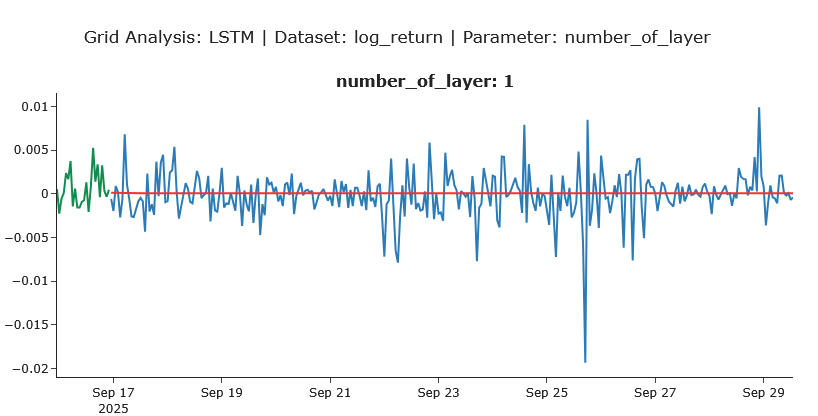

 
- **GRU** : Les comportements sont similaires pour une moitié, l’autre adoptant un caractère oscillatoire qui peut donner l’impression que le modèle parvient à capter quelque chose. Mais en se penchant sur les courbes on remarque qu’il s’agit de la séquence initiale répétée.

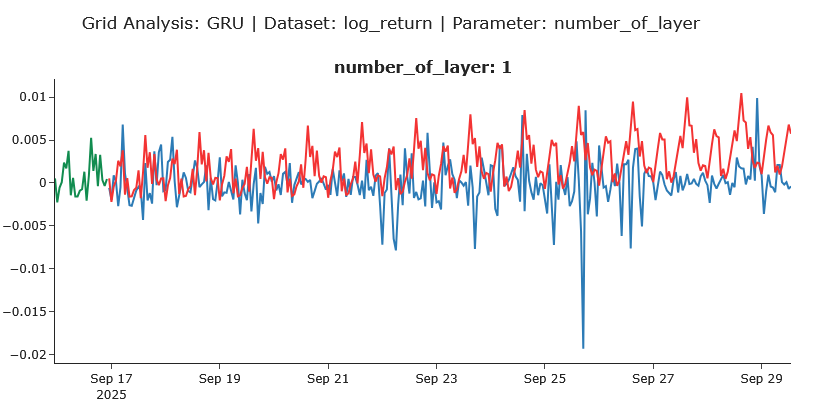

- **SimpleRNN** : C'est ici que l'on trouve la plus grande diversité de comportements, sans pour autant obtenir de résultats probants. Les courbes sont en majorité oscillatoire comme celle vue en GRU, ou bien adoptent des trajectoires "ésotériques" qui ne représente aucune réalité.

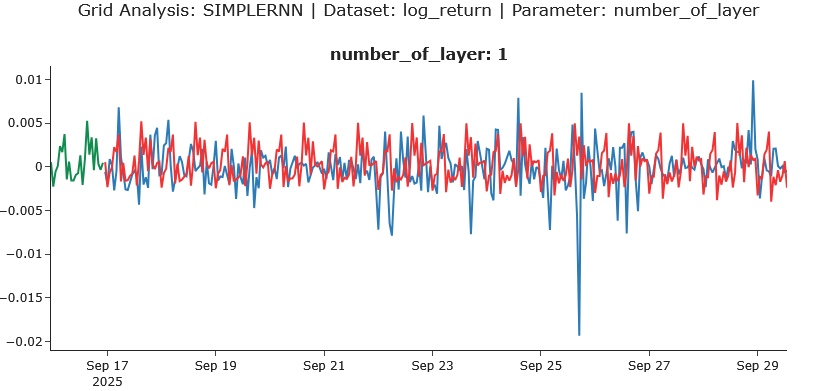
 
Cette tendance suggère que le signal temporel utile est peut-être noyé dans la non-stationnarité des prix bruts. En effet, les séries de prix de cryptomonnaies présentent :

- Une tendance forte et changeante (bull/bear markets),

- Une volatilité hétérogène (calme prolongé suivi de fortes variations),

- Une absence de moyenne stable.

Or, les réseaux récurrents, bien qu’ils possèdent une mémoire temporelle, supposent implicitement que les statistiques locales (moyenne, variance, autocorrélation) restent relativement constantes au cours du temps. Quand ce n’est pas le cas, le modèle apprend à minimiser l’erreur en « moyennant » les régimes passés, ce qui produit exactement les courbes plates ou oscillantes que nous observons.
Pour contourner ce problème, une pratique standard en finance consiste à transformer les prix en rendements, c’est-à-dire à se concentrer sur les variations relatives plutôt que sur les niveaux absolus. Parmi les formulations possibles, nous retenons le log-return :

$$l_t = \log \left( \frac{P_t}{P_{t-1}} \right)$$

avec $l_t$​ : Log-rendement à l'instant t.

$P_t$​ : Prix de close actuel.

$P_{t−1}$ : Prix de close de la bougie précédente.

Cette transformation est motivée par trois propriétés essentielles :

- Stationnarité améliorée : Ils offrent une distribution plus stable (moyenne proche de zéro et variance finie), ce qui facilite grandement la convergence des gradients.
- Additivité temporelle : Le rendement total sur périodes devient la simple somme des log-rendements de chaque période, simplifiant la manipulation mathématique par rapport aux rendements simples.
- Symétrie mathématique : contrairement aux rendements simples, les log-returns traitent les hausses et baisses de façon équilibrée (une hausse de +x suivie d’une baisse de –x ramène exactement au point de départ).
Malgré cette transformation les résultats, restent insatisfaisants :

- Les modèles LSTM persistent à produire des droites centrée sur zéro.
 
- Les GRU et SimpleRNN continuent de générer des motifs basé sur la séquence initiale, oscillant autour d’une moyenne.

En conclusion, même après stationnarisation, aucun modèle ne parvient à capturer une dynamique prédictive exploitable. Ce résultat démontre que l'approche univariée, limitée aux seuls prix passés, est insuffisante pour extraire un signal prédictif exploitable sur le BTC/USDT. Le modèle se contente d’apprendre une tendance de fond ou une moyenne, ce qui confirme que la complexité du marché ne peut être capturée par une approche univariée : d’autres variables ou une architecture fondamentalement différente sont nécessaires.

Cette question sera approfondie dans l’article 5, qui posera les jalons pour la suite des actions.




In [ ]:
# Log-Return Grid Search Experimentation Script.
# --- Configuration & Search Space ---

date = datetime.datetime.now().strftime("%Y_%m_%d")
model_list = ["lstm", "gru", "simplernn"]

search_space = {
    "input_width": [12, 24, 48, 72, 96],
    "batch_size": [16, 32, 64, 128],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1],
    "model_units": [10, 50, 100, 200],
    "dropout_rate": [0, 0.2, 0.5, 0.8],
    "number_of_layer": [1, 2, 3, 4],
    "loss_function": ['mae', 'mse', 'huber'],
}

base_config = {
    "input_width": 24,
    "batch_size": 32,
    "epochs": 50,
    "learning_rate": 0.001,
    "model_units": 50,
    "dense_units": 1,
    "dropout_rate": 0.2,
    "number_of_layer": 1,
    "loss_function": 'mae',
    "train_ratio": 0.7,
    "val_ratio": 0.25,
    'optimizer_name': 'adam',
}

# --- Experiment Loop ---

for model_type in model_list:
    for param_name, values in search_space.items():
        # Set experiment scope per model/parameter combination
        experiment_name = f"log_return_{model_type}_{param_name}_{date}"
        mlflow.set_experiment(experiment_name)

        for value in values:
            print(f"--- Model: {model_type} | Param: {param_name} = {value} ---")
            
            # Memoriy cleanup and seed reset for reproducibility
            tf.keras.backend.clear_session()
            set_seed(42)
            
            # Generate configuration for this specific run         
            run_config = base_config.copy() 
            run_config[param_name] = value
            run_name = f"{param_name}_{value}"

            with mlflow.start_run(run_name=run_name):
                # 1. Logging Metadata
                mlflow.log_params(run_config)
                mlflow.log_param("model_name", model_type)
                mlflow.log_param("studied_parameter", param_name)

                # 2. Data Preparation
                df_raw = pd.read_csv('../data/dataset/BTCUSDT_1h.csv')
                df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'], unit='ms')
                df_raw.set_index('timestamp', inplace=True)
                df_2025= df_raw[df_raw.index.year == 2025][['close']].sort_index()
                
                # Filter and transform to Log Returns (Stationarity)
                df_2025['close'] = np.log(df['close']).diff()
                df_2025 = df_2025.dropna()

                df_train, df_val, df_test, train_gen, val_gen, test_gen, scaler = (
                    split_and_generate_dataset(
                        df_2025,
                        input_width=run_config['input_width'],
                        batch_size=run_config['batch_size'],
                    )
                )
                
                # 3. Model Architecture Construction
                input_shape = (run_config['input_width'], 1)
                layer_config = []
                
                for i in range(run_config['number_of_layer']):
                    layer_config.append({
                        'type' : model_type,
                        'units': run_config['model_units'],
                        'return_sequences': True if i < run_config['number_of_layer'] - 1 else False
                    })
                    layer_config.append({
                        'type' : 'dropout',
                        'rate': run_config['dropout_rate']
                    })
                
                layer_config.append({
                    'type' : 'dense',
                    'units': run_config['dense_units']
                    })
                    
                mg = ModelGenerator(input_shape=input_shape)
                model = mg.build_model(
                    layers_config=layer_config,
                    optimizer_name=run_config['optimizer_name'],
                    optimizer_config={'learning_rate': run_config['learning_rate']},
                    loss=run_config['loss_function'],
                    metrics=['mae', RootMeanSquaredError()]
                )
                
                # 4. Training with Early Stopping
                early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                history = mg.train(train_gen, val_gen, epochs=run_config['epochs'], callbacks=[early_stop])

                # 5. Log Training Metrics
                mlflow.log_metrics({
                    "final_train_loss": history.history['loss'][-1],
                    "final_val_loss": history.history['val_loss'][-1],
                    "final_val_mae": history.history['val_mae'][-1],
                    "final_val_rmse": history.history['val_root_mean_squared_error'][-1],
                })

                mlflow.keras.log_model(mg.model, name="model")
                mlflow.sklearn.log_model(scaler, name="scaler")

                # 6. Walk-Forward Prediction & Plotting
                predictions_wf, y_true_wf, df_init, future_index = run_walkforward_prediction(
                    df_test=df_test,
                    model=mg.model,
                    scaler=scaler,
                    input_width=run_config['input_width']
                )

                if predictions_wf is not None:
                    # Data consolidation for visualization
                    plot_df = pd.DataFrame({
                        'Date': future_index,
                        'Real values': y_true_wf,
                        'Predictions': predictions_wf
                    }).melt(id_vars='Date', var_name='Type', value_name='Valeur')

                    initial_df = pd.DataFrame({
                        'Date': df_init.index,
                        'Valeur': df_init['close'].values, 
                        'Type': 'Initial sequence'
                    })

                    full_plot_df = pd.concat([initial_df, plot_df], ignore_index=True)
                    
                    # Export data and log artifacts
                    dir_path = f"data/{date}/log_return/{model_type}"
                    os.makedirs(dir_path, exist_ok=True)
                    full_plot_df.to_csv(f"{dir_path}/{run_name}.csv", index=False)
                    
                    fig2 = px.line(
                        full_plot_df, x='Date', y='Valeur', color='Type',
                        title=f'WF Pred: {model_type.upper()} | {param_name}={value}',
                        template='simple_white', color_discrete_map=custom_colors
                    )

                    plot_path = f"plot_{model_type}_{run_name}.html"
                    plot(fig2, filename=plot_path, auto_open=False)
                    mlflow.log_artifact(plot_path)
                    if os.path.exists(plot_path): os.remove(plot_path)

print("MLflow grid search cycle complete.")

2026/01/15 20:48:36 INFO mlflow.tracking.fluent: Experiment with name 'log_return_lstm_input_width_2026_01_15' does not exist. Creating a new experiment.


--- Model: lstm | Param: input_width = 12 ---
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0811 - mae: 0.0811 - root_mean_squared_error: 0.1258 - val_loss: 0.0276 - val_mae: 0.0276 - val_root_mean_squared_error: 0.0381
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0483 - mae: 0.0483 - root_mean_squared_error: 0.0658 - val_loss: 0.0251 - val_mae: 0.0251 - val_root_mean_squared_error: 0.0358
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0458 - mae: 0.0458 - root_mean_squared_error: 0.0630 - val_loss: 0.0239 - val_mae: 0.0239 - val_root_mean_squared_error: 0.0346
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0446 - mae: 0.0446 - root_mean_squared_error: 0.0623 - val_loss: 0.0270 - val_mae: 0.0270 - val_root_mean_squared_error: 0.0375
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0429 - mae: 0.0429 - root_mean_squared_error: 0.0604 - val_loss: 0.0251 - val_mae: 0.0251 - val_root_mean_squared_error: 0.0357
Epoc

2026/01/15 20:49:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:49:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:49:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:49:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: input_width = 24 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0791 - mae: 0.0791 - root_mean_squared_error: 0.1224 - val_loss: 0.0277 - val_mae: 0.0277 - val_root_mean_squared_error: 0.0386
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0498 - mae: 0.0498 - root_mean_squared_error: 0.0675 - val_loss: 0.0241 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0355
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0466 - mae: 0.0466 - root_mean_squared_error: 0.0649 - val_loss: 0.0268 - val_mae: 0.0268 - val_root_mean_squared_error: 0.0378
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0453 - mae: 0.0453 - root_mean_squared_error: 0.0627 - val_loss: 0.0267 - val_mae: 0.0267 - val_root_mean_squared_error: 0.0376
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0444 - mae: 0.0444 - root_mean_squared_error: 0.0625 - val_loss: 0.0238 - val_mae: 0.0238 - val_root_mean_squared_error: 0.0352
Epoc

2026/01/15 20:50:26 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:50:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:50:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:50:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: input_width = 48 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0787 - mae: 0.0787 - root_mean_squared_error: 0.1221 - val_loss: 0.0308 - val_mae: 0.0308 - val_root_mean_squared_error: 0.0412
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0495 - mae: 0.0495 - root_mean_squared_error: 0.0670 - val_loss: 0.0245 - val_mae: 0.0245 - val_root_mean_squared_error: 0.0356
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0467 - mae: 0.0467 - root_mean_squared_error: 0.0646 - val_loss: 0.0330 - val_mae: 0.0330 - val_root_mean_squared_error: 0.0430
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0455 - mae: 0.0455 - root_mean_squared_error: 0.0627 - val_loss: 0.0271 - val_mae: 0.0271 - val_root_mean_squared_error: 0.0380
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0444 - mae: 0.0444 - root_mean_squared_error: 0.0622 - val_loss: 0.0245 - val_mae: 0.0245 - val_root_mean_squared_error: 0.0356

2026/01/15 20:52:25 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:52:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:52:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:52:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: input_width = 72 ---
Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0793 - mae: 0.0793 - root_mean_squared_error: 0.1225 - val_loss: 0.0301 - val_mae: 0.0301 - val_root_mean_squared_error: 0.0405
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0496 - mae: 0.0496 - root_mean_squared_error: 0.0678 - val_loss: 0.0243 - val_mae: 0.0243 - val_root_mean_squared_error: 0.0355
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0470 - mae: 0.0470 - root_mean_squared_error: 0.0647 - val_loss: 0.0242 - val_mae: 0.0242 - val_root_mean_squared_error: 0.0354
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0454 - mae: 0.0454 - root_mean_squared_error: 0.0632 - val_loss: 0.0242 - val_mae: 0.0242 - val_root_mean_squared_error: 0.0353
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0440 - mae: 0.0440 - root_mean_squared_error: 0.0613 - val_loss: 0.0247 - val_mae: 0.0247 - val_root_mean_squared_error: 0.0358

2026/01/15 20:54:50 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:54:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:54:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:55:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: input_width = 96 ---
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0792 - mae: 0.0792 - root_mean_squared_error: 0.1226 - val_loss: 0.0263 - val_mae: 0.0263 - val_root_mean_squared_error: 0.0373
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0492 - mae: 0.0492 - root_mean_squared_error: 0.0671 - val_loss: 0.0275 - val_mae: 0.0275 - val_root_mean_squared_error: 0.0384
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0475 - mae: 0.0475 - root_mean_squared_error: 0.0650 - val_loss: 0.0267 - val_mae: 0.0267 - val_root_mean_squared_error: 0.0377
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0456 - mae: 0.0456 - root_mean_squared_error: 0.0631 - val_loss: 0.0247 - val_mae: 0.0247 - val_root_mean_squared_error: 0.0357
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0441 - mae: 0.0441 - root_mean_squared_error: 0.0622 - val_loss: 0.0247 - val_mae: 0.0247 - val_root_mean_squared_error: 0.0358

2026/01/15 20:56:58 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:57:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:57:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:57:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 20:57:28 INFO mlflow.tracking.fluent: Experiment with name 'log_return_lstm_batch_size_2026_01_15' does not exist. Creating a new experiment.


--- Model: lstm | Param: batch_size = 16 ---
Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0659 - mae: 0.0659 - root_mean_squared_error: 0.1001 - val_loss: 0.0264 - val_mae: 0.0264 - val_root_mean_squared_error: 0.0373
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0475 - mae: 0.0475 - root_mean_squared_error: 0.0659 - val_loss: 0.0239 - val_mae: 0.0239 - val_root_mean_squared_error: 0.0353
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0450 - mae: 0.0450 - root_mean_squared_error: 0.0628 - val_loss: 0.0241 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0353
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0431 - mae: 0.0431 - root_mean_squared_error: 0.0610 - val_loss: 0.0258 - val_mae: 0.0258 - val_root_mean_squared_error: 0.0367
Epoch 5/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0422 - mae: 0.0422 - root_mean_squared_error: 0.0601 - val_loss: 0.0240 - val_mae: 0.0240 - val_root_mean_squared_error: 0.0352
Epoch

2026/01/15 20:58:15 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:58:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:58:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:58:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: batch_size = 32 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0791 - mae: 0.0791 - root_mean_squared_error: 0.1224 - val_loss: 0.0277 - val_mae: 0.0277 - val_root_mean_squared_error: 0.0386
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0498 - mae: 0.0498 - root_mean_squared_error: 0.0675 - val_loss: 0.0241 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0355
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0466 - mae: 0.0466 - root_mean_squared_error: 0.0649 - val_loss: 0.0268 - val_mae: 0.0268 - val_root_mean_squared_error: 0.0378
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0453 - mae: 0.0453 - root_mean_squared_error: 0.0627 - val_loss: 0.0267 - val_mae: 0.0267 - val_root_mean_squared_error: 0.0376
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0444 - mae: 0.0444 - root_mean_squared_error: 0.0625 - val_loss: 0.0238 - val_mae: 0.0238 - val_root_mean_squared_error: 0.0352
Epoch

2026/01/15 20:59:27 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 20:59:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 20:59:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 20:59:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: batch_size = 64 ---
Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1072 - mae: 0.1072 - root_mean_squared_error: 0.1599 - val_loss: 0.0244 - val_mae: 0.0244 - val_root_mean_squared_error: 0.0358
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0516 - mae: 0.0516 - root_mean_squared_error: 0.0702 - val_loss: 0.0265 - val_mae: 0.0265 - val_root_mean_squared_error: 0.0376
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0498 - mae: 0.0498 - root_mean_squared_error: 0.0672 - val_loss: 0.0256 - val_mae: 0.0256 - val_root_mean_squared_error: 0.0367
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0477 - mae: 0.0477 - root_mean_squared_error: 0.0651 - val_loss: 0.0248 - val_mae: 0.0248 - val_root_mean_squared_error: 0.0360
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0464 - mae: 0.0464 - root_mean_squared_error: 0.0645 - val_loss: 0.0268 - val_mae: 0.0268 - val_root_mean_squared_error: 0.0376
Epoch 6/50
71/

2026/01/15 21:00:41 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:00:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:00:49 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:00:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: batch_size = 128 ---
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1518 - mae: 0.1518 - root_mean_squared_error: 0.2097 - val_loss: 0.0324 - val_mae: 0.0324 - val_root_mean_squared_error: 0.0425
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0566 - mae: 0.0566 - root_mean_squared_error: 0.0753 - val_loss: 0.0243 - val_mae: 0.0243 - val_root_mean_squared_error: 0.0358
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0526 - mae: 0.0526 - root_mean_squared_error: 0.0711 - val_loss: 0.0271 - val_mae: 0.0271 - val_root_mean_squared_error: 0.0381
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0512 - mae: 0.0512 - root_mean_squared_error: 0.0693 - val_loss: 0.0241 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0355
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0494 - mae: 0.0494 - root_mean_squared_error: 0.0673 - val_loss: 0.0263 - val_mae: 0.0263 - val_root_mean_squared_error: 0.0374
Epoch 6/5

2026/01/15 21:01:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:01:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:01:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:01:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 21:02:22 INFO mlflow.tracking.fluent: Experiment with name 'log_return_lstm_learning_rate_2026_01_15' does not exist. Creating a new experiment.


--- Model: lstm | Param: learning_rate = 0.0001 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2273 - mae: 0.2273 - root_mean_squared_error: 0.2828 - val_loss: 0.0251 - val_mae: 0.0251 - val_root_mean_squared_error: 0.0362
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0629 - mae: 0.0629 - root_mean_squared_error: 0.0819 - val_loss: 0.0239 - val_mae: 0.0239 - val_root_mean_squared_error: 0.0352
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0573 - mae: 0.0573 - root_mean_squared_error: 0.0769 - val_loss: 0.0249 - val_mae: 0.0249 - val_root_mean_squared_error: 0.0361
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0544 - mae: 0.0544 - root_mean_squared_error: 0.0723 - val_loss: 0.0240 - val_mae: 0.0240 - val_root_mean_squared_error: 0.0353
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0530 - mae: 0.0530 - root_mean_squared_error: 0.0716 - val_loss: 0.0276 - val_mae: 0.0276 - val_root_mean_squared_error: 0.038

2026/01/15 21:02:37 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:02:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:02:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:02:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: learning_rate = 0.001 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0791 - mae: 0.0791 - root_mean_squared_error: 0.1224 - val_loss: 0.0277 - val_mae: 0.0277 - val_root_mean_squared_error: 0.0386
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0498 - mae: 0.0498 - root_mean_squared_error: 0.0675 - val_loss: 0.0241 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0355
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0466 - mae: 0.0466 - root_mean_squared_error: 0.0649 - val_loss: 0.0268 - val_mae: 0.0268 - val_root_mean_squared_error: 0.0378
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0453 - mae: 0.0453 - root_mean_squared_error: 0.0627 - val_loss: 0.0267 - val_mae: 0.0267 - val_root_mean_squared_error: 0.0376
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0444 - mae: 0.0444 - root_mean_squared_error: 0.0625 - val_loss: 0.0238 - val_mae: 0.0238 - val_root_mean_squared_error: 0.0352

2026/01/15 21:03:50 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:03:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:03:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:04:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: learning_rate = 0.01 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0583 - mae: 0.0583 - root_mean_squared_error: 0.0935 - val_loss: 0.0241 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0353
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0403 - mae: 0.0403 - root_mean_squared_error: 0.0582 - val_loss: 0.0237 - val_mae: 0.0237 - val_root_mean_squared_error: 0.0349
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0362 - mae: 0.0362 - root_mean_squared_error: 0.0548 - val_loss: 0.0235 - val_mae: 0.0235 - val_root_mean_squared_error: 0.0347
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0350 - mae: 0.0350 - root_mean_squared_error: 0.0534 - val_loss: 0.0243 - val_mae: 0.0243 - val_root_mean_squared_error: 0.0353
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0347 - mae: 0.0347 - root_mean_squared_error: 0.0532 - val_loss: 0.0238 - val_mae: 0.0238 - val_root_mean_squared_error: 0.0349


2026/01/15 21:04:55 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:05:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:05:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:05:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: learning_rate = 0.1 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0877 - mae: 0.0877 - root_mean_squared_error: 0.4230 - val_loss: 0.0241 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0352
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0360 - mae: 0.0360 - root_mean_squared_error: 0.0549 - val_loss: 0.0242 - val_mae: 0.0242 - val_root_mean_squared_error: 0.0352
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0371 - mae: 0.0371 - root_mean_squared_error: 0.0559 - val_loss: 0.0239 - val_mae: 0.0239 - val_root_mean_squared_error: 0.0350
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0357 - mae: 0.0357 - root_mean_squared_error: 0.0545 - val_loss: 0.0236 - val_mae: 0.0236 - val_root_mean_squared_error: 0.0347
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0361 - mae: 0.0361 - root_mean_squared_error: 0.0547 - val_loss: 0.0246 - val_mae: 0.0246 - val_root_mean_squared_error: 0.0356
E

2026/01/15 21:05:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:05:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:05:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:06:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 21:06:26 INFO mlflow.tracking.fluent: Experiment with name 'log_return_lstm_model_units_2026_01_15' does not exist. Creating a new experiment.


--- Model: lstm | Param: model_units = 10 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0988 - mae: 0.0988 - root_mean_squared_error: 0.1289 - val_loss: 0.0298 - val_mae: 0.0298 - val_root_mean_squared_error: 0.0403
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0717 - mae: 0.0717 - root_mean_squared_error: 0.0930 - val_loss: 0.0240 - val_mae: 0.0240 - val_root_mean_squared_error: 0.0353
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0637 - mae: 0.0637 - root_mean_squared_error: 0.0840 - val_loss: 0.0310 - val_mae: 0.0310 - val_root_mean_squared_error: 0.0413
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0581 - mae: 0.0581 - root_mean_squared_error: 0.0773 - val_loss: 0.0242 - val_mae: 0.0242 - val_root_mean_squared_error: 0.0355
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0525 - mae: 0.0525 - root_mean_squared_error: 0.0708 - val_loss: 0.0245 - val_mae: 0.0245 - val_root_mean_squared_error: 0.0357
Epoc

2026/01/15 21:06:49 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:06:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:06:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:07:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: model_units = 50 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0791 - mae: 0.0791 - root_mean_squared_error: 0.1224 - val_loss: 0.0277 - val_mae: 0.0277 - val_root_mean_squared_error: 0.0386
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0498 - mae: 0.0498 - root_mean_squared_error: 0.0675 - val_loss: 0.0241 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0355
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0466 - mae: 0.0466 - root_mean_squared_error: 0.0649 - val_loss: 0.0268 - val_mae: 0.0268 - val_root_mean_squared_error: 0.0378
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0453 - mae: 0.0453 - root_mean_squared_error: 0.0627 - val_loss: 0.0267 - val_mae: 0.0267 - val_root_mean_squared_error: 0.0376
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0444 - mae: 0.0444 - root_mean_squared_error: 0.0625 - val_loss: 0.0238 - val_mae: 0.0238 - val_root_mean_squared_error: 0.0352
Epoc

2026/01/15 21:08:04 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:08:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:08:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:08:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: model_units = 100 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0649 - mae: 0.0649 - root_mean_squared_error: 0.1073 - val_loss: 0.0244 - val_mae: 0.0244 - val_root_mean_squared_error: 0.0358
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0445 - mae: 0.0445 - root_mean_squared_error: 0.0624 - val_loss: 0.0251 - val_mae: 0.0251 - val_root_mean_squared_error: 0.0362
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0430 - mae: 0.0430 - root_mean_squared_error: 0.0606 - val_loss: 0.0298 - val_mae: 0.0298 - val_root_mean_squared_error: 0.0402
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0420 - mae: 0.0420 - root_mean_squared_error: 0.0594 - val_loss: 0.0253 - val_mae: 0.0253 - val_root_mean_squared_error: 0.0364
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0411 - mae: 0.0411 - root_mean_squared_error: 0.0588 - val_loss: 0.0242 - val_mae: 0.0242 - val_root_mean_squared_error: 0.0354
E

2026/01/15 21:09:50 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:09:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:09:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:10:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: model_units = 200 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0589 - mae: 0.0589 - root_mean_squared_error: 0.0980 - val_loss: 0.0260 - val_mae: 0.0260 - val_root_mean_squared_error: 0.0372
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0419 - mae: 0.0419 - root_mean_squared_error: 0.0601 - val_loss: 0.0264 - val_mae: 0.0264 - val_root_mean_squared_error: 0.0373
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0400 - mae: 0.0400 - root_mean_squared_error: 0.0581 - val_loss: 0.0257 - val_mae: 0.0257 - val_root_mean_squared_error: 0.0368
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0403 - mae: 0.0403 - root_mean_squared_error: 0.0587 - val_loss: 0.0250 - val_mae: 0.0250 - val_root_mean_squared_error: 0.0361
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0395 - mae: 0.0395 - root_mean_squared_error: 0.0579 - val_loss: 0.0284 - val_mae: 0.0284 - val_root_mean_squared_error: 0.038

2026/01/15 21:12:37 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:12:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:12:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:12:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 21:13:22 INFO mlflow.tracking.fluent: Experiment with name 'log_return_lstm_dropout_rate_2026_01_15' does not exist. Creating a new experiment.


--- Model: lstm | Param: dropout_rate = 0 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0612 - mae: 0.0612 - root_mean_squared_error: 0.1137 - val_loss: 0.0243 - val_mae: 0.0243 - val_root_mean_squared_error: 0.0356
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0355 - mae: 0.0355 - root_mean_squared_error: 0.0543 - val_loss: 0.0240 - val_mae: 0.0240 - val_root_mean_squared_error: 0.0353
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0349 - mae: 0.0349 - root_mean_squared_error: 0.0538 - val_loss: 0.0238 - val_mae: 0.0238 - val_root_mean_squared_error: 0.0351
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0352 - mae: 0.0352 - root_mean_squared_error: 0.0540 - val_loss: 0.0245 - val_mae: 0.0245 - val_root_mean_squared_error: 0.0357
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0350 - mae: 0.0350 - root_mean_squared_error: 0.0538 - val_loss: 0.0241 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0354
E

2026/01/15 21:14:21 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:14:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:14:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:14:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: dropout_rate = 0.2 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0791 - mae: 0.0791 - root_mean_squared_error: 0.1224 - val_loss: 0.0277 - val_mae: 0.0277 - val_root_mean_squared_error: 0.0386
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0498 - mae: 0.0498 - root_mean_squared_error: 0.0675 - val_loss: 0.0241 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0355
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0466 - mae: 0.0466 - root_mean_squared_error: 0.0649 - val_loss: 0.0268 - val_mae: 0.0268 - val_root_mean_squared_error: 0.0378
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0453 - mae: 0.0453 - root_mean_squared_error: 0.0627 - val_loss: 0.0267 - val_mae: 0.0267 - val_root_mean_squared_error: 0.0376
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0444 - mae: 0.0444 - root_mean_squared_error: 0.0625 - val_loss: 0.0238 - val_mae: 0.0238 - val_root_mean_squared_error: 0.0352
Ep

2026/01/15 21:15:41 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:15:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:15:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:15:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: dropout_rate = 0.5 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1033 - mae: 0.1033 - root_mean_squared_error: 0.1445 - val_loss: 0.0358 - val_mae: 0.0358 - val_root_mean_squared_error: 0.0456
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0669 - mae: 0.0669 - root_mean_squared_error: 0.0866 - val_loss: 0.0246 - val_mae: 0.0246 - val_root_mean_squared_error: 0.0360
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0610 - mae: 0.0610 - root_mean_squared_error: 0.0802 - val_loss: 0.0250 - val_mae: 0.0250 - val_root_mean_squared_error: 0.0362
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0566 - mae: 0.0566 - root_mean_squared_error: 0.0751 - val_loss: 0.0253 - val_mae: 0.0253 - val_root_mean_squared_error: 0.0363
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0520 - mae: 0.0520 - root_mean_squared_error: 0.0702 - val_loss: 0.0245 - val_mae: 0.0245 - val_root_mean_squared_error: 0.0357
Ep

2026/01/15 21:16:54 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:17:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:17:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:17:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: dropout_rate = 0.8 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1530 - mae: 0.1530 - root_mean_squared_error: 0.1990 - val_loss: 0.0503 - val_mae: 0.0503 - val_root_mean_squared_error: 0.0584
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1000 - mae: 0.1000 - root_mean_squared_error: 0.1269 - val_loss: 0.0306 - val_mae: 0.0306 - val_root_mean_squared_error: 0.0409
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0812 - mae: 0.0812 - root_mean_squared_error: 0.1031 - val_loss: 0.0324 - val_mae: 0.0324 - val_root_mean_squared_error: 0.0424
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0646 - mae: 0.0646 - root_mean_squared_error: 0.0843 - val_loss: 0.0240 - val_mae: 0.0240 - val_root_mean_squared_error: 0.0352
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0511 - mae: 0.0511 - root_mean_squared_error: 0.0689 - val_loss: 0.0238 - val_mae: 0.0238 - val_root_mean_squared_error: 0.0350
Ep

2026/01/15 21:18:07 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:18:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:18:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:18:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 21:18:50 INFO mlflow.tracking.fluent: Experiment with name 'log_return_lstm_number_of_layer_2026_01_15' does not exist. Creating a new experiment.


--- Model: lstm | Param: number_of_layer = 1 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0791 - mae: 0.0791 - root_mean_squared_error: 0.1224 - val_loss: 0.0277 - val_mae: 0.0277 - val_root_mean_squared_error: 0.0386
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0498 - mae: 0.0498 - root_mean_squared_error: 0.0675 - val_loss: 0.0241 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0355
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0466 - mae: 0.0466 - root_mean_squared_error: 0.0649 - val_loss: 0.0268 - val_mae: 0.0268 - val_root_mean_squared_error: 0.0378
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0453 - mae: 0.0453 - root_mean_squared_error: 0.0627 - val_loss: 0.0267 - val_mae: 0.0267 - val_root_mean_squared_error: 0.0376
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0444 - mae: 0.0444 - root_mean_squared_error: 0.0625 - val_loss: 0.0238 - val_mae: 0.0238 - val_root_mean_squared_error: 0.0352
E

2026/01/15 21:19:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:19:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:19:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:19:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: number_of_layer = 2 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0729 - mae: 0.0729 - root_mean_squared_error: 0.1115 - val_loss: 0.0257 - val_mae: 0.0257 - val_root_mean_squared_error: 0.0367
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0498 - mae: 0.0498 - root_mean_squared_error: 0.0674 - val_loss: 0.0296 - val_mae: 0.0296 - val_root_mean_squared_error: 0.0400
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0473 - mae: 0.0473 - root_mean_squared_error: 0.0649 - val_loss: 0.0259 - val_mae: 0.0259 - val_root_mean_squared_error: 0.0368
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0449 - mae: 0.0449 - root_mean_squared_error: 0.0626 - val_loss: 0.0246 - val_mae: 0.0246 - val_root_mean_squared_error: 0.0357
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0440 - mae: 0.0440 - root_mean_squared_error: 0.0620 - val_loss: 0.0261 - val_mae: 0.0261 - val_root_mean_squared_error: 0.0

2026/01/15 21:21:21 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:21:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:21:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:21:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: number_of_layer = 3 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0667 - mae: 0.0667 - root_mean_squared_error: 0.1009 - val_loss: 0.0259 - val_mae: 0.0259 - val_root_mean_squared_error: 0.0368
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0500 - mae: 0.0500 - root_mean_squared_error: 0.0677 - val_loss: 0.0275 - val_mae: 0.0275 - val_root_mean_squared_error: 0.0379
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0462 - mae: 0.0462 - root_mean_squared_error: 0.0633 - val_loss: 0.0279 - val_mae: 0.0279 - val_root_mean_squared_error: 0.0383
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0462 - mae: 0.0462 - root_mean_squared_error: 0.0639 - val_loss: 0.0249 - val_mae: 0.0249 - val_root_mean_squared_error: 0.0359
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0440 - mae: 0.0440 - root_mean_squared_error: 0.0614 - val_loss: 0.0238 - val_mae: 0.0238 - val_root_mean_squared_error: 0.0

2026/01/15 21:23:12 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:23:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:23:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:23:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: number_of_layer = 4 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0758 - mae: 0.0758 - root_mean_squared_error: 0.1175 - val_loss: 0.0249 - val_mae: 0.0249 - val_root_mean_squared_error: 0.0357
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0503 - mae: 0.0503 - root_mean_squared_error: 0.0681 - val_loss: 0.0306 - val_mae: 0.0306 - val_root_mean_squared_error: 0.0406
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0478 - mae: 0.0478 - root_mean_squared_error: 0.0660 - val_loss: 0.0288 - val_mae: 0.0288 - val_root_mean_squared_error: 0.0391
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0448 - mae: 0.0448 - root_mean_squared_error: 0.0622 - val_loss: 0.0249 - val_mae: 0.0249 - val_root_mean_squared_error: 0.0358
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0451 - mae: 0.0451 - root_mean_squared_error: 0.0626 - val_loss: 0.0234 - val_mae: 0.0234 - val_root_mean_squared_error: 0.0

2026/01/15 21:24:49 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:24:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:24:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:25:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 21:25:31 INFO mlflow.tracking.fluent: Experiment with name 'log_return_lstm_loss_function_2026_01_15' does not exist. Creating a new experiment.


--- Model: lstm | Param: loss_function = mae ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0791 - mae: 0.0791 - root_mean_squared_error: 0.1224 - val_loss: 0.0277 - val_mae: 0.0277 - val_root_mean_squared_error: 0.0386
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0498 - mae: 0.0498 - root_mean_squared_error: 0.0675 - val_loss: 0.0241 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0355
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0466 - mae: 0.0466 - root_mean_squared_error: 0.0649 - val_loss: 0.0268 - val_mae: 0.0268 - val_root_mean_squared_error: 0.0378
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0453 - mae: 0.0453 - root_mean_squared_error: 0.0627 - val_loss: 0.0267 - val_mae: 0.0267 - val_root_mean_squared_error: 0.0376
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0444 - mae: 0.0444 - root_mean_squared_error: 0.0625 - val_loss: 0.0238 - val_mae: 0.0238 - val_root_mean_squared_error: 0.0352
E

2026/01/15 21:26:10 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:26:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:26:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:26:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: loss_function = mse ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0159 - mae: 0.0829 - root_mean_squared_error: 0.1259 - val_loss: 0.0013 - val_mae: 0.0252 - val_root_mean_squared_error: 0.0365
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0048 - mae: 0.0517 - root_mean_squared_error: 0.0695 - val_loss: 0.0013 - val_mae: 0.0242 - val_root_mean_squared_error: 0.0356
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0045 - mae: 0.0489 - root_mean_squared_error: 0.0673 - val_loss: 0.0013 - val_mae: 0.0251 - val_root_mean_squared_error: 0.0363
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - mae: 0.0470 - root_mean_squared_error: 0.0644 - val_loss: 0.0013 - val_mae: 0.0251 - val_root_mean_squared_error: 0.0363
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - mae: 0.0466 - root_mean_squared_error: 0.0647 - val_loss: 0.0012 - val_mae: 0.0239 - val_root_mean_squared_error: 0.0353
E

2026/01/15 21:27:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:27:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:27:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:27:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: lstm | Param: loss_function = huber ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0079 - mae: 0.0830 - root_mean_squared_error: 0.1260 - val_loss: 6.6501e-04 - val_mae: 0.0252 - val_root_mean_squared_error: 0.0365
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - mae: 0.0517 - root_mean_squared_error: 0.0695 - val_loss: 6.3370e-04 - val_mae: 0.0242 - val_root_mean_squared_error: 0.0356
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023 - mae: 0.0489 - root_mean_squared_error: 0.0673 - val_loss: 6.6032e-04 - val_mae: 0.0251 - val_root_mean_squared_error: 0.0363
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - mae: 0.0470 - root_mean_squared_error: 0.0644 - val_loss: 6.6000e-04 - val_mae: 0.0251 - val_root_mean_squared_error: 0.0363
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - mae: 0.0466 - root_mean_squared_error: 0.0647 - val_loss: 6.2283e-04 - val_mae: 0.0239 - val_root_mean_s

2026/01/15 21:29:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:29:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:29:32 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:29:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 21:30:05 INFO mlflow.tracking.fluent: Experiment with name 'log_return_gru_input_width_2026_01_15' does not exist. Creating a new experiment.


--- Model: gru | Param: input_width = 12 ---
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0815 - mae: 0.0815 - root_mean_squared_error: 0.1257 - val_loss: 0.0280 - val_mae: 0.0280 - val_root_mean_squared_error: 0.0387
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0484 - mae: 0.0484 - root_mean_squared_error: 0.0664 - val_loss: 0.0244 - val_mae: 0.0244 - val_root_mean_squared_error: 0.0353
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0458 - mae: 0.0458 - root_mean_squared_error: 0.0633 - val_loss: 0.0241 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0350
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0448 - mae: 0.0448 - root_mean_squared_error: 0.0626 - val_loss: 0.0294 - val_mae: 0.0294 - val_root_mean_squared_error: 0.0397
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0429 - mae: 0.0429 - root_mean_squared_error: 0.0606 - val_loss: 0.0240 - val_mae: 0.0240 - val_root_mean_squared_error: 0.0349
Epoch

2026/01/15 21:30:50 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:30:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:30:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:31:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: input_width = 24 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0823 - mae: 0.0823 - root_mean_squared_error: 0.1266 - val_loss: 0.0266 - val_mae: 0.0266 - val_root_mean_squared_error: 0.0377
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0492 - mae: 0.0492 - root_mean_squared_error: 0.0670 - val_loss: 0.0246 - val_mae: 0.0246 - val_root_mean_squared_error: 0.0359
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0468 - mae: 0.0468 - root_mean_squared_error: 0.0651 - val_loss: 0.0301 - val_mae: 0.0301 - val_root_mean_squared_error: 0.0404
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0455 - mae: 0.0455 - root_mean_squared_error: 0.0628 - val_loss: 0.0259 - val_mae: 0.0259 - val_root_mean_squared_error: 0.0369
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0444 - mae: 0.0444 - root_mean_squared_error: 0.0625 - val_loss: 0.0237 - val_mae: 0.0237 - val_root_mean_squared_error: 0.0350
Epoch

2026/01/15 21:32:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:32:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:32:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:32:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: input_width = 48 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0825 - mae: 0.0825 - root_mean_squared_error: 0.1267 - val_loss: 0.0282 - val_mae: 0.0282 - val_root_mean_squared_error: 0.0391
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0491 - mae: 0.0491 - root_mean_squared_error: 0.0665 - val_loss: 0.0276 - val_mae: 0.0276 - val_root_mean_squared_error: 0.0385
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0463 - mae: 0.0463 - root_mean_squared_error: 0.0645 - val_loss: 0.0283 - val_mae: 0.0283 - val_root_mean_squared_error: 0.0390
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0456 - mae: 0.0456 - root_mean_squared_error: 0.0630 - val_loss: 0.0283 - val_mae: 0.0283 - val_root_mean_squared_error: 0.0390
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0447 - mae: 0.0447 - root_mean_squared_error: 0.0626 - val_loss: 0.0247 - val_mae: 0.0247 - val_root_mean_squared_error: 0.0358


2026/01/15 21:34:49 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:34:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:34:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:35:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: input_width = 72 ---
Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0825 - mae: 0.0825 - root_mean_squared_error: 0.1267 - val_loss: 0.0284 - val_mae: 0.0284 - val_root_mean_squared_error: 0.0391
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0490 - mae: 0.0490 - root_mean_squared_error: 0.0673 - val_loss: 0.0247 - val_mae: 0.0247 - val_root_mean_squared_error: 0.0357
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0464 - mae: 0.0464 - root_mean_squared_error: 0.0641 - val_loss: 0.0243 - val_mae: 0.0243 - val_root_mean_squared_error: 0.0354
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0452 - mae: 0.0452 - root_mean_squared_error: 0.0630 - val_loss: 0.0241 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0353
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0439 - mae: 0.0439 - root_mean_squared_error: 0.0611 - val_loss: 0.0245 - val_mae: 0.0245 - val_root_mean_squared_error: 0.0356


2026/01/15 21:37:29 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:37:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:37:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:37:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: input_width = 96 ---
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0829 - mae: 0.0829 - root_mean_squared_error: 0.1271 - val_loss: 0.0249 - val_mae: 0.0249 - val_root_mean_squared_error: 0.0361
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0488 - mae: 0.0488 - root_mean_squared_error: 0.0668 - val_loss: 0.0247 - val_mae: 0.0247 - val_root_mean_squared_error: 0.0358
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0467 - mae: 0.0467 - root_mean_squared_error: 0.0643 - val_loss: 0.0248 - val_mae: 0.0248 - val_root_mean_squared_error: 0.0359
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0461 - mae: 0.0461 - root_mean_squared_error: 0.0635 - val_loss: 0.0258 - val_mae: 0.0258 - val_root_mean_squared_error: 0.0367
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0442 - mae: 0.0442 - root_mean_squared_error: 0.0623 - val_loss: 0.0248 - val_mae: 0.0248 - val_root_mean_squared_error: 0.0359


2026/01/15 21:40:01 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:40:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:40:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:40:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 21:40:37 INFO mlflow.tracking.fluent: Experiment with name 'log_return_gru_batch_size_2026_01_15' does not exist. Creating a new experiment.


--- Model: gru | Param: batch_size = 16 ---
Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0663 - mae: 0.0663 - root_mean_squared_error: 0.1019 - val_loss: 0.0250 - val_mae: 0.0250 - val_root_mean_squared_error: 0.0362
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0472 - mae: 0.0472 - root_mean_squared_error: 0.0652 - val_loss: 0.0239 - val_mae: 0.0239 - val_root_mean_squared_error: 0.0352
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0453 - mae: 0.0453 - root_mean_squared_error: 0.0630 - val_loss: 0.0242 - val_mae: 0.0242 - val_root_mean_squared_error: 0.0355
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0432 - mae: 0.0432 - root_mean_squared_error: 0.0609 - val_loss: 0.0254 - val_mae: 0.0254 - val_root_mean_squared_error: 0.0363
Epoch 5/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0425 - mae: 0.0425 - root_mean_squared_error: 0.0604 - val_loss: 0.0247 - val_mae: 0.0247 - val_root_mean_squared_error: 0.0357
Epoch 

2026/01/15 21:42:28 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:42:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:42:37 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:42:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: batch_size = 32 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0823 - mae: 0.0823 - root_mean_squared_error: 0.1266 - val_loss: 0.0266 - val_mae: 0.0266 - val_root_mean_squared_error: 0.0377
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0492 - mae: 0.0492 - root_mean_squared_error: 0.0670 - val_loss: 0.0246 - val_mae: 0.0246 - val_root_mean_squared_error: 0.0359
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0468 - mae: 0.0468 - root_mean_squared_error: 0.0651 - val_loss: 0.0301 - val_mae: 0.0301 - val_root_mean_squared_error: 0.0404
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0455 - mae: 0.0455 - root_mean_squared_error: 0.0628 - val_loss: 0.0259 - val_mae: 0.0259 - val_root_mean_squared_error: 0.0369
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0444 - mae: 0.0444 - root_mean_squared_error: 0.0625 - val_loss: 0.0237 - val_mae: 0.0237 - val_root_mean_squared_error: 0.0350
Epoch

2026/01/15 21:44:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:44:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:44:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:44:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: batch_size = 64 ---
Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1088 - mae: 0.1088 - root_mean_squared_error: 0.1628 - val_loss: 0.0246 - val_mae: 0.0246 - val_root_mean_squared_error: 0.0360
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0522 - mae: 0.0522 - root_mean_squared_error: 0.0710 - val_loss: 0.0263 - val_mae: 0.0263 - val_root_mean_squared_error: 0.0374
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0494 - mae: 0.0494 - root_mean_squared_error: 0.0670 - val_loss: 0.0244 - val_mae: 0.0244 - val_root_mean_squared_error: 0.0357
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0471 - mae: 0.0471 - root_mean_squared_error: 0.0649 - val_loss: 0.0245 - val_mae: 0.0245 - val_root_mean_squared_error: 0.0357
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0459 - mae: 0.0459 - root_mean_squared_error: 0.0639 - val_loss: 0.0276 - val_mae: 0.0276 - val_root_mean_squared_error: 0.0382
Epoch 6/50


2026/01/15 21:46:20 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:46:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:46:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:46:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: batch_size = 128 ---
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1581 - mae: 0.1581 - root_mean_squared_error: 0.2162 - val_loss: 0.0345 - val_mae: 0.0345 - val_root_mean_squared_error: 0.0444
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0586 - mae: 0.0586 - root_mean_squared_error: 0.0779 - val_loss: 0.0246 - val_mae: 0.0246 - val_root_mean_squared_error: 0.0359
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0540 - mae: 0.0540 - root_mean_squared_error: 0.0728 - val_loss: 0.0246 - val_mae: 0.0246 - val_root_mean_squared_error: 0.0359
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0519 - mae: 0.0519 - root_mean_squared_error: 0.0701 - val_loss: 0.0251 - val_mae: 0.0251 - val_root_mean_squared_error: 0.0364
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0487 - mae: 0.0487 - root_mean_squared_error: 0.0667 - val_loss: 0.0248 - val_mae: 0.0248 - val_root_mean_squared_error: 0.0361
Epoch 6/50

2026/01/15 21:48:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:48:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:48:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:48:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 21:48:53 INFO mlflow.tracking.fluent: Experiment with name 'log_return_gru_learning_rate_2026_01_15' does not exist. Creating a new experiment.


--- Model: gru | Param: learning_rate = 0.0001 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2585 - mae: 0.2585 - root_mean_squared_error: 0.3030 - val_loss: 0.0249 - val_mae: 0.0249 - val_root_mean_squared_error: 0.0362
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0635 - mae: 0.0635 - root_mean_squared_error: 0.0829 - val_loss: 0.0247 - val_mae: 0.0247 - val_root_mean_squared_error: 0.0360
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0597 - mae: 0.0597 - root_mean_squared_error: 0.0799 - val_loss: 0.0262 - val_mae: 0.0262 - val_root_mean_squared_error: 0.0374
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0568 - mae: 0.0568 - root_mean_squared_error: 0.0752 - val_loss: 0.0260 - val_mae: 0.0260 - val_root_mean_squared_error: 0.0372
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0557 - mae: 0.0557 - root_mean_squared_error: 0.0745 - val_loss: 0.0250 - val_mae: 0.0250 - val_root_mean_squared_error: 0.036

2026/01/15 21:50:01 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:50:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:50:10 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:50:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: learning_rate = 0.001 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0823 - mae: 0.0823 - root_mean_squared_error: 0.1266 - val_loss: 0.0266 - val_mae: 0.0266 - val_root_mean_squared_error: 0.0377
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0492 - mae: 0.0492 - root_mean_squared_error: 0.0670 - val_loss: 0.0246 - val_mae: 0.0246 - val_root_mean_squared_error: 0.0359
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0468 - mae: 0.0468 - root_mean_squared_error: 0.0651 - val_loss: 0.0301 - val_mae: 0.0301 - val_root_mean_squared_error: 0.0404
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0455 - mae: 0.0455 - root_mean_squared_error: 0.0628 - val_loss: 0.0259 - val_mae: 0.0259 - val_root_mean_squared_error: 0.0369
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0444 - mae: 0.0444 - root_mean_squared_error: 0.0625 - val_loss: 0.0237 - val_mae: 0.0237 - val_root_mean_squared_error: 0.0350

2026/01/15 21:52:04 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:52:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:52:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:52:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: learning_rate = 0.01 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0586 - mae: 0.0586 - root_mean_squared_error: 0.0882 - val_loss: 0.0234 - val_mae: 0.0234 - val_root_mean_squared_error: 0.0346
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0422 - mae: 0.0422 - root_mean_squared_error: 0.0598 - val_loss: 0.0232 - val_mae: 0.0232 - val_root_mean_squared_error: 0.0343
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0368 - mae: 0.0368 - root_mean_squared_error: 0.0550 - val_loss: 0.0231 - val_mae: 0.0231 - val_root_mean_squared_error: 0.0341
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0347 - mae: 0.0347 - root_mean_squared_error: 0.0528 - val_loss: 0.0230 - val_mae: 0.0230 - val_root_mean_squared_error: 0.0340
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0338 - mae: 0.0338 - root_mean_squared_error: 0.0521 - val_loss: 0.0233 - val_mae: 0.0233 - val_root_mean_squared_error: 0.0340


2026/01/15 21:53:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:54:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:54:17 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:54:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: learning_rate = 0.1 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1264 - mae: 0.1264 - root_mean_squared_error: 0.4389 - val_loss: 0.0254 - val_mae: 0.0254 - val_root_mean_squared_error: 0.0355
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0463 - mae: 0.0463 - root_mean_squared_error: 0.0662 - val_loss: 0.0213 - val_mae: 0.0213 - val_root_mean_squared_error: 0.0314
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0335 - mae: 0.0335 - root_mean_squared_error: 0.0473 - val_loss: 0.0266 - val_mae: 0.0266 - val_root_mean_squared_error: 0.0297
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0391 - mae: 0.0391 - root_mean_squared_error: 0.0524 - val_loss: 0.0574 - val_mae: 0.0574 - val_root_mean_squared_error: 0.0600
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0329 - mae: 0.0329 - root_mean_squared_error: 0.0448 - val_loss: 0.0317 - val_mae: 0.0317 - val_root_mean_squared_error: 0.0332
E

2026/01/15 21:55:42 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:55:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:55:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:55:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 21:56:33 INFO mlflow.tracking.fluent: Experiment with name 'log_return_gru_model_units_2026_01_15' does not exist. Creating a new experiment.


--- Model: gru | Param: model_units = 10 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1113 - mae: 0.1113 - root_mean_squared_error: 0.1437 - val_loss: 0.0311 - val_mae: 0.0311 - val_root_mean_squared_error: 0.0417
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0745 - mae: 0.0745 - root_mean_squared_error: 0.0967 - val_loss: 0.0250 - val_mae: 0.0250 - val_root_mean_squared_error: 0.0363
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0647 - mae: 0.0647 - root_mean_squared_error: 0.0851 - val_loss: 0.0308 - val_mae: 0.0308 - val_root_mean_squared_error: 0.0412
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0585 - mae: 0.0585 - root_mean_squared_error: 0.0779 - val_loss: 0.0251 - val_mae: 0.0251 - val_root_mean_squared_error: 0.0363
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0528 - mae: 0.0528 - root_mean_squared_error: 0.0711 - val_loss: 0.0245 - val_mae: 0.0245 - val_root_mean_squared_error: 0.0358
Epoch

2026/01/15 21:57:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:57:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:57:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:57:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: model_units = 50 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0823 - mae: 0.0823 - root_mean_squared_error: 0.1266 - val_loss: 0.0266 - val_mae: 0.0266 - val_root_mean_squared_error: 0.0377
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0492 - mae: 0.0492 - root_mean_squared_error: 0.0670 - val_loss: 0.0246 - val_mae: 0.0246 - val_root_mean_squared_error: 0.0359
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0468 - mae: 0.0468 - root_mean_squared_error: 0.0651 - val_loss: 0.0301 - val_mae: 0.0301 - val_root_mean_squared_error: 0.0404
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0455 - mae: 0.0455 - root_mean_squared_error: 0.0628 - val_loss: 0.0259 - val_mae: 0.0259 - val_root_mean_squared_error: 0.0369
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0444 - mae: 0.0444 - root_mean_squared_error: 0.0625 - val_loss: 0.0237 - val_mae: 0.0237 - val_root_mean_squared_error: 0.0350
Epoc

2026/01/15 21:59:29 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 21:59:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 21:59:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 21:59:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: model_units = 100 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0694 - mae: 0.0694 - root_mean_squared_error: 0.1149 - val_loss: 0.0246 - val_mae: 0.0246 - val_root_mean_squared_error: 0.0359
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0441 - mae: 0.0441 - root_mean_squared_error: 0.0622 - val_loss: 0.0240 - val_mae: 0.0240 - val_root_mean_squared_error: 0.0354
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0422 - mae: 0.0422 - root_mean_squared_error: 0.0599 - val_loss: 0.0267 - val_mae: 0.0267 - val_root_mean_squared_error: 0.0376
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0414 - mae: 0.0414 - root_mean_squared_error: 0.0588 - val_loss: 0.0248 - val_mae: 0.0248 - val_root_mean_squared_error: 0.0359
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0404 - mae: 0.0404 - root_mean_squared_error: 0.0580 - val_loss: 0.0275 - val_mae: 0.0275 - val_root_mean_squared_error: 0.0381

2026/01/15 22:01:45 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:01:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:01:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:01:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: model_units = 200 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0586 - mae: 0.0586 - root_mean_squared_error: 0.0995 - val_loss: 0.0246 - val_mae: 0.0246 - val_root_mean_squared_error: 0.0359
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0412 - mae: 0.0412 - root_mean_squared_error: 0.0595 - val_loss: 0.0258 - val_mae: 0.0258 - val_root_mean_squared_error: 0.0368
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0395 - mae: 0.0395 - root_mean_squared_error: 0.0577 - val_loss: 0.0237 - val_mae: 0.0237 - val_root_mean_squared_error: 0.0350
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0395 - mae: 0.0395 - root_mean_squared_error: 0.0577 - val_loss: 0.0255 - val_mae: 0.0255 - val_root_mean_squared_error: 0.0364
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0399 - mae: 0.0399 - root_mean_squared_error: 0.0580 - val_loss: 0.0235 - val_mae: 0.0235 - val_root_mean_squared_error: 0.0347

2026/01/15 22:04:26 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:04:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:04:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:04:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 22:05:20 INFO mlflow.tracking.fluent: Experiment with name 'log_return_gru_dropout_rate_2026_01_15' does not exist. Creating a new experiment.


--- Model: gru | Param: dropout_rate = 0 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0668 - mae: 0.0668 - root_mean_squared_error: 0.1217 - val_loss: 0.0252 - val_mae: 0.0252 - val_root_mean_squared_error: 0.0364
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0354 - mae: 0.0354 - root_mean_squared_error: 0.0544 - val_loss: 0.0240 - val_mae: 0.0240 - val_root_mean_squared_error: 0.0353
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0347 - mae: 0.0347 - root_mean_squared_error: 0.0536 - val_loss: 0.0237 - val_mae: 0.0237 - val_root_mean_squared_error: 0.0350
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0344 - mae: 0.0344 - root_mean_squared_error: 0.0532 - val_loss: 0.0236 - val_mae: 0.0236 - val_root_mean_squared_error: 0.0349
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0346 - mae: 0.0346 - root_mean_squared_error: 0.0533 - val_loss: 0.0237 - val_mae: 0.0237 - val_root_mean_squared_error: 0.0350
Epoc

2026/01/15 22:06:26 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:06:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:06:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:06:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: dropout_rate = 0.2 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0823 - mae: 0.0823 - root_mean_squared_error: 0.1266 - val_loss: 0.0266 - val_mae: 0.0266 - val_root_mean_squared_error: 0.0377
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0492 - mae: 0.0492 - root_mean_squared_error: 0.0670 - val_loss: 0.0246 - val_mae: 0.0246 - val_root_mean_squared_error: 0.0359
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0468 - mae: 0.0468 - root_mean_squared_error: 0.0651 - val_loss: 0.0301 - val_mae: 0.0301 - val_root_mean_squared_error: 0.0404
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0455 - mae: 0.0455 - root_mean_squared_error: 0.0628 - val_loss: 0.0259 - val_mae: 0.0259 - val_root_mean_squared_error: 0.0369
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0444 - mae: 0.0444 - root_mean_squared_error: 0.0625 - val_loss: 0.0237 - val_mae: 0.0237 - val_root_mean_squared_error: 0.0350
Ep

2026/01/15 22:08:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:08:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:08:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:08:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: dropout_rate = 0.5 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1064 - mae: 0.1064 - root_mean_squared_error: 0.1490 - val_loss: 0.0340 - val_mae: 0.0340 - val_root_mean_squared_error: 0.0440
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0666 - mae: 0.0666 - root_mean_squared_error: 0.0864 - val_loss: 0.0242 - val_mae: 0.0242 - val_root_mean_squared_error: 0.0356
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0618 - mae: 0.0618 - root_mean_squared_error: 0.0811 - val_loss: 0.0243 - val_mae: 0.0243 - val_root_mean_squared_error: 0.0356
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0573 - mae: 0.0573 - root_mean_squared_error: 0.0760 - val_loss: 0.0253 - val_mae: 0.0253 - val_root_mean_squared_error: 0.0363
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0525 - mae: 0.0525 - root_mean_squared_error: 0.0707 - val_loss: 0.0241 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0354
Ep

2026/01/15 22:09:59 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:10:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:10:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:10:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: dropout_rate = 0.8 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1542 - mae: 0.1542 - root_mean_squared_error: 0.2019 - val_loss: 0.0455 - val_mae: 0.0455 - val_root_mean_squared_error: 0.0543
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0997 - mae: 0.0997 - root_mean_squared_error: 0.1265 - val_loss: 0.0268 - val_mae: 0.0268 - val_root_mean_squared_error: 0.0377
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0817 - mae: 0.0817 - root_mean_squared_error: 0.1039 - val_loss: 0.0327 - val_mae: 0.0327 - val_root_mean_squared_error: 0.0427
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0650 - mae: 0.0650 - root_mean_squared_error: 0.0848 - val_loss: 0.0240 - val_mae: 0.0240 - val_root_mean_squared_error: 0.0352
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0512 - mae: 0.0512 - root_mean_squared_error: 0.0693 - val_loss: 0.0240 - val_mae: 0.0240 - val_root_mean_squared_error: 0.0352
Ep

2026/01/15 22:11:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:11:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:11:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:11:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 22:12:20 INFO mlflow.tracking.fluent: Experiment with name 'log_return_gru_number_of_layer_2026_01_15' does not exist. Creating a new experiment.


--- Model: gru | Param: number_of_layer = 1 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0823 - mae: 0.0823 - root_mean_squared_error: 0.1266 - val_loss: 0.0266 - val_mae: 0.0266 - val_root_mean_squared_error: 0.0377
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0492 - mae: 0.0492 - root_mean_squared_error: 0.0670 - val_loss: 0.0246 - val_mae: 0.0246 - val_root_mean_squared_error: 0.0359
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0468 - mae: 0.0468 - root_mean_squared_error: 0.0651 - val_loss: 0.0301 - val_mae: 0.0301 - val_root_mean_squared_error: 0.0404
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0455 - mae: 0.0455 - root_mean_squared_error: 0.0628 - val_loss: 0.0259 - val_mae: 0.0259 - val_root_mean_squared_error: 0.0369
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0444 - mae: 0.0444 - root_mean_squared_error: 0.0625 - val_loss: 0.0237 - val_mae: 0.0237 - val_root_mean_squared_error: 0.0350
E

2026/01/15 22:13:26 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:13:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:13:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:13:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: number_of_layer = 2 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0652 - mae: 0.0652 - root_mean_squared_error: 0.0896 - val_loss: 0.0259 - val_mae: 0.0259 - val_root_mean_squared_error: 0.0371
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0512 - mae: 0.0512 - root_mean_squared_error: 0.0695 - val_loss: 0.0245 - val_mae: 0.0245 - val_root_mean_squared_error: 0.0358
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0472 - mae: 0.0472 - root_mean_squared_error: 0.0650 - val_loss: 0.0248 - val_mae: 0.0248 - val_root_mean_squared_error: 0.0360
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0454 - mae: 0.0454 - root_mean_squared_error: 0.0631 - val_loss: 0.0241 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0353
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0441 - mae: 0.0441 - root_mean_squared_error: 0.0622 - val_loss: 0.0276 - val_mae: 0.0276 - val_root_mean_squared_error: 0.03

2026/01/15 22:15:39 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:15:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:15:49 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:15:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: number_of_layer = 3 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0671 - mae: 0.0671 - root_mean_squared_error: 0.0975 - val_loss: 0.0242 - val_mae: 0.0242 - val_root_mean_squared_error: 0.0355
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0495 - mae: 0.0495 - root_mean_squared_error: 0.0672 - val_loss: 0.0238 - val_mae: 0.0238 - val_root_mean_squared_error: 0.0350
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0467 - mae: 0.0467 - root_mean_squared_error: 0.0638 - val_loss: 0.0279 - val_mae: 0.0279 - val_root_mean_squared_error: 0.0384
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0456 - mae: 0.0456 - root_mean_squared_error: 0.0632 - val_loss: 0.0236 - val_mae: 0.0236 - val_root_mean_squared_error: 0.0348
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0437 - mae: 0.0437 - root_mean_squared_error: 0.0613 - val_loss: 0.0260 - val_mae: 0.0260 - val_root_mean_squared_error: 0.03

2026/01/15 22:17:27 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:17:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:17:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:17:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: number_of_layer = 4 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0712 - mae: 0.0712 - root_mean_squared_error: 0.1064 - val_loss: 0.0357 - val_mae: 0.0357 - val_root_mean_squared_error: 0.0453
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0505 - mae: 0.0505 - root_mean_squared_error: 0.0684 - val_loss: 0.0235 - val_mae: 0.0235 - val_root_mean_squared_error: 0.0347
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0466 - mae: 0.0466 - root_mean_squared_error: 0.0647 - val_loss: 0.0237 - val_mae: 0.0237 - val_root_mean_squared_error: 0.0349
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0439 - mae: 0.0439 - root_mean_squared_error: 0.0613 - val_loss: 0.0248 - val_mae: 0.0248 - val_root_mean_squared_error: 0.0357
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0449 - mae: 0.0449 - root_mean_squared_error: 0.0622 - val_loss: 0.0235 - val_mae: 0.0235 - val_root_mean_squared_error: 0.0

2026/01/15 22:19:19 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:19:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:19:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:19:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 22:20:22 INFO mlflow.tracking.fluent: Experiment with name 'log_return_gru_loss_function_2026_01_15' does not exist. Creating a new experiment.


--- Model: gru | Param: loss_function = mae ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0823 - mae: 0.0823 - root_mean_squared_error: 0.1266 - val_loss: 0.0266 - val_mae: 0.0266 - val_root_mean_squared_error: 0.0377
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0492 - mae: 0.0492 - root_mean_squared_error: 0.0670 - val_loss: 0.0246 - val_mae: 0.0246 - val_root_mean_squared_error: 0.0359
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0468 - mae: 0.0468 - root_mean_squared_error: 0.0651 - val_loss: 0.0301 - val_mae: 0.0301 - val_root_mean_squared_error: 0.0404
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0455 - mae: 0.0455 - root_mean_squared_error: 0.0628 - val_loss: 0.0259 - val_mae: 0.0259 - val_root_mean_squared_error: 0.0369
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0444 - mae: 0.0444 - root_mean_squared_error: 0.0625 - val_loss: 0.0237 - val_mae: 0.0237 - val_root_mean_squared_error: 0.0350
E

2026/01/15 22:21:33 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:21:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:21:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:21:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: loss_function = mse ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0169 - mae: 0.0868 - root_mean_squared_error: 0.1299 - val_loss: 0.0013 - val_mae: 0.0255 - val_root_mean_squared_error: 0.0367
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - mae: 0.0525 - root_mean_squared_error: 0.0706 - val_loss: 0.0013 - val_mae: 0.0243 - val_root_mean_squared_error: 0.0356
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - mae: 0.0489 - root_mean_squared_error: 0.0674 - val_loss: 0.0013 - val_mae: 0.0241 - val_root_mean_squared_error: 0.0355
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - mae: 0.0468 - root_mean_squared_error: 0.0642 - val_loss: 0.0013 - val_mae: 0.0240 - val_root_mean_squared_error: 0.0354
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - mae: 0.0464 - root_mean_squared_error: 0.0645 - val_loss: 0.0012 - val_mae: 0.0237 - val_root_mean_squared_error: 0.0351
E

2026/01/15 22:23:38 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:23:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:23:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:23:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: gru | Param: loss_function = huber ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0084 - mae: 0.0868 - root_mean_squared_error: 0.1299 - val_loss: 6.7524e-04 - val_mae: 0.0255 - val_root_mean_squared_error: 0.0367
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mae: 0.0525 - root_mean_squared_error: 0.0706 - val_loss: 6.3580e-04 - val_mae: 0.0243 - val_root_mean_squared_error: 0.0357
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mae: 0.0489 - root_mean_squared_error: 0.0674 - val_loss: 6.3001e-04 - val_mae: 0.0242 - val_root_mean_squared_error: 0.0355
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - mae: 0.0469 - root_mean_squared_error: 0.0642 - val_loss: 6.2596e-04 - val_mae: 0.0240 - val_root_mean_squared_error: 0.0354
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - mae: 0.0465 - root_mean_squared_error: 0.0645 - val_loss: 6.1657e-04 - val_mae: 0.0238 - val_root_mean_s

2026/01/15 22:25:43 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:25:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:25:53 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:25:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 22:26:42 INFO mlflow.tracking.fluent: Experiment with name 'log_return_simplernn_input_width_2026_01_15' does not exist. Creating a new experiment.


--- Model: simplernn | Param: input_width = 12 ---
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0591 - mae: 0.0591 - root_mean_squared_error: 0.0822 - val_loss: 0.0330 - val_mae: 0.0330 - val_root_mean_squared_error: 0.0355
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0407 - mae: 0.0407 - root_mean_squared_error: 0.0520 - val_loss: 0.0066 - val_mae: 0.0066 - val_root_mean_squared_error: 0.0089
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0349 - mae: 0.0349 - root_mean_squared_error: 0.0447 - val_loss: 0.0125 - val_mae: 0.0125 - val_root_mean_squared_error: 0.0135
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0334 - mae: 0.0334 - root_mean_squared_error: 0.0426 - val_loss: 0.0044 - val_mae: 0.0044 - val_root_mean_squared_error: 0.0061
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0298 - mae: 0.0298 - root_mean_squared_error: 0.0382 - val_loss: 0.0178 - val_mae: 0.0178 - val_root_mean_squared_error: 0.0188

2026/01/15 22:27:19 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:27:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:27:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:27:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: input_width = 24 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0664 - mae: 0.0664 - root_mean_squared_error: 0.0907 - val_loss: 0.0172 - val_mae: 0.0172 - val_root_mean_squared_error: 0.0233
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0449 - mae: 0.0449 - root_mean_squared_error: 0.0587 - val_loss: 0.0125 - val_mae: 0.0125 - val_root_mean_squared_error: 0.0173
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0388 - mae: 0.0388 - root_mean_squared_error: 0.0505 - val_loss: 0.0210 - val_mae: 0.0210 - val_root_mean_squared_error: 0.0239
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0352 - mae: 0.0352 - root_mean_squared_error: 0.0449 - val_loss: 0.0295 - val_mae: 0.0295 - val_root_mean_squared_error: 0.0312
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0331 - mae: 0.0331 - root_mean_squared_error: 0.0424 - val_loss: 0.0139 - val_mae: 0.0139 - val_root_mean_squared_error: 0.0159

2026/01/15 22:29:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:29:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:29:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:29:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: input_width = 48 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0737 - mae: 0.0737 - root_mean_squared_error: 0.0986 - val_loss: 0.0356 - val_mae: 0.0356 - val_root_mean_squared_error: 0.0426
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0527 - mae: 0.0527 - root_mean_squared_error: 0.0677 - val_loss: 0.0202 - val_mae: 0.0202 - val_root_mean_squared_error: 0.0261
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0454 - mae: 0.0454 - root_mean_squared_error: 0.0591 - val_loss: 0.0434 - val_mae: 0.0434 - val_root_mean_squared_error: 0.0486
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0447 - mae: 0.0447 - root_mean_squared_error: 0.0586 - val_loss: 0.0149 - val_mae: 0.0149 - val_root_mean_squared_error: 0.0200
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0395 - mae: 0.0395 - root_mean_squared_error: 0.0516 - val_loss: 0.0147 - val_mae: 0.0147 - val_root_mean_squared_error: 0.0191

2026/01/15 22:30:55 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:31:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:31:04 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:31:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: input_width = 72 ---
Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0786 - mae: 0.0786 - root_mean_squared_error: 0.1056 - val_loss: 0.0356 - val_mae: 0.0356 - val_root_mean_squared_error: 0.0448
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0598 - mae: 0.0598 - root_mean_squared_error: 0.0785 - val_loss: 0.0248 - val_mae: 0.0248 - val_root_mean_squared_error: 0.0343
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0521 - mae: 0.0521 - root_mean_squared_error: 0.0695 - val_loss: 0.0235 - val_mae: 0.0235 - val_root_mean_squared_error: 0.0321
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0476 - mae: 0.0476 - root_mean_squared_error: 0.0636 - val_loss: 0.0263 - val_mae: 0.0263 - val_root_mean_squared_error: 0.0342
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0459 - mae: 0.0459 - root_mean_squared_error: 0.0615 - val_loss: 0.0264 - val_mae: 0.0264 - val_root_mean_squared_error: 0.034

2026/01/15 22:32:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:33:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:33:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:33:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: input_width = 96 ---
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0823 - mae: 0.0823 - root_mean_squared_error: 0.1094 - val_loss: 0.0287 - val_mae: 0.0287 - val_root_mean_squared_error: 0.0394
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0614 - mae: 0.0614 - root_mean_squared_error: 0.0811 - val_loss: 0.0269 - val_mae: 0.0269 - val_root_mean_squared_error: 0.0378
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0551 - mae: 0.0551 - root_mean_squared_error: 0.0734 - val_loss: 0.0249 - val_mae: 0.0249 - val_root_mean_squared_error: 0.0352
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0497 - mae: 0.0497 - root_mean_squared_error: 0.0675 - val_loss: 0.0270 - val_mae: 0.0270 - val_root_mean_squared_error: 0.0377
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0484 - mae: 0.0484 - root_mean_squared_error: 0.0665 - val_loss: 0.0259 - val_mae: 0.0259 - val_root_mean_squared_error: 0.036

2026/01/15 22:34:19 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:34:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:34:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:34:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 22:35:09 INFO mlflow.tracking.fluent: Experiment with name 'log_return_simplernn_batch_size_2026_01_15' does not exist. Creating a new experiment.


--- Model: simplernn | Param: batch_size = 16 ---
Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0607 - mae: 0.0607 - root_mean_squared_error: 0.0825 - val_loss: 0.0227 - val_mae: 0.0227 - val_root_mean_squared_error: 0.0271
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0416 - mae: 0.0416 - root_mean_squared_error: 0.0542 - val_loss: 0.0100 - val_mae: 0.0100 - val_root_mean_squared_error: 0.0138
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0358 - mae: 0.0358 - root_mean_squared_error: 0.0458 - val_loss: 0.0177 - val_mae: 0.0177 - val_root_mean_squared_error: 0.0207
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0318 - mae: 0.0318 - root_mean_squared_error: 0.0405 - val_loss: 0.0154 - val_mae: 0.0154 - val_root_mean_squared_error: 0.0187
Epoch 5/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0306 - mae: 0.0306 - root_mean_squared_error: 0.0388 - val_loss: 0.0119 - val_mae: 0.0119 - val_root_mean_squared_error: 0.0147


2026/01/15 22:35:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:35:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:35:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:36:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: batch_size = 32 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0664 - mae: 0.0664 - root_mean_squared_error: 0.0907 - val_loss: 0.0172 - val_mae: 0.0172 - val_root_mean_squared_error: 0.0233
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0449 - mae: 0.0449 - root_mean_squared_error: 0.0587 - val_loss: 0.0125 - val_mae: 0.0125 - val_root_mean_squared_error: 0.0173
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0388 - mae: 0.0388 - root_mean_squared_error: 0.0505 - val_loss: 0.0210 - val_mae: 0.0210 - val_root_mean_squared_error: 0.0239
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0352 - mae: 0.0352 - root_mean_squared_error: 0.0449 - val_loss: 0.0295 - val_mae: 0.0295 - val_root_mean_squared_error: 0.0312
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0331 - mae: 0.0331 - root_mean_squared_error: 0.0424 - val_loss: 0.0139 - val_mae: 0.0139 - val_root_mean_squared_error: 0.0159


2026/01/15 22:37:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:37:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:37:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:37:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: batch_size = 64 ---
Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0805 - mae: 0.0805 - root_mean_squared_error: 0.1104 - val_loss: 0.0237 - val_mae: 0.0237 - val_root_mean_squared_error: 0.0306
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0489 - mae: 0.0489 - root_mean_squared_error: 0.0639 - val_loss: 0.0206 - val_mae: 0.0206 - val_root_mean_squared_error: 0.0259
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0436 - mae: 0.0436 - root_mean_squared_error: 0.0562 - val_loss: 0.0131 - val_mae: 0.0131 - val_root_mean_squared_error: 0.0173
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0400 - mae: 0.0400 - root_mean_squared_error: 0.0520 - val_loss: 0.0120 - val_mae: 0.0120 - val_root_mean_squared_error: 0.0156
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0380 - mae: 0.0380 - root_mean_squared_error: 0.0485 - val_loss: 0.0094 - val_mae: 0.0094 - val_root_mean_squared_error: 0.0128
Epoch 6/5

2026/01/15 22:38:46 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:38:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:38:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:38:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: batch_size = 128 ---
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0954 - mae: 0.0954 - root_mean_squared_error: 0.1296 - val_loss: 0.0279 - val_mae: 0.0279 - val_root_mean_squared_error: 0.0372
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0541 - mae: 0.0541 - root_mean_squared_error: 0.0713 - val_loss: 0.0198 - val_mae: 0.0198 - val_root_mean_squared_error: 0.0268
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0509 - mae: 0.0509 - root_mean_squared_error: 0.0658 - val_loss: 0.0347 - val_mae: 0.0347 - val_root_mean_squared_error: 0.0398
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0454 - mae: 0.0454 - root_mean_squared_error: 0.0592 - val_loss: 0.0145 - val_mae: 0.0145 - val_root_mean_squared_error: 0.0199
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0435 - mae: 0.0435 - root_mean_squared_error: 0.0561 - val_loss: 0.0146 - val_mae: 0.0146 - val_root_mean_squared_error: 0.0193
Epoc

2026/01/15 22:40:12 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:40:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:40:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:40:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 22:41:10 INFO mlflow.tracking.fluent: Experiment with name 'log_return_simplernn_learning_rate_2026_01_15' does not exist. Creating a new experiment.


--- Model: simplernn | Param: learning_rate = 0.0001 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0932 - mae: 0.0932 - root_mean_squared_error: 0.1227 - val_loss: 0.0314 - val_mae: 0.0314 - val_root_mean_squared_error: 0.0427
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0652 - mae: 0.0652 - root_mean_squared_error: 0.0867 - val_loss: 0.0257 - val_mae: 0.0257 - val_root_mean_squared_error: 0.0346
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0581 - mae: 0.0581 - root_mean_squared_error: 0.0767 - val_loss: 0.0256 - val_mae: 0.0256 - val_root_mean_squared_error: 0.0337
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0532 - mae: 0.0532 - root_mean_squared_error: 0.0703 - val_loss: 0.0230 - val_mae: 0.0230 - val_root_mean_squared_error: 0.0303
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0509 - mae: 0.0509 - root_mean_squared_error: 0.0660 - val_loss: 0.0181 - val_mae: 0.0181 - val_root_mean_squared_error: 

2026/01/15 22:41:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:41:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:41:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:42:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: learning_rate = 0.001 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0664 - mae: 0.0664 - root_mean_squared_error: 0.0907 - val_loss: 0.0172 - val_mae: 0.0172 - val_root_mean_squared_error: 0.0233
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0449 - mae: 0.0449 - root_mean_squared_error: 0.0587 - val_loss: 0.0125 - val_mae: 0.0125 - val_root_mean_squared_error: 0.0173
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0388 - mae: 0.0388 - root_mean_squared_error: 0.0505 - val_loss: 0.0210 - val_mae: 0.0210 - val_root_mean_squared_error: 0.0239
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0352 - mae: 0.0352 - root_mean_squared_error: 0.0449 - val_loss: 0.0295 - val_mae: 0.0295 - val_root_mean_squared_error: 0.0312
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0331 - mae: 0.0331 - root_mean_squared_error: 0.0424 - val_loss: 0.0139 - val_mae: 0.0139 - val_root_mean_squared_error: 0

2026/01/15 22:43:28 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:43:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:43:37 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:43:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: learning_rate = 0.01 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0678 - mae: 0.0678 - root_mean_squared_error: 0.1149 - val_loss: 0.0265 - val_mae: 0.0265 - val_root_mean_squared_error: 0.0321
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0350 - mae: 0.0350 - root_mean_squared_error: 0.0465 - val_loss: 0.0155 - val_mae: 0.0155 - val_root_mean_squared_error: 0.0209
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0256 - mae: 0.0256 - root_mean_squared_error: 0.0360 - val_loss: 0.0087 - val_mae: 0.0087 - val_root_mean_squared_error: 0.0114
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0208 - mae: 0.0208 - root_mean_squared_error: 0.0295 - val_loss: 0.0098 - val_mae: 0.0098 - val_root_mean_squared_error: 0.0134
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0191 - mae: 0.0191 - root_mean_squared_error: 0.0277 - val_loss: 0.0120 - val_mae: 0.0120 - val_root_mean_squared_error: 0.

2026/01/15 22:44:37 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:44:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:44:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:44:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: learning_rate = 0.1 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7134 - mae: 0.7134 - root_mean_squared_error: 1.1684 - val_loss: 0.2779 - val_mae: 0.2779 - val_root_mean_squared_error: 0.2800
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3876 - mae: 0.3876 - root_mean_squared_error: 0.5297 - val_loss: 0.9483 - val_mae: 0.9483 - val_root_mean_squared_error: 0.9489
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5362 - mae: 0.5362 - root_mean_squared_error: 0.6749 - val_loss: 0.2183 - val_mae: 0.2183 - val_root_mean_squared_error: 0.2210
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3896 - mae: 0.3896 - root_mean_squared_error: 0.5359 - val_loss: 0.0579 - val_mae: 0.0579 - val_root_mean_squared_error: 0.0653
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4114 - mae: 0.4114 - root_mean_squared_error: 0.5403 - val_loss: 0.2844 - val_mae: 0.2844 - val_root_mean_squared_error: 0.2

2026/01/15 22:45:51 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:45:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:46:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:46:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 22:46:47 INFO mlflow.tracking.fluent: Experiment with name 'log_return_simplernn_model_units_2026_01_15' does not exist. Creating a new experiment.


--- Model: simplernn | Param: model_units = 10 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1444 - mae: 0.1444 - root_mean_squared_error: 0.2005 - val_loss: 0.0450 - val_mae: 0.0450 - val_root_mean_squared_error: 0.0594
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0876 - mae: 0.0876 - root_mean_squared_error: 0.1168 - val_loss: 0.0374 - val_mae: 0.0374 - val_root_mean_squared_error: 0.0483
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0742 - mae: 0.0742 - root_mean_squared_error: 0.0995 - val_loss: 0.0281 - val_mae: 0.0281 - val_root_mean_squared_error: 0.0385
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0637 - mae: 0.0637 - root_mean_squared_error: 0.0853 - val_loss: 0.0283 - val_mae: 0.0283 - val_root_mean_squared_error: 0.0381
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0551 - mae: 0.0551 - root_mean_squared_error: 0.0756 - val_loss: 0.0249 - val_mae: 0.0249 - val_root_mean_squared_error: 0.0348

2026/01/15 22:47:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:47:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:47:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:47:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: model_units = 50 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0664 - mae: 0.0664 - root_mean_squared_error: 0.0907 - val_loss: 0.0172 - val_mae: 0.0172 - val_root_mean_squared_error: 0.0233
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0449 - mae: 0.0449 - root_mean_squared_error: 0.0587 - val_loss: 0.0125 - val_mae: 0.0125 - val_root_mean_squared_error: 0.0173
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0388 - mae: 0.0388 - root_mean_squared_error: 0.0505 - val_loss: 0.0210 - val_mae: 0.0210 - val_root_mean_squared_error: 0.0239
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0352 - mae: 0.0352 - root_mean_squared_error: 0.0449 - val_loss: 0.0295 - val_mae: 0.0295 - val_root_mean_squared_error: 0.0312
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0331 - mae: 0.0331 - root_mean_squared_error: 0.0424 - val_loss: 0.0139 - val_mae: 0.0139 - val_root_mean_squared_error: 0.0159

2026/01/15 22:49:09 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:49:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:49:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:49:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: model_units = 100 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0601 - mae: 0.0601 - root_mean_squared_error: 0.0967 - val_loss: 0.0073 - val_mae: 0.0073 - val_root_mean_squared_error: 0.0098
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0354 - mae: 0.0354 - root_mean_squared_error: 0.0450 - val_loss: 0.0174 - val_mae: 0.0174 - val_root_mean_squared_error: 0.0191
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0308 - mae: 0.0308 - root_mean_squared_error: 0.0392 - val_loss: 0.0173 - val_mae: 0.0173 - val_root_mean_squared_error: 0.0187
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0303 - mae: 0.0303 - root_mean_squared_error: 0.0381 - val_loss: 0.0247 - val_mae: 0.0247 - val_root_mean_squared_error: 0.0265
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0271 - mae: 0.0271 - root_mean_squared_error: 0.0347 - val_loss: 0.0063 - val_mae: 0.0063 - val_root_mean_squared_error: 0.008

2026/01/15 22:50:41 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:50:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:50:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:50:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: model_units = 200 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0550 - mae: 0.0550 - root_mean_squared_error: 0.1064 - val_loss: 0.0064 - val_mae: 0.0064 - val_root_mean_squared_error: 0.0087
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0290 - mae: 0.0290 - root_mean_squared_error: 0.0369 - val_loss: 0.0308 - val_mae: 0.0308 - val_root_mean_squared_error: 0.0327
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0272 - mae: 0.0272 - root_mean_squared_error: 0.0344 - val_loss: 0.0174 - val_mae: 0.0174 - val_root_mean_squared_error: 0.0202
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0273 - mae: 0.0273 - root_mean_squared_error: 0.0346 - val_loss: 0.0192 - val_mae: 0.0192 - val_root_mean_squared_error: 0.0209
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0226 - mae: 0.0226 - root_mean_squared_error: 0.0287 - val_loss: 0.0193 - val_mae: 0.0193 - val_root_mean_squared_error: 0.020

2026/01/15 22:52:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:52:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:52:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:52:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 22:53:12 INFO mlflow.tracking.fluent: Experiment with name 'log_return_simplernn_dropout_rate_2026_01_15' does not exist. Creating a new experiment.


--- Model: simplernn | Param: dropout_rate = 0 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0467 - mae: 0.0467 - root_mean_squared_error: 0.1008 - val_loss: 0.0094 - val_mae: 0.0094 - val_root_mean_squared_error: 0.0130
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0167 - mae: 0.0167 - root_mean_squared_error: 0.0225 - val_loss: 0.0060 - val_mae: 0.0060 - val_root_mean_squared_error: 0.0084
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0140 - mae: 0.0140 - root_mean_squared_error: 0.0188 - val_loss: 0.0119 - val_mae: 0.0119 - val_root_mean_squared_error: 0.0131
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0151 - mae: 0.0151 - root_mean_squared_error: 0.0197 - val_loss: 0.0293 - val_mae: 0.0293 - val_root_mean_squared_error: 0.0304
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0120 - mae: 0.0120 - root_mean_squared_error: 0.0163 - val_loss: 0.0054 - val_mae: 0.0054 - val_root_mean_squared_error: 0.0064

2026/01/15 22:53:46 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:53:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:53:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:53:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: dropout_rate = 0.2 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0664 - mae: 0.0664 - root_mean_squared_error: 0.0907 - val_loss: 0.0172 - val_mae: 0.0172 - val_root_mean_squared_error: 0.0233
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0449 - mae: 0.0449 - root_mean_squared_error: 0.0587 - val_loss: 0.0125 - val_mae: 0.0125 - val_root_mean_squared_error: 0.0173
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0388 - mae: 0.0388 - root_mean_squared_error: 0.0505 - val_loss: 0.0210 - val_mae: 0.0210 - val_root_mean_squared_error: 0.0239
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0352 - mae: 0.0352 - root_mean_squared_error: 0.0449 - val_loss: 0.0295 - val_mae: 0.0295 - val_root_mean_squared_error: 0.0312
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0331 - mae: 0.0331 - root_mean_squared_error: 0.0424 - val_loss: 0.0139 - val_mae: 0.0139 - val_root_mean_squared_error: 0.01

2026/01/15 22:55:27 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:55:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:55:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:55:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: dropout_rate = 0.5 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1042 - mae: 0.1042 - root_mean_squared_error: 0.1397 - val_loss: 0.0231 - val_mae: 0.0231 - val_root_mean_squared_error: 0.0302
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0735 - mae: 0.0735 - root_mean_squared_error: 0.0945 - val_loss: 0.0193 - val_mae: 0.0193 - val_root_mean_squared_error: 0.0257
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0623 - mae: 0.0623 - root_mean_squared_error: 0.0792 - val_loss: 0.0232 - val_mae: 0.0232 - val_root_mean_squared_error: 0.0284
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0542 - mae: 0.0542 - root_mean_squared_error: 0.0698 - val_loss: 0.0212 - val_mae: 0.0212 - val_root_mean_squared_error: 0.0263
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0480 - mae: 0.0480 - root_mean_squared_error: 0.0618 - val_loss: 0.0124 - val_mae: 0.0124 - val_root_mean_squared_error: 0.01

2026/01/15 22:56:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:57:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:57:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:57:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: dropout_rate = 0.8 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1707 - mae: 0.1707 - root_mean_squared_error: 0.2263 - val_loss: 0.0518 - val_mae: 0.0518 - val_root_mean_squared_error: 0.0589
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1126 - mae: 0.1126 - root_mean_squared_error: 0.1436 - val_loss: 0.0208 - val_mae: 0.0208 - val_root_mean_squared_error: 0.0280
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0858 - mae: 0.0858 - root_mean_squared_error: 0.1092 - val_loss: 0.0420 - val_mae: 0.0420 - val_root_mean_squared_error: 0.0486
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0636 - mae: 0.0636 - root_mean_squared_error: 0.0834 - val_loss: 0.0179 - val_mae: 0.0179 - val_root_mean_squared_error: 0.0261
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0496 - mae: 0.0496 - root_mean_squared_error: 0.0660 - val_loss: 0.0175 - val_mae: 0.0175 - val_root_mean_squared_error: 0.02

2026/01/15 22:58:28 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 22:58:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 22:58:37 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 22:58:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 22:59:28 INFO mlflow.tracking.fluent: Experiment with name 'log_return_simplernn_number_of_layer_2026_01_15' does not exist. Creating a new experiment.


--- Model: simplernn | Param: number_of_layer = 1 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0664 - mae: 0.0664 - root_mean_squared_error: 0.0907 - val_loss: 0.0172 - val_mae: 0.0172 - val_root_mean_squared_error: 0.0233
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0449 - mae: 0.0449 - root_mean_squared_error: 0.0587 - val_loss: 0.0125 - val_mae: 0.0125 - val_root_mean_squared_error: 0.0173
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0388 - mae: 0.0388 - root_mean_squared_error: 0.0505 - val_loss: 0.0210 - val_mae: 0.0210 - val_root_mean_squared_error: 0.0239
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0352 - mae: 0.0352 - root_mean_squared_error: 0.0449 - val_loss: 0.0295 - val_mae: 0.0295 - val_root_mean_squared_error: 0.0312
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0331 - mae: 0.0331 - root_mean_squared_error: 0.0424 - val_loss: 0.0139 - val_mae: 0.0139 - val_root_mean_squared_error: 0.0

2026/01/15 23:00:10 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 23:00:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 23:00:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 23:00:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: number_of_layer = 2 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1588 - mae: 0.1588 - root_mean_squared_error: 0.2218 - val_loss: 0.0148 - val_mae: 0.0148 - val_root_mean_squared_error: 0.0207
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0766 - mae: 0.0766 - root_mean_squared_error: 0.0991 - val_loss: 0.0286 - val_mae: 0.0286 - val_root_mean_squared_error: 0.0316
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0612 - mae: 0.0612 - root_mean_squared_error: 0.0791 - val_loss: 0.0239 - val_mae: 0.0239 - val_root_mean_squared_error: 0.0270
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0489 - mae: 0.0489 - root_mean_squared_error: 0.0621 - val_loss: 0.0195 - val_mae: 0.0195 - val_root_mean_squared_error: 0.0233
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0427 - mae: 0.0427 - root_mean_squared_error: 0.0548 - val_loss: 0.0088 - val_mae: 0.0088 - val_root_mean_squared_error: 0.

2026/01/15 23:02:07 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 23:02:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 23:02:16 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 23:02:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: number_of_layer = 3 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.3296 - mae: 0.3296 - root_mean_squared_error: 0.4325 - val_loss: 0.0711 - val_mae: 0.0711 - val_root_mean_squared_error: 0.0770
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1504 - mae: 0.1504 - root_mean_squared_error: 0.1929 - val_loss: 0.0730 - val_mae: 0.0730 - val_root_mean_squared_error: 0.0765
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0973 - mae: 0.0973 - root_mean_squared_error: 0.1249 - val_loss: 0.0261 - val_mae: 0.0261 - val_root_mean_squared_error: 0.0332
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0721 - mae: 0.0721 - root_mean_squared_error: 0.0929 - val_loss: 0.0189 - val_mae: 0.0189 - val_root_mean_squared_error: 0.0266
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0582 - mae: 0.0582 - root_mean_squared_error: 0.0747 - val_loss: 0.0154 - val_mae: 0.0154 - val_root_mean_squared_error

2026/01/15 23:04:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 23:04:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 23:04:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 23:04:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: number_of_layer = 4 ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.3848 - mae: 0.3848 - root_mean_squared_error: 0.4932 - val_loss: 0.1363 - val_mae: 0.1363 - val_root_mean_squared_error: 0.1418
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2163 - mae: 0.2163 - root_mean_squared_error: 0.2753 - val_loss: 0.0733 - val_mae: 0.0733 - val_root_mean_squared_error: 0.0809
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1353 - mae: 0.1353 - root_mean_squared_error: 0.1733 - val_loss: 0.1160 - val_mae: 0.1160 - val_root_mean_squared_error: 0.1193
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0911 - mae: 0.0911 - root_mean_squared_error: 0.1168 - val_loss: 0.0440 - val_mae: 0.0440 - val_root_mean_squared_error: 0.0493
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0690 - mae: 0.0690 - root_mean_squared_error: 0.0887 - val_loss: 0.0477 - val_mae: 0.0477 - val_root_mean_squared_error

2026/01/15 23:06:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 23:07:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 23:07:02 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 23:07:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

2026/01/15 23:07:55 INFO mlflow.tracking.fluent: Experiment with name 'log_return_simplernn_loss_function_2026_01_15' does not exist. Creating a new experiment.


--- Model: simplernn | Param: loss_function = mae ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0664 - mae: 0.0664 - root_mean_squared_error: 0.0907 - val_loss: 0.0172 - val_mae: 0.0172 - val_root_mean_squared_error: 0.0233
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0449 - mae: 0.0449 - root_mean_squared_error: 0.0587 - val_loss: 0.0125 - val_mae: 0.0125 - val_root_mean_squared_error: 0.0173
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0388 - mae: 0.0388 - root_mean_squared_error: 0.0505 - val_loss: 0.0210 - val_mae: 0.0210 - val_root_mean_squared_error: 0.0239
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0352 - mae: 0.0352 - root_mean_squared_error: 0.0449 - val_loss: 0.0295 - val_mae: 0.0295 - val_root_mean_squared_error: 0.0312
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0331 - mae: 0.0331 - root_mean_squared_error: 0.0424 - val_loss: 0.0139 - val_mae: 0.0139 - val_root_mean_squared_error: 0.0

2026/01/15 23:08:42 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 23:08:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 23:08:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 23:08:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: loss_function = mse ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0078 - mae: 0.0646 - root_mean_squared_error: 0.0882 - val_loss: 7.4913e-04 - val_mae: 0.0212 - val_root_mean_squared_error: 0.0274
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0035 - mae: 0.0452 - root_mean_squared_error: 0.0592 - val_loss: 2.9454e-04 - val_mae: 0.0125 - val_root_mean_squared_error: 0.0172
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026 - mae: 0.0391 - root_mean_squared_error: 0.0510 - val_loss: 3.1131e-04 - val_mae: 0.0147 - val_root_mean_squared_error: 0.0176
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - mae: 0.0365 - root_mean_squared_error: 0.0465 - val_loss: 2.1281e-04 - val_mae: 0.0118 - val_root_mean_squared_error: 0.0146
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - mae: 0.0341 - root_mean_squared_error: 0.0437 - val_loss: 4.2765e-04 - val_mae: 0.0194 - val_root_mea

2026/01/15 23:10:21 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 23:10:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 23:10:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 23:10:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



--- Model: simplernn | Param: loss_function = huber ---
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0039 - mae: 0.0646 - root_mean_squared_error: 0.0882 - val_loss: 3.7459e-04 - val_mae: 0.0212 - val_root_mean_squared_error: 0.0274
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018 - mae: 0.0452 - root_mean_squared_error: 0.0592 - val_loss: 1.4728e-04 - val_mae: 0.0125 - val_root_mean_squared_error: 0.0172
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - mae: 0.0391 - root_mean_squared_error: 0.0510 - val_loss: 1.5567e-04 - val_mae: 0.0147 - val_root_mean_squared_error: 0.0176
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - mae: 0.0365 - root_mean_squared_error: 0.0465 - val_loss: 1.0639e-04 - val_mae: 0.0118 - val_root_mean_squared_error: 0.0146
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.5660e-04 - mae: 0.0341 - root_mean_squared_error: 0.0437 - val_loss: 2.1385e-04 - val_mae: 0.0194 - val_ro

2026/01/15 23:12:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/15 23:12:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 23:12:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/15 23:12:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
f:\Programming\Projects\crypto_price_predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



MLflow training cycle complete.


In [12]:
"""
Crypto Predictor Analysis Dashboard.

This Dash app aggregates results from the MLflow-driven experiments,
allowing for side-by-side comparison of different hyperparameters and 
model architectures across Log-Return and Normal Value datasets.
"""

# --- 1. Data Aggregation ---

date = "2026_01_15" # or datetime.datetime.now().strftime("%Y_%m_%d") 
base_path = os.path.join("..", "data", date)
all_results = []

# Walk through the directory structure to collect experiment CSVs
for data_type in ['normal_value', 'log_return']:
    for model_name in ['lstm', 'gru', 'simplernn']:
        folder_path = os.path.join(base_path, data_type, model_name)
        
        if not os.path.exists(folder_path):
            continue
            
        for file in os.listdir(folder_path):
            if not file.endswith('.csv'):
                continue
                
            csv_path = os.path.join(folder_path, file)
            df = pd.read_csv(csv_path)
            
            # Enrich the dataframe with metadata extracted from path/filename
            df['analysis_type'] = data_type
            df['model_name'] = model_name
            
            # Split 'param_value' from filename (e.g., 'learning_rate_0.01.csv')
            param_string = file.replace('.csv', '')
            try:
                name, val = param_string.rsplit('_', 1)
                df['param_name'] = name
                df['param_value'] = val
            except ValueError:
                continue
                
            all_results.append(df)

# Combine all experiment data into a single master DataFrame
if all_results:
    df_results = pd.concat(all_results, ignore_index=True)
else:
    print("Warning: No results found in the specified path.")
    df_results = pd.DataFrame()

# --- 2. Dash Application Layout ---

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Crypto Predictor Analysis Dashboard", style={'textAlign': 'center', 'padding': '20px'}),
    
    # Navigation & Filter Bar
    html.Div([
        html.Div([
            html.Label("Analysis Type", style={'fontWeight': 'bold'}),
            dcc.Dropdown(
                id='dropdown-analysis', 
                options=[{'label': i.replace('_', ' ').title(), 'value': i} 
                         for i in sorted(df_results['analysis_type'].unique())],
                value=df_results['analysis_type'].unique()[0] if not df_results.empty else None
            )
        ], style={'width': '30%', 'display': 'inline-block'}),
        
        html.Div([
            html.Label("Model Architecture", style={'fontWeight': 'bold'}),
            dcc.Dropdown(
                id='dropdown-model', 
                options=[{'label': i.upper(), 'value': i} 
                         for i in sorted(df_results['model_name'].unique())],
                value=df_results['model_name'].unique()[0] if not df_results.empty else None
            )
        ], style={'width': '30%', 'display': 'inline-block', 'marginLeft': '5%'}),
        
        html.Div([
            html.Label("Hyperparameter Tested", style={'fontWeight': 'bold'}),
            dcc.Dropdown(id='dropdown-param')
        ], style={'width': '30%', 'display': 'inline-block', 'marginLeft': '5%'})
    ], style={'padding': '20px', 'backgroundColor': '#f9f9f9', 'borderRadius': '10px', 'margin': '20px'}),

    # Primary Visualization Area
    dcc.Loading(
        id="loading-graph",
        type="circle",
        children=dcc.Graph(id='main-graph', style={'height': '85vh'})
    )
])

# --- 3. Callbacks ---

@app.callback(
    Output('dropdown-param', 'options'),
    Output('dropdown-param', 'value'),
    [DashInput('dropdown-analysis', 'value'),
     DashInput('dropdown-model', 'value')]
)
def update_param_list(analysis_type, model_name):
    """Updates the parameter list based on selected analysis type and model."""
    mask = (df_results['analysis_type'] == analysis_type) & (df_results['model_name'] == model_name)
    params = sorted(df_results[mask]['param_name'].unique())
    options = [{'label': p.replace('_', ' ').title(), 'value': p} for p in params]
    default_val = params[0] if params else None
    return options, default_val

@app.callback(
    Output('main-graph', 'figure'),
    [DashInput('dropdown-analysis', 'value'),
     DashInput('dropdown-model', 'value'),
     DashInput('dropdown-param', 'value')]
)
def update_graph(a_type, m_name, p_name):
    """Generates a grid of plots for each value tested within a parameter group."""
    if not p_name: 
        return go.Figure()

    # Filter data for specific grid view
    sub_df = df_results[
        (df_results['analysis_type'] == a_type) & 
        (df_results['model_name'] == m_name) & 
        (df_results['param_name'] == p_name)
    ]
    
    # Sort parameter values numerically if possible
    p_values = sorted(
        sub_df['param_value'].unique(), 
        key=lambda x: (float(x) if str(x).replace('.', '', 1).isdigit() else x)
    )
    
    cols = 2
    rows = int(np.ceil(len(p_values) / cols))
    
    fig = make_subplots(
        rows=rows, cols=cols,
        subplot_titles=[f"<b>{p_name}: {v}</b>" for v in p_values],
        vertical_spacing=0.1, 
        horizontal_spacing=0.08
    )

    for i, val in enumerate(p_values):
        v_df = sub_df[sub_df['param_value'] == val]
        r, c = (i // cols) + 1, (i % cols) + 1
        
        for t_type in ['Initial sequence', 'Real values', 'Predictions']:
            t_data = v_df[v_df['Type'] == t_type]
            fig.add_trace(go.Scatter(
                x=t_data['Date'], 
                y=t_data['Valeur'],
                name=t_type, 
                line=dict(color=custom_colors[t_type]),
                legendgroup=t_type,
                showlegend=(i == 0)
            ), row=r, col=c)

    fig.update_layout(
        template='simple_white',
        margin=dict(t=100, b=50, l=50, r=50),
        hovermode='x unified',
        title=f"Grid Analysis: {m_name.upper()} | Dataset: {a_type} | Parameter: {p_name}"
    )
    
    return fig

if __name__ == '__main__':
    app.run(debug=True, port=8050)
    #The page can be accessed at http://127.0.0.1:8050/
    
    

KeyboardInterrupt: 